# Analysis of the autism data

In [57]:
run init.ipynb

The autoreload extension is already loaded. To reload it, use:
  %reload_ext autoreload
Done.


# Analysis of missing data patterns 

In [8]:
df = pd.read_csv("/Users/samperochon/Duke/work/notes_on_stats/df_all.csv")
data = Dataset(df=df, 
                   use_missing_indicator_variables=True,
                   missing_data_handling='encoding', 
                   imputation_method='without', 
                   sampling_method='without',
                   outcome_column='Z_mean_gaze_percent_right',
                   features_name=CVA_COLUMNS,#+ CLINICAL_COLUMNS + VALIDITY_COLUMNS,
                   scenario=None,#'asd_td_age_matched_n_balanced',
                   proportion_train=1)
data.filter(administration={'complete': True})

Post-processing inital df (removing columns with no cva features, encoding srings, compute administrations order, compute condensed S/NS variables)... 
Predicting Z_mean_gaze_percent_right based on 102 features
Splitting dataset into test and train set.
Encoding 2732 (train) and 0 (test) missing values with -5.
Removing 149/2732 incomplete administrations.
2583 administrations left.


id
diagnosis      
-1.0        238
 0.0       1769
 1.0        438
 2.0         45
 3.0         82
 4.0         11

Splitting dataset into test and train set.
Encoding 2583 (train) and 0 (test) missing values with -5.


Predicting diagnosis based on 29 features
Splitting dataset into test and train set.
Encoding 1956 (train) and 0 (test) missing values with -5.


<AxesSubplot:>

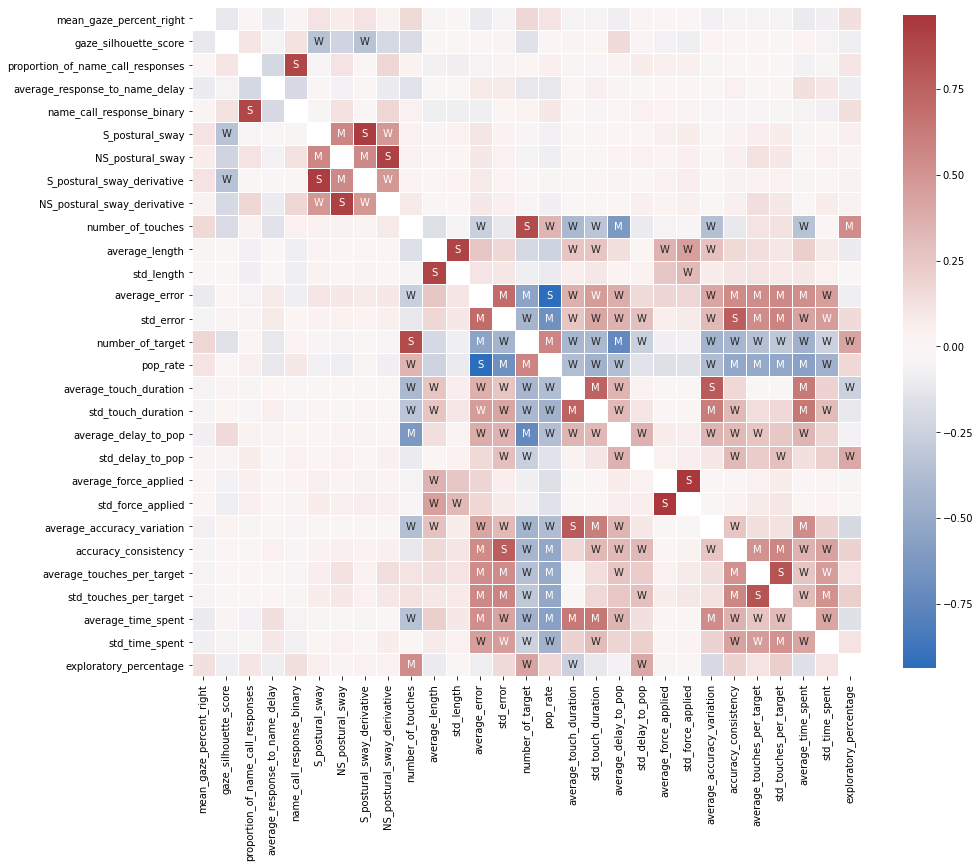

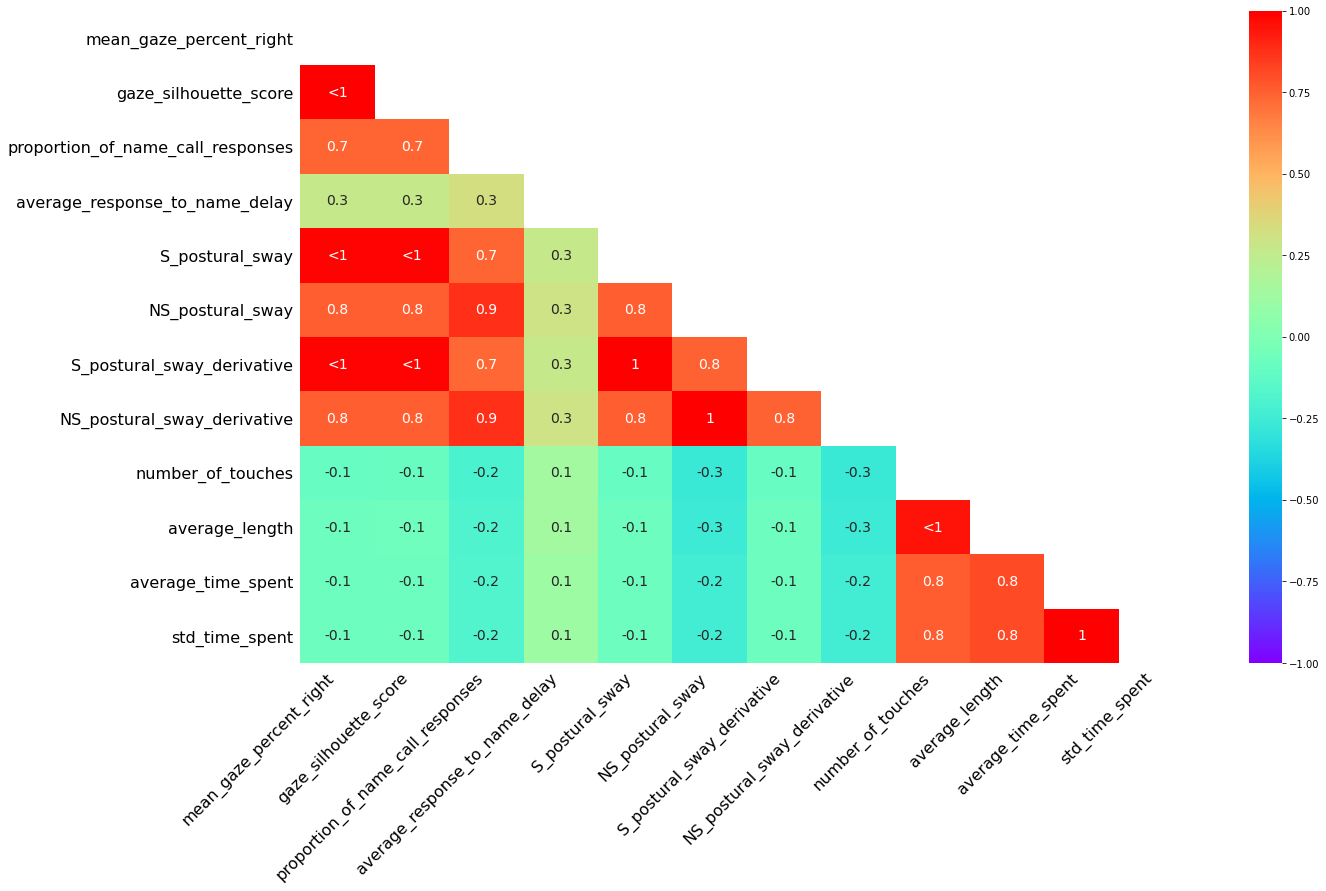

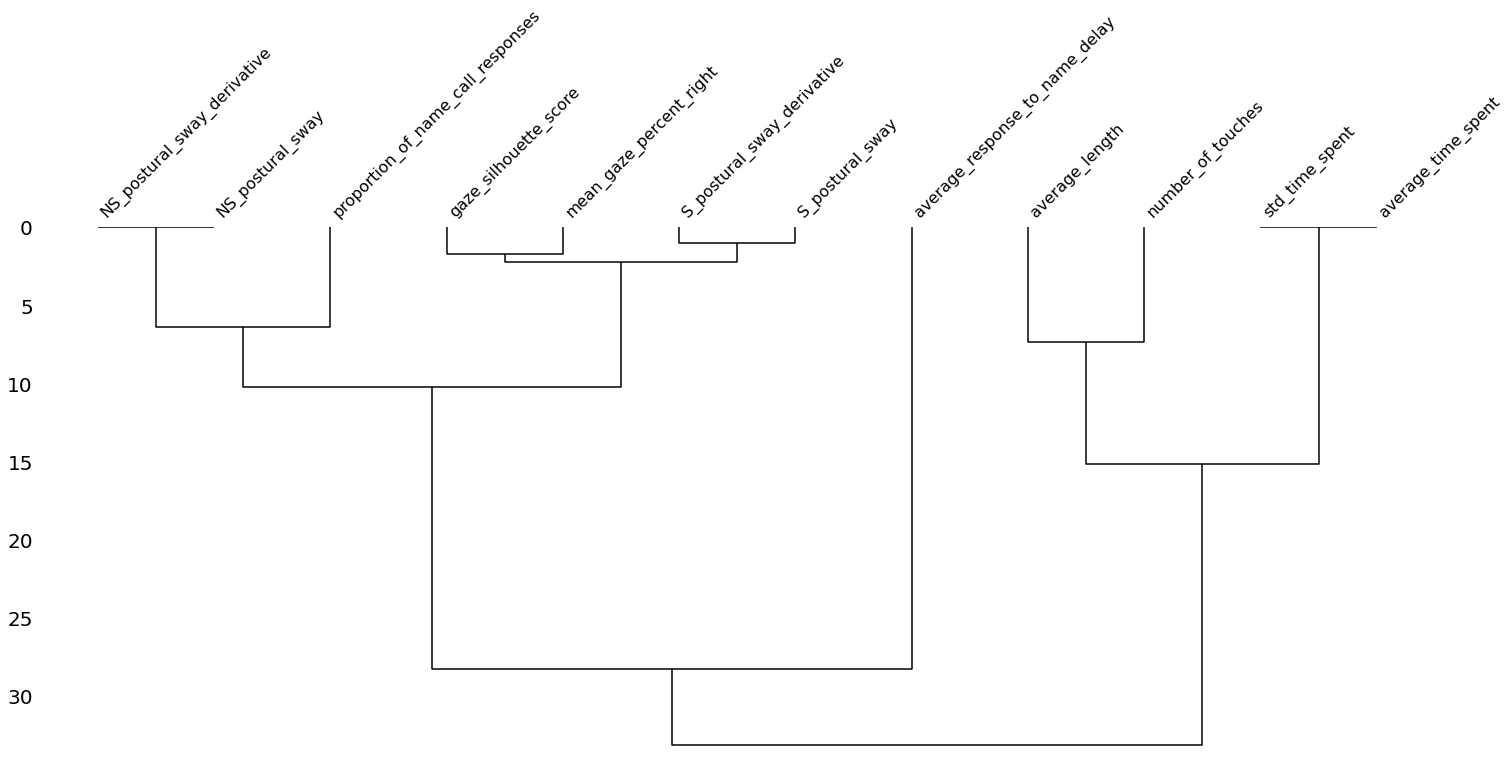

In [11]:
import missingno as msno
data.features_name = DEFAULT_PREDICTORS
df_X = df[data.features_name]
# Computes feature correlation
df_corr = df_X.corr(method="pearson")
labels = np.where(np.abs(df_corr)>0.75, "S",
                  np.where(np.abs(df_corr)>0.5, "M",
                           np.where(np.abs(df_corr)>0.25, "W", "")))

# Plot correlation matrix
plt.figure(figsize=(15, 15))
sns.heatmap(df_corr, mask=np.eye(len(df_corr)), square=True,
            center=0, annot=labels, fmt='', linewidths=.5,
            cmap="vlag", cbar_kws={"shrink": 0.8});

#plt.figure(figsize=(15, 15))
#df.isna().mean().sort_values().plot(kind="bar", figsize=(15, 4),
#                                    title="Percentage of missing values per feature");

    
features_for_missing_correlations = ['mean_gaze_percent_right',
                             'gaze_silhouette_score',
                             'proportion_of_name_call_responses',
                             'average_response_to_name_delay',
                             'S_postural_sway',
                             'NS_postural_sway',
                             'S_postural_sway_derivative',
                             'NS_postural_sway_derivative',
                             'number_of_touches',
                             'average_length',
                             'average_time_spent',
                             'std_time_spent']
df_X = df[features_for_missing_correlations]
msno.heatmap(df_X, cmap='rainbow');
msno.dendrogram(df_X)

Text(0, 0.5, 'Number of administration with this pattern missing.')

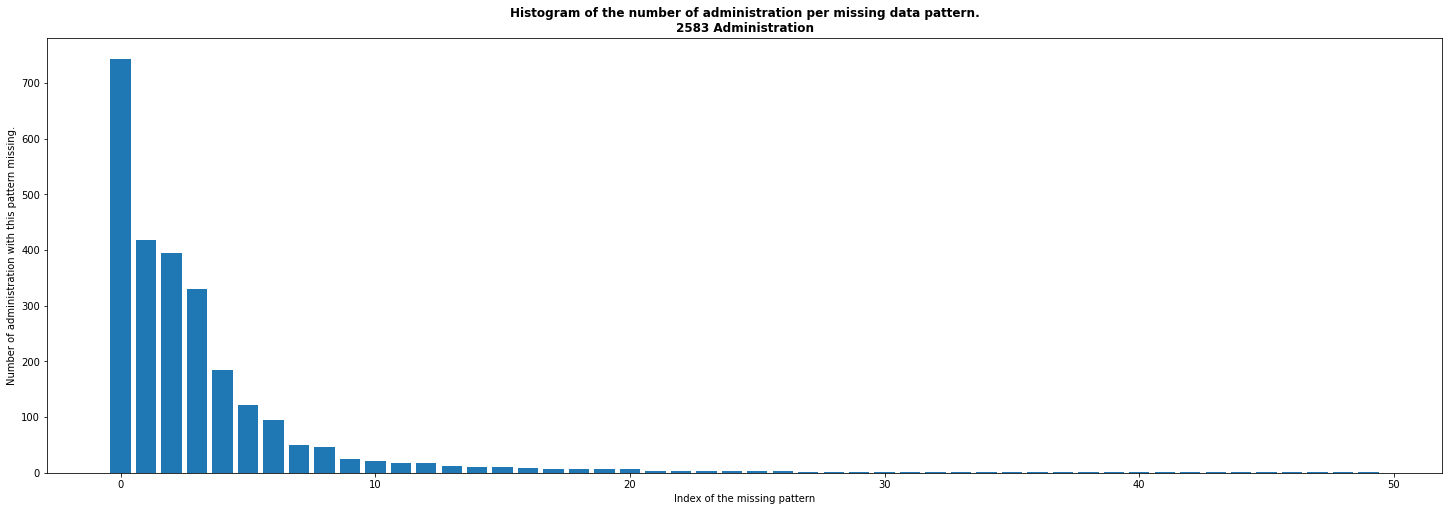

In [9]:
variables_of_interest = DEFAULT_PREDICTORS


X  = data.df[variables_of_interest]
dataset = X.copy()

vars = dataset.dtypes.index.values
n_var = dataset.shape[1]
# mean and covariance estimates
# ideally, this is done with a maximum likelihood estimator
gmean = dataset.mean()
gcov = dataset.cov()

# set up missing data patterns
r = 1 * dataset.isnull()
mdp = np.dot(r, list(map(lambda x: pow(2, x), range(n_var))))
sorted_mdp = sorted(np.unique(mdp))
n_pat = len(sorted_mdp)
correct_mdp = list(map(lambda x: sorted_mdp.index(x), mdp))
data.df["mdp"] = pd.Series(correct_mdp, index=dataset.index)

plt.figure(figsize=(25, 8))
plt.bar(x=np.arange((len(data.df["mdp"].value_counts().index))), height=data.df["mdp"].value_counts().to_numpy())
plt.title("Histogram of the number of administration per missing data pattern.\n{} Administration".format(len(data.df)), weight='bold');plt.xlabel("Index of the missing pattern"); plt.ylabel("Number of administration with this pattern missing.")

In [10]:
print("Number of missing patterns: {} (over {} theoretically possible; 2^K)".format(n_pat, 2**len(variables_of_interest)))

Number of missing patterns: 50 (over 536870912 theoretically possible; 2^K)


Text(0.5, 1.0, 'Features missing for the most frequent patterns. 2583 adm (1769 NT, 438 ASD)')

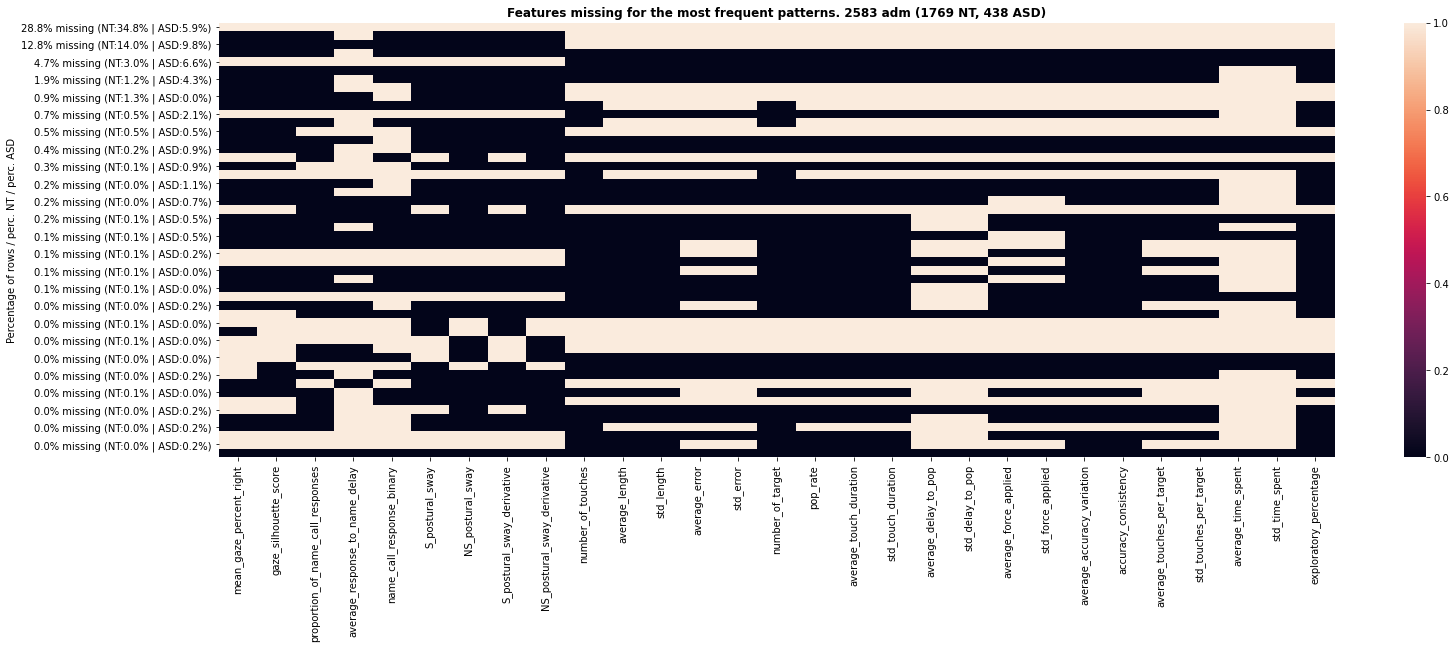

In [15]:

matrix = pd.DataFrame(
            data=np.zeros(shape=(len(data.df["mdp"].value_counts().index), len(variables_of_interest)+1)),
            columns=variables_of_interest+['Percentage of rows'],
            index=data.df["mdp"].unique(),
        ).sort_index()

for pattern in sorted(data.df["mdp"].unique())[1:]:
    d = data.df.loc[data.df['mdp']==pattern, ['diagnosis'] + variables_of_interest]
    missing_columns = list(d.columns[d.isnull().any()])
    matrix.loc[pattern, missing_columns] = 1
    matrix.loc[pattern, 'Percentage of rows'] = np.round(len(d)/len(data.df)*100,2)
    #matrix.loc[pattern, 'Percentage of rows (autism)'] = np.round(len(d[d['diagnosis']==0])/len(data.df[data.df['diagnosis']==0])*100,2)
    #matrix.loc[pattern, 'Percentage of rows (NT)'] = np.round(len(d[d['diagnosis']==1])/len(data.df[data.df['diagnosis']==1])*100,2)
    matrix.loc[pattern, 'Percentage of rows / perc. NT / perc. ASD'] = "{}% missing (NT:{}% | ASD:{}%)".format(np.round(len(d)/len(data.df)*100,1), np.round(len(d[d['diagnosis']==0])/len(data.df[data.df['diagnosis']==0])*100,1), np.round(len(d[d['diagnosis']==1])/len(data.df[data.df['diagnosis']==1])*100,1))
matrix.sort_values('Percentage of rows', ascending=False, inplace=True)
#matrix.set_index('Percentage of rows / perc. NT / perc. ASD', inplace=True)
#matrix = matrix.transpose()
plt.figure(figsize=(25, 8))
sns.heatmap(matrix.set_index('Percentage of rows / perc. NT / perc. ASD').loc[:, variables_of_interest].astype(int))
plt.title("Features missing for the most frequent patterns. {} adm ({} NT, {} ASD)".format(len(data.df), len(data.df[data.df['diagnosis']==0]), len(data.df[data.df['diagnosis']==1])), weight='bold')

<AxesSubplot:ylabel='Percentage of rows / perc. NT / perc. ASD'>

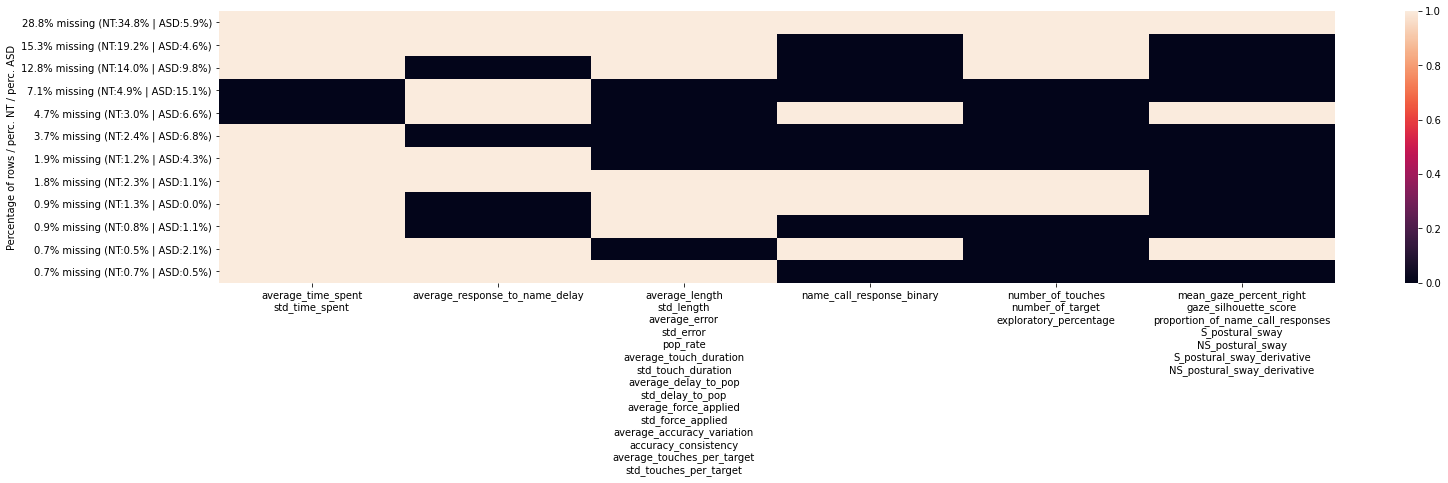

In [16]:
matrix = matrix.loc[matrix['Percentage of rows'] >.5, :].transpose()

new_df = matrix.loc[['Percentage of rows / perc. NT / perc. ASD'], :].copy()
duplicated_rows = matrix[matrix.duplicated(keep=False)]

for i, f in duplicated_rows.groupby(list(duplicated_rows)):
    index = ""
    for col in f.index:
        index+=col+"\n"
    index = index[:-1]
    new_df = new_df.append(pd.DataFrame(data=f.iloc[:1].to_numpy().astype(int), index=[index], columns=f.columns))
    
    
new_df = new_df.append(matrix[~matrix.duplicated(keep=False)].drop(index=['Percentage of rows','Percentage of rows / perc. NT / perc. ASD'])).transpose()

new_df.set_index('Percentage of rows / perc. NT / perc. ASD', inplace=True)
new_df = new_df.loc[:,list(new_df.sum(axis=0).sort_values(ascending=False).index)]
plt.figure(figsize=(25, 5))
sns.heatmap(new_df.astype(int))

In [399]:
data.df[data.df[variables_of_interest].isna()]
data.df.drop(index=data.df.dropna(subset=variables_of_interest, how='all').index).groupby('face_tracking').count()#.count_values()

id  diagnosis  language  app_version  subject  administration  features_extracted  age  date  path  sex  ethnicity  race  primary_education  mullen_el  mullen_fm  mullen_rl  mullen_vr  mullen_elc_std  ados_total  ados_rrb  ados_sa  srs_total_tscore  srs_social_awareness_tscore  srs_social_motivation_tscore  cbcl_scaleIV_score  cbcl_asd_score  mchat_total  mchat_final  mchat_result  BB_gaze_percent_right  BB_gaze_silhouette_score  S_gaze_percent_right  S_gaze_silhouette_score  FP_gaze_speech_correlation  FP_gaze_silhouette_score  proportion_of_name_call_responses  average_response_to_name_delay  FB_postural_sway  FB_postural_sway_derivative  DIGC_postural_sway  DIGC_postural_sway_derivative  DIGRRL_postural_sway  DIGRRL_postural_sway_derivative  ST_postural_sway  ST_postural_sway_derivative  MP_postural_sway  MP_postural_sway_derivative  PB_postural_sway  PB_postural_sway_derivative  ...  PWB_postural_sway  PWB_postural_sway_derivative  FP_postural_sway  \
face_tracking                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                   ...                                                                      
0              621        621       621          621      621             621                 621  621   621   621  621        611   554                621          0          0          0          0               0           0         0        0                 1                            1                             1                   1               1          180          180           180                      0                         0                     0                        0                           0                         0                                  0                               0                 0                            0                   0                              0                     0                                0                 0                            0                 0                            0                 0                            0  ...                  0                             0                 0   
1               56         56        56           56       56              56                  56   56    56    56   56         55    54                 56          0          0          0          0               0           0         0        0                 1                            1                             1                   2               2           43           43            43                      0                         0                     0                        0                           1                         0                                  0                               0                 0                            0                   0                              0                     0                                0                 0                            0                 0                            0                 0                            0  ...                  0                             0                 0   

               FP_postural_sway_derivative  number_of_touches  average_

# Encoding the group of missing variables as indicator variables

In [68]:
df = pd.read_csv("/Users/samperochon/Duke/work/notes_on_stats/df_all.csv")

df['stimuli_version'] = df['path'].apply(lambda path: path.split('/')[-2])
df.loc[~df['stimuli_version'].isin(['Older_Than_18', '12_Months', '9_Months', '6_Months']), 'stimuli_version'] = 'Older_Than_18'



data = Dataset(df=df, 
                   use_missing_indicator_variables=True,
                   missing_data_handling='encoding', 
                   imputation_method='without', 
                   sampling_method='without',
                   outcome_column='Z_mean_gaze_percent_right',
                   features_name=CVA_COLUMNS,#+ CLINICAL_COLUMNS + VALIDITY_COLUMNS,
                   scenario=None,#'asd_td_age_matched_n_balanced',
                   proportion_train=1)
data.filter(administration={'complete': True})

Post-processing inital df (removing columns with no cva features, encoding srings, compute administrations order, compute condensed S/NS variables)... 
Predicting Z_mean_gaze_percent_right based on 102 features
Splitting dataset into test and train set.
Encoding 1956 (train) and 0 (test) missing values with -5.
Removing 116/1956 incomplete administrations.
1840 administrations left.


id
diagnosis      
-1.0        141
 0.0       1154
 1.0        412
 2.0         40
 3.0         82
 4.0         11

Splitting dataset into test and train set.
Encoding 1840 (train) and 0 (test) missing values with -5.


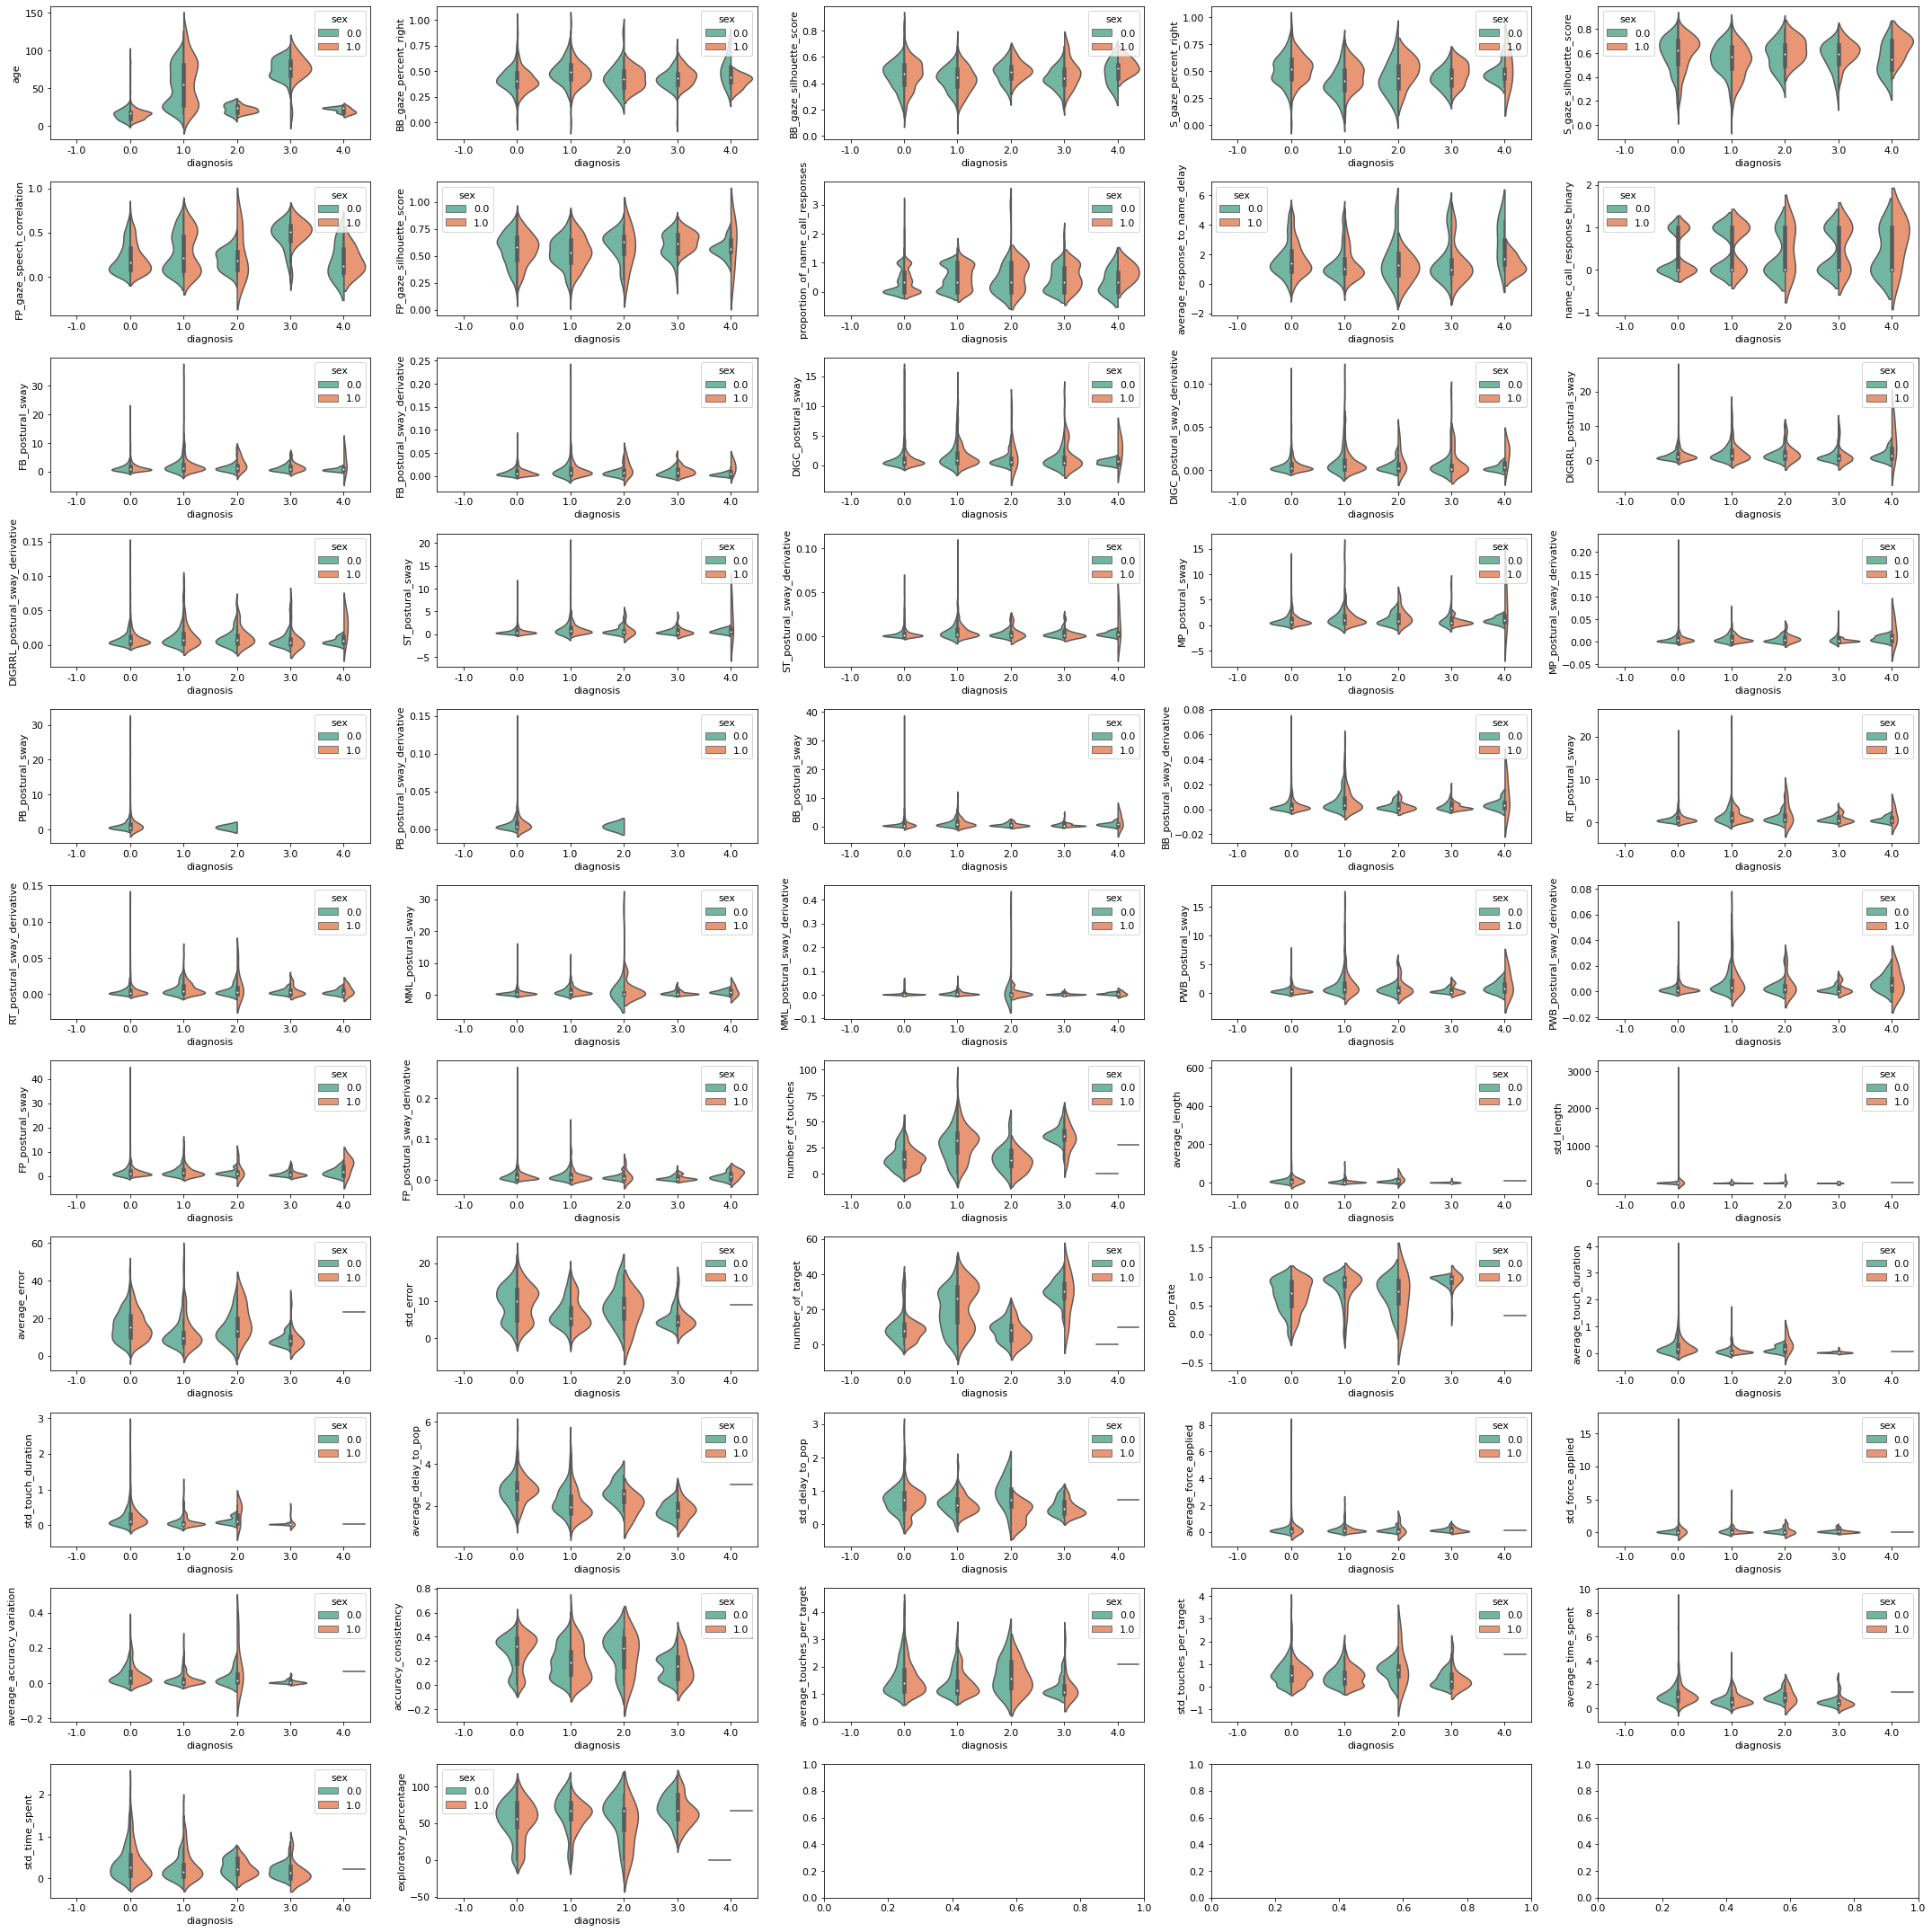

In [70]:
selected_features = ['age'] + CVA_COLUMNS

# Create a figure with 3 x 2 subplots
fig, axes = plt.subplots(ncols=5, nrows=len(selected_features)//5 +1, figsize=(30, 30))
# Loop through these features and plot entries from each feature against `Latitude`
for col, ax in zip(selected_features, axes.ravel()):
    sns.violinplot(data=df, y=col, x='diagnosis', hue='sex', palette="Set2",
                   split=True, ax=ax)
plt.tight_layout()

In [60]:
variables_of_interest = CVA_COLUMNS


X  = data.df[variables_of_interest]
dataset = X.copy()

vars = dataset.dtypes.index.values
n_var = dataset.shape[1]
# mean and covariance estimates
# ideally, this is done with a maximum likelihood estimator
gmean = dataset.mean()
gcov = dataset.cov()

# set up missing data patterns
r = 1 * dataset.isnull()
mdp = np.dot(r, list(map(lambda x: pow(2, x), range(n_var))))
sorted_mdp = sorted(np.unique(mdp))
n_pat = len(sorted_mdp)
correct_mdp = list(map(lambda x: sorted_mdp.index(x), mdp))
data.df["mdp"] = pd.Series(correct_mdp, index=dataset.index)

In [61]:
print("Number of missing patterns: {} (over {} theoretically possible; 2^K)".format(n_pat, 2**len(variables_of_interest)))

Number of missing patterns: 210 (over 2251799813685248 theoretically possible; 2^K)


Text(0.5, 1.0, 'Features missing for the most frequent patterns. 1840 adm (1154 NT, 412 ASD)')

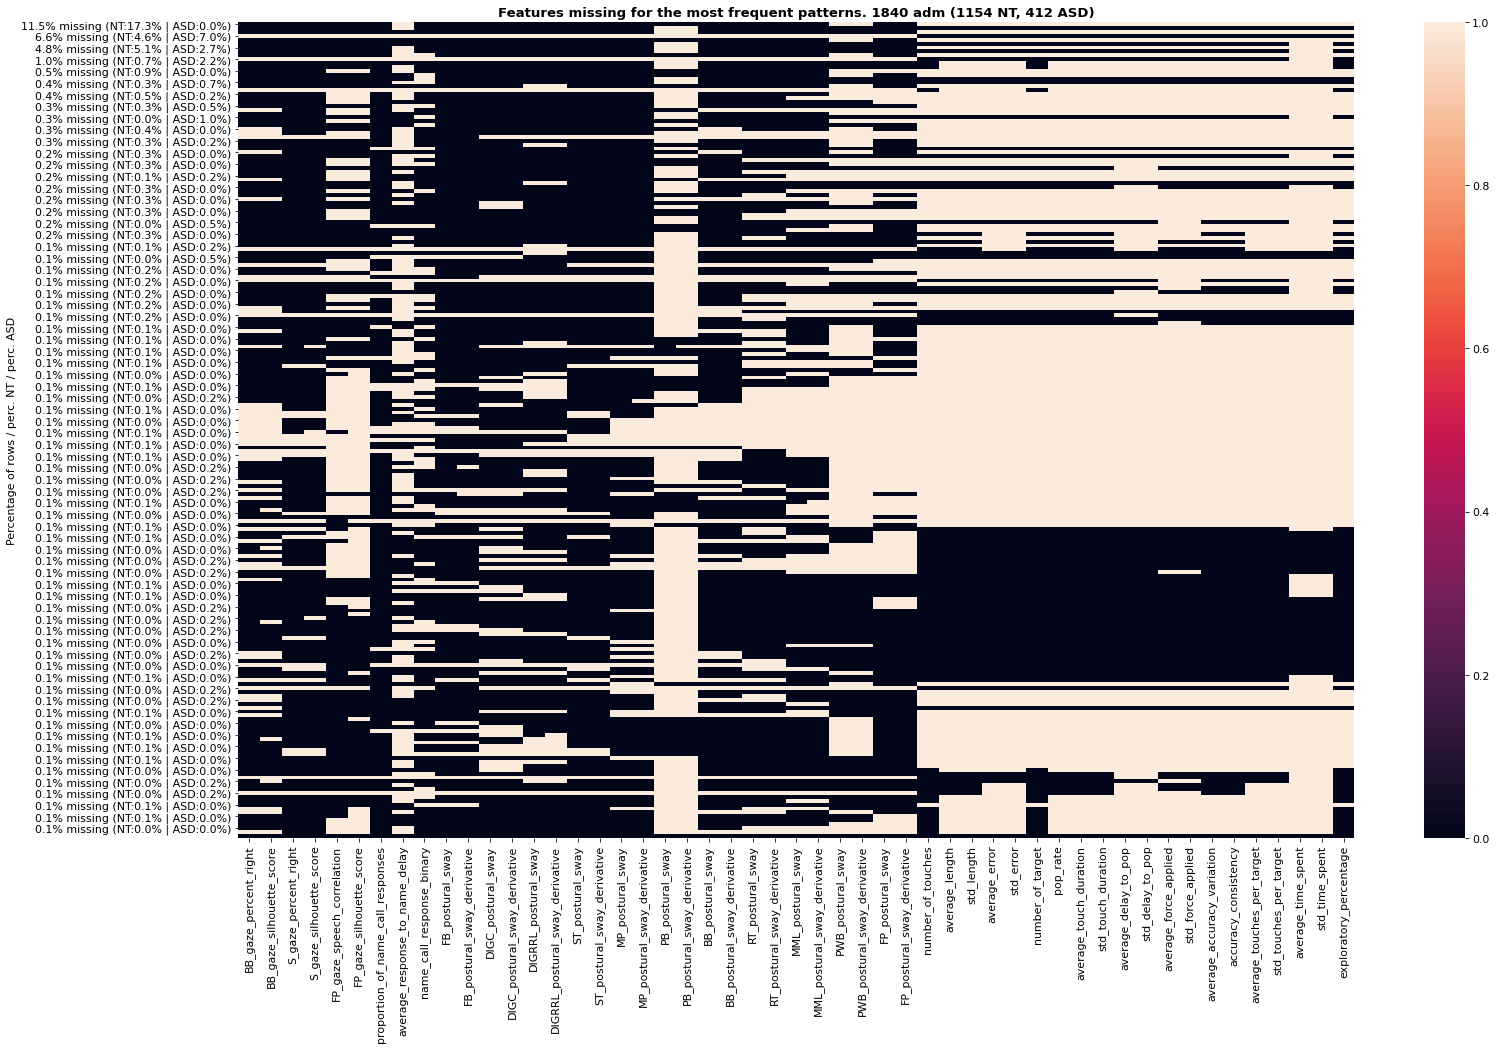

In [62]:

matrix = pd.DataFrame(
            data=np.zeros(shape=(len(data.df["mdp"].value_counts().index), len(variables_of_interest)+1)),
            columns=variables_of_interest+['Percentage of rows'],
            index=data.df["mdp"].unique(),
        ).sort_index()

for pattern in sorted(data.df["mdp"].unique())[1:]:
    d = data.df.loc[data.df['mdp']==pattern, ['diagnosis'] + variables_of_interest]
    missing_columns = list(d.columns[d.isnull().any()])
    matrix.loc[pattern, missing_columns] = 1
    matrix.loc[pattern, 'Percentage of rows'] = np.round(len(d)/len(data.df)*100,2)
    #matrix.loc[pattern, 'Percentage of rows (autism)'] = np.round(len(d[d['diagnosis']==0])/len(data.df[data.df['diagnosis']==0])*100,2)
    #matrix.loc[pattern, 'Percentage of rows (NT)'] = np.round(len(d[d['diagnosis']==1])/len(data.df[data.df['diagnosis']==1])*100,2)
    matrix.loc[pattern, 'Percentage of rows / perc. NT / perc. ASD'] = "{}% missing (NT:{}% | ASD:{}%)".format(np.round(len(d)/len(data.df)*100,1), np.round(len(d[d['diagnosis']==0])/len(data.df[data.df['diagnosis']==0])*100,1), np.round(len(d[d['diagnosis']==1])/len(data.df[data.df['diagnosis']==1])*100,1))
matrix.sort_values('Percentage of rows', ascending=False, inplace=True)
plt.figure(figsize=(25, 15))
sns.heatmap(matrix.set_index('Percentage of rows / perc. NT / perc. ASD').loc[:, variables_of_interest].astype(int))
plt.title("Features missing for the most frequent patterns. {} adm ({} NT, {} ASD)".format(len(data.df), len(data.df[data.df['diagnosis']==0]), len(data.df[data.df['diagnosis']==1])), weight='bold')

<AxesSubplot:ylabel='Percentage of rows / perc. NT / perc. ASD'>

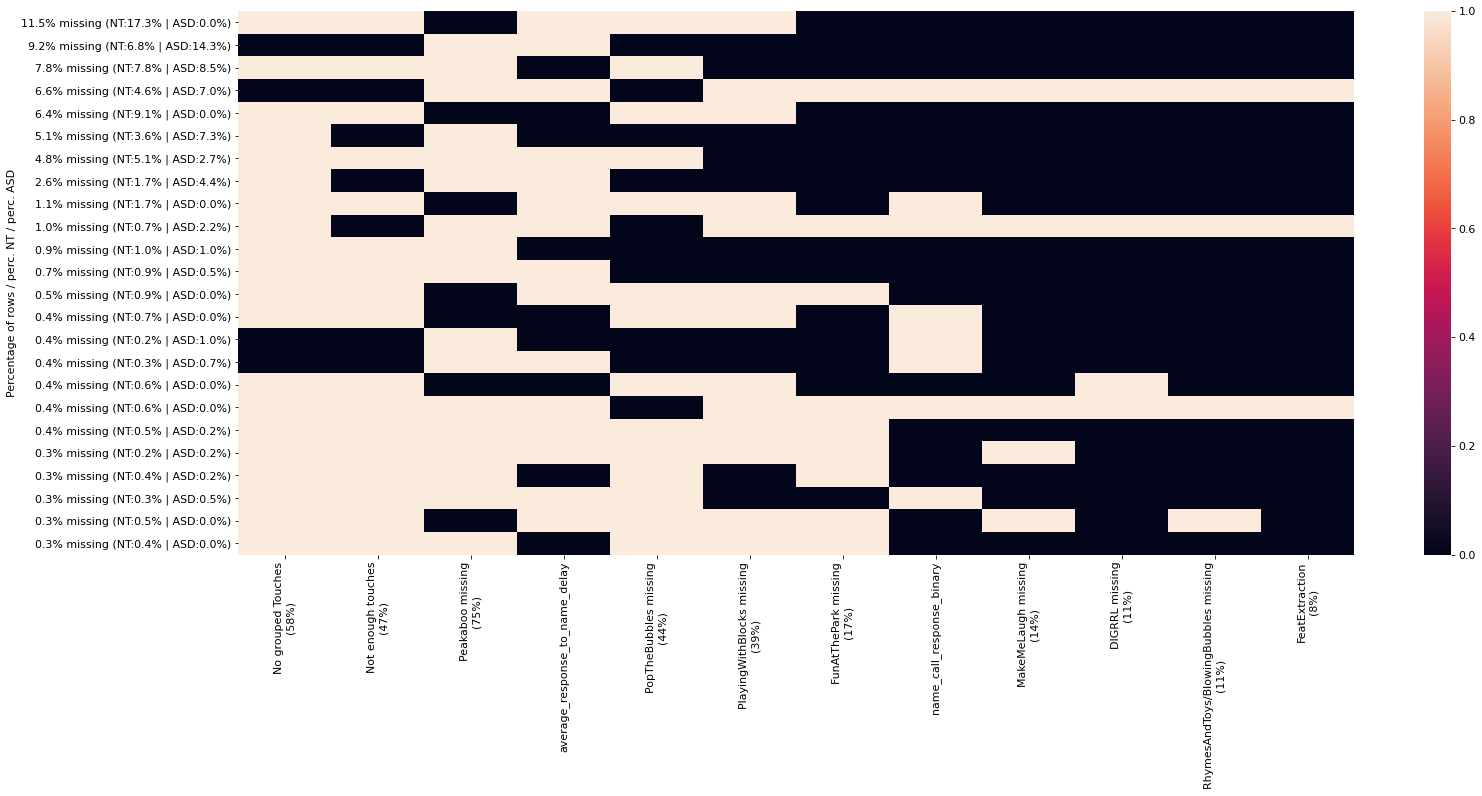

In [63]:
matrix = matrix.loc[matrix['Percentage of rows'] >.3, :].transpose()

new_df = matrix.loc[['Percentage of rows / perc. NT / perc. ASD'], :].copy()
duplicated_rows = matrix[matrix.duplicated(keep=False)]

grouped_features_label = {0:"FeatExtraction", 
                          1: "RhymesAndToys/BlowingBubbles missing", 
                          2: "MakeMeLaugh missing", 
                          3: "DIGRRL missing", 
                          4: "FunAtThePark missing", 
                          5: "Peakaboo missing", 
                          6: "PlayingWithBlocks missing", 
                          7: "PopTheBubbles missing", 
                          8: "Not enough touches", 
                          9: "No grouped Touches", 
                         }
def df_missing_features(df, features, having_features_missing=True):
    if having_features_missing:
        return df.loc[df.drop(index=df.dropna(subset=features, how='all').index).index, :]
    else:
        return df.dropna(subset=features, how='all')
    
    
grouped_features = {}
for idx, (i, f) in enumerate(duplicated_rows.groupby(list(duplicated_rows))):
    grouped_features[idx]=[]
    for col in f.index:
        grouped_features[idx].append(col)    
    
for i, feats in grouped_features.items():
    grouped_features_label[i] += "\n({}%)".format(int(len(df_missing_features(data.df, features=feats, having_features_missing=True))/len(data.df)*100))
    
    
for idx, (i, f) in enumerate(duplicated_rows.groupby(list(duplicated_rows))):
    index = ""
    for col in f.index:
        index+=col+"\n"
    index = index[:-1]
    new_df = new_df.append(pd.DataFrame(data=f.iloc[:1].to_numpy().astype(int), index=[grouped_features_label[idx]], columns=f.columns))
    

    
    
new_df = new_df.append(matrix[~matrix.duplicated(keep=False)].drop(index=['Percentage of rows','Percentage of rows / perc. NT / perc. ASD'])).transpose()
new_df.set_index('Percentage of rows / perc. NT / perc. ASD', inplace=True)
new_df = new_df.loc[:,list(new_df.sum(axis=0).sort_values(ascending=False).index)]

plt.figure(figsize=(25, 10))
sns.heatmap(new_df.astype(int))

## Adding the indicator variables to the dataframe

In [65]:
for i, feats in grouped_features.items():
    data.df['Z_grouped_{}'.format(i)] = 0
    data.df.loc[data.df.drop(index=data.df.dropna(subset=feats, how='all').index).index, 'Z_grouped_{}'.format(i)] = 1


# Little test 


In [35]:
"""Statistical hypothesis test for Missing Completely At Random (MCAR)"""
# Author: Rianne Schouten <https://rianneschouten.github.io/>
# Co-Author: Davina Zamanzadeh <https://davinaz.me/>

from logging import error
import numpy as np
import pandas as pd
from math import pow
from scipy.stats import chi2, ttest_ind

from typing import List, Union
Matrix = Union[pd.DataFrame, np.ndarray]


class MCARTest:
    """
    Statistical hypothesis test for Missing Completely At Random (MCAR)

    Performs Little's MCAR test (see `Little, R.J.A. (1988)`_). Null hypothesis: data is Missing Completely At Random (MCAR). Alternative hypothesis: data is not MCAR.

    .. _`Little, R.J.A. (1988)`: https://www.tandfonline.com/doi/abs/10.1080/01621459.1988.10478722

    Parameters
    ----------
    method : str, {"little", "ttest"}, default : "little"
        Whether to perform a chi-square test on the entire dataset ("little") or separate t-tests for every combination of variables ("ttest"). 

    See also
    --------
    :class:`~pyampute.exploration.md_patterns.mdPatterns` : Displays missing data patterns in incomplete datasets
    
    :class:`~pyampute.ampute.MultivariateAmputation` : Transformer for generating multivariate missingness in complete datasets

    Notes
    -----
    We advise to use Little's MCAR test carefully. Rejecting the null hypothesis may not always mean that data is not MCAR, nor is accepting the null hypothesis a guarantee that data is MCAR. See `Schouten et al. (2021)`_ for a thorough discussion of missingness mechanisms. 

    .. _`Schouten et al. (2021)`: https://journals.sagepub.com/doi/full/10.1177/0049124118799376

    Examples
    --------
    >>> import pandas as pd
    >>> from pyampute.exploration.mcar_statistical_tests import MCARTest
    >>> data_mcar = pd.read_table("data/missingdata_mcar.csv")
    >>> mt = MCARTest(method="little")
    >>> print(mt.little_mcar_test(data_mcar))
    0.17365464213775494    
    """

    def __init__(self, method: str = "little"):
        self.method = method

    def __call__(self, data: Matrix) -> float:
        if self.method == "little":
            return self.little_mcar_test(data)
        elif self.method == "ttest":
            return self.mcar_t_tests(data)
        else:
            error(
                f"Chose {self.method} as test method, which is not supported. Please choose from [little, ttest]."
            )

    @staticmethod
    def little_mcar_test(X: Matrix) -> float:
        """
        Implementation of Little's MCAR test
        
        Parameters
        ----------
        X : Matrix of shape `(n, m)`
            Dataset with missing values. `n` rows (samples) and `m` columns (features).

        Returns
        -------
        pvalue : float
            The p-value of a chi-square hypothesis test. Null hypothesis: data is Missing Completely At Random (MCAR). Alternative hypothesis: data is not MCAR.
        """

        dataset = X.copy()
        vars = dataset.dtypes.index.values
        n_var = dataset.shape[1]

        # mean and covariance estimates
        # ideally, this is done with a maximum likelihood estimator
        gmean = dataset.mean()
        gcov = dataset.cov()

        # set up missing data patterns
        r = 1 * dataset.isnull()
        mdp = np.dot(r, list(map(lambda x: pow(2, x), range(n_var))))
        sorted_mdp = sorted(np.unique(mdp))
        n_pat = len(sorted_mdp)
        correct_mdp = list(map(lambda x: sorted_mdp.index(x), mdp))
        dataset["mdp"] = pd.Series(correct_mdp, index=dataset.index)

        # calculate statistic and df
        pj = 0
        d2 = 0
        for i in range(n_pat):
            dataset_temp = dataset.loc[dataset["mdp"] == i, vars]
            select_vars = ~dataset_temp.isnull().any()
            pj += np.sum(select_vars)
            select_vars = vars[select_vars]
            means = dataset_temp[select_vars].mean() - gmean[select_vars]
            select_cov = gcov.loc[select_vars, select_vars]
            mj = len(dataset_temp)
            parta = np.dot(
                means.T, np.linalg.solve(select_cov, np.identity(select_cov.shape[1]))
            )
            d2 += mj * (np.dot(parta, means))

        df = pj - n_var

        # perform test and save output
        pvalue = 1 - chi2.cdf(d2, df)

        return pvalue

    @staticmethod
    def mcar_t_tests(X: Matrix) -> pd.DataFrame:
        """
        Performs t-tests for MCAR for each pair of features.

        Parameters
        ----------
        X : Matrix of shape `(n, m)`
            Dataset with missing values. `n` rows (samples) and `m` columns (features).

        Returns
        -------
        pvalues : pandas DataFrame of shape `(m, m)`
            The p-values of t-tests for each pair of features. Null hypothesis for cell :math:`pvalues[h,j]`: data in feature :math:`h` is Missing Completely At Random (MCAR) with respect to feature :math:`j` for all :math:`h,j` in :math:`{1,2,...m}`. Diagonal values do not exist. 
        """
        dataset = X.copy()
        vars = dataset.dtypes.index.values
        mcar_matrix = pd.DataFrame(
            data=np.zeros(shape=(dataset.shape[1], dataset.shape[1])),
            columns=vars,
            index=vars,
        )

        for var in vars:
            for tvar in vars:
                part_one = dataset.loc[dataset[var].isnull(), tvar].dropna()
                part_two = dataset.loc[~dataset[var].isnull(), tvar].dropna()
                mcar_matrix.loc[var, tvar] = ttest_ind(
                    part_one, part_two, equal_var=False
                ).pvalue

        return mcar_matrix[mcar_matrix.notnull()]

## Ttest on the continuous features

In [66]:
data.df

id  diagnosis language app_version                                        subject                                     administration  features_extracted  face_tracking        age                date                                               path  sex  ethnicity  race  primary_education  mullen_el  mullen_fm  mullen_rl  mullen_vr  mullen_elc_std  ados_total  ados_rrb  ados_sa  srs_total_tscore  srs_social_awareness_tscore  srs_social_motivation_tscore  cbcl_scaleIV_score  cbcl_asd_score  mchat_total  mchat_final  mchat_result  BB_gaze_percent_right  BB_gaze_silhouette_score  S_gaze_percent_right  S_gaze_silhouette_score  FP_gaze_speech_correlation  FP_gaze_silhouette_score  proportion_of_name_call_responses  average_response_to_name_delay  name_call_response_binary  FB_postural_sway  FB_postural_sway_derivative  DIGC_postural_sway  DIGC_postural_sway_derivative  DIGRRL_postural_sway  DIGRRL_postural_sway_derivative  ST_postural_sway  ST_postural_sway_derivative  \
0        300103        0.0  English         3.2  <Subject.S2KSubject object at 0x7fcb68f9c750>  <Administration.S2KAdministration object at 0x...                   1              1  20.590164 2021-05-10 16:30:00  /diskD/AutismCenter/Data/SenseToKnow/Processed...  1.0        0.0   0.0                8.0        NaN        NaN        NaN        NaN             NaN         NaN       NaN      NaN               NaN                          NaN                           NaN                 NaN             NaN          1.0          1.0           0.0               0.447829                  0.464719              0.481852                 0.769545                    0.377628                  0.698019                           0.000000                             NaN                        0.0          0.256003                     0.000626            0.583792                       0.002204              0.440407                         0.001961          0.143405                     0.000237   
1        300113        0.0  English         3.2  <Subject.S2KSubject object at 0x7fcb68f9ced0>  <Administration.S2KAdministration object at 0x...                   1              1  22.491803 2021-07-04 12:28:00  /diskD/AutismCenter/Data/SenseToKnow/Processed...  1.0        0.0   NaN                8.0        NaN        NaN        NaN        NaN             NaN         NaN       NaN      NaN               NaN                          NaN                           NaN                 NaN             NaN          1.0          1.0           0.0               0.375758                  0.478203              0.184178                 0.672051                    0.390016                  0.512949                           0.333333                        0.467133                        0.0          1.758436                     0.008622            3.949268                       0.022842              1.678718                         0.010896          0.580973                     0.003239   
2        300224        0.0  English         3.2  <Subject.S2KSubject object at 0x7fcb68fa4690>  <Administration.S2KAdministration object at 0x...                   1              1  19.377049 2021-04-16 13:34:00  /diskD/AutismCenter/Data/SenseToKnow/Processed...  0.0        0.0   0.0                8.0        NaN        NaN        NaN        NaN             NaN         NaN       NaN      NaN               NaN                          NaN                           NaN                 NaN             NaN          3.0          0.0           0.0                    NaN                       NaN              0.453525                 0.324997                         NaN                       NaN                           0.000000                             NaN                        0.0          0.292338                     0.000754            0.476432                       0.001731              3.371493                         0.018677          0.190611                     0.000371   
3        300224        0.0  Engli

In [39]:
variables_of_interest = list(grouped_features.values())


dict_check_1_0 = {9:[8],
                 10:[8, 9]}
    
    
vars = ['age', 'mullen_el',  'mullen_fm','mullen_rl','mullen_vr','mullen_elc_std','ados_total',  'ados_rrb',
         'ados_sa','srs_total_tscore', 'srs_social_awareness_tscore',
         'srs_social_motivation_tscore',
         'cbcl_scaleIV_score',
         'cbcl_asd_score',
         'mchat_total']


mcar_matrix = pd.DataFrame(
    data=np.zeros(shape=(len(vars), len(variables_of_interest))),
    columns=list(grouped_features.keys()),
    index=vars,
)


In [40]:
for i, feats in grouped_features.items():
    for j, var in enumerate(vars):
        
        d = data.df.copy()
        
        if i in dict_check_1_0.keys():
            for idx_group_that_should_be_there in dict_check_1_0[i]:
                d = d[d['Z_grouped_{}'.format(idx_group_that_should_be_there)]==0]
                
        
        having = df_missing_features(d, feats, having_features_missing=False)[var].dropna()
        missing = df_missing_features(d, feats, having_features_missing=True)[var].dropna()
        
        if len(having) < 20 or len(missing) < 20:
            mcar_matrix.loc[var, i] = np.nan
            continue
            
        mcar_matrix.loc[var, i] = ttest_ind(
                    having, missing, equal_var=False
                ).pvalue


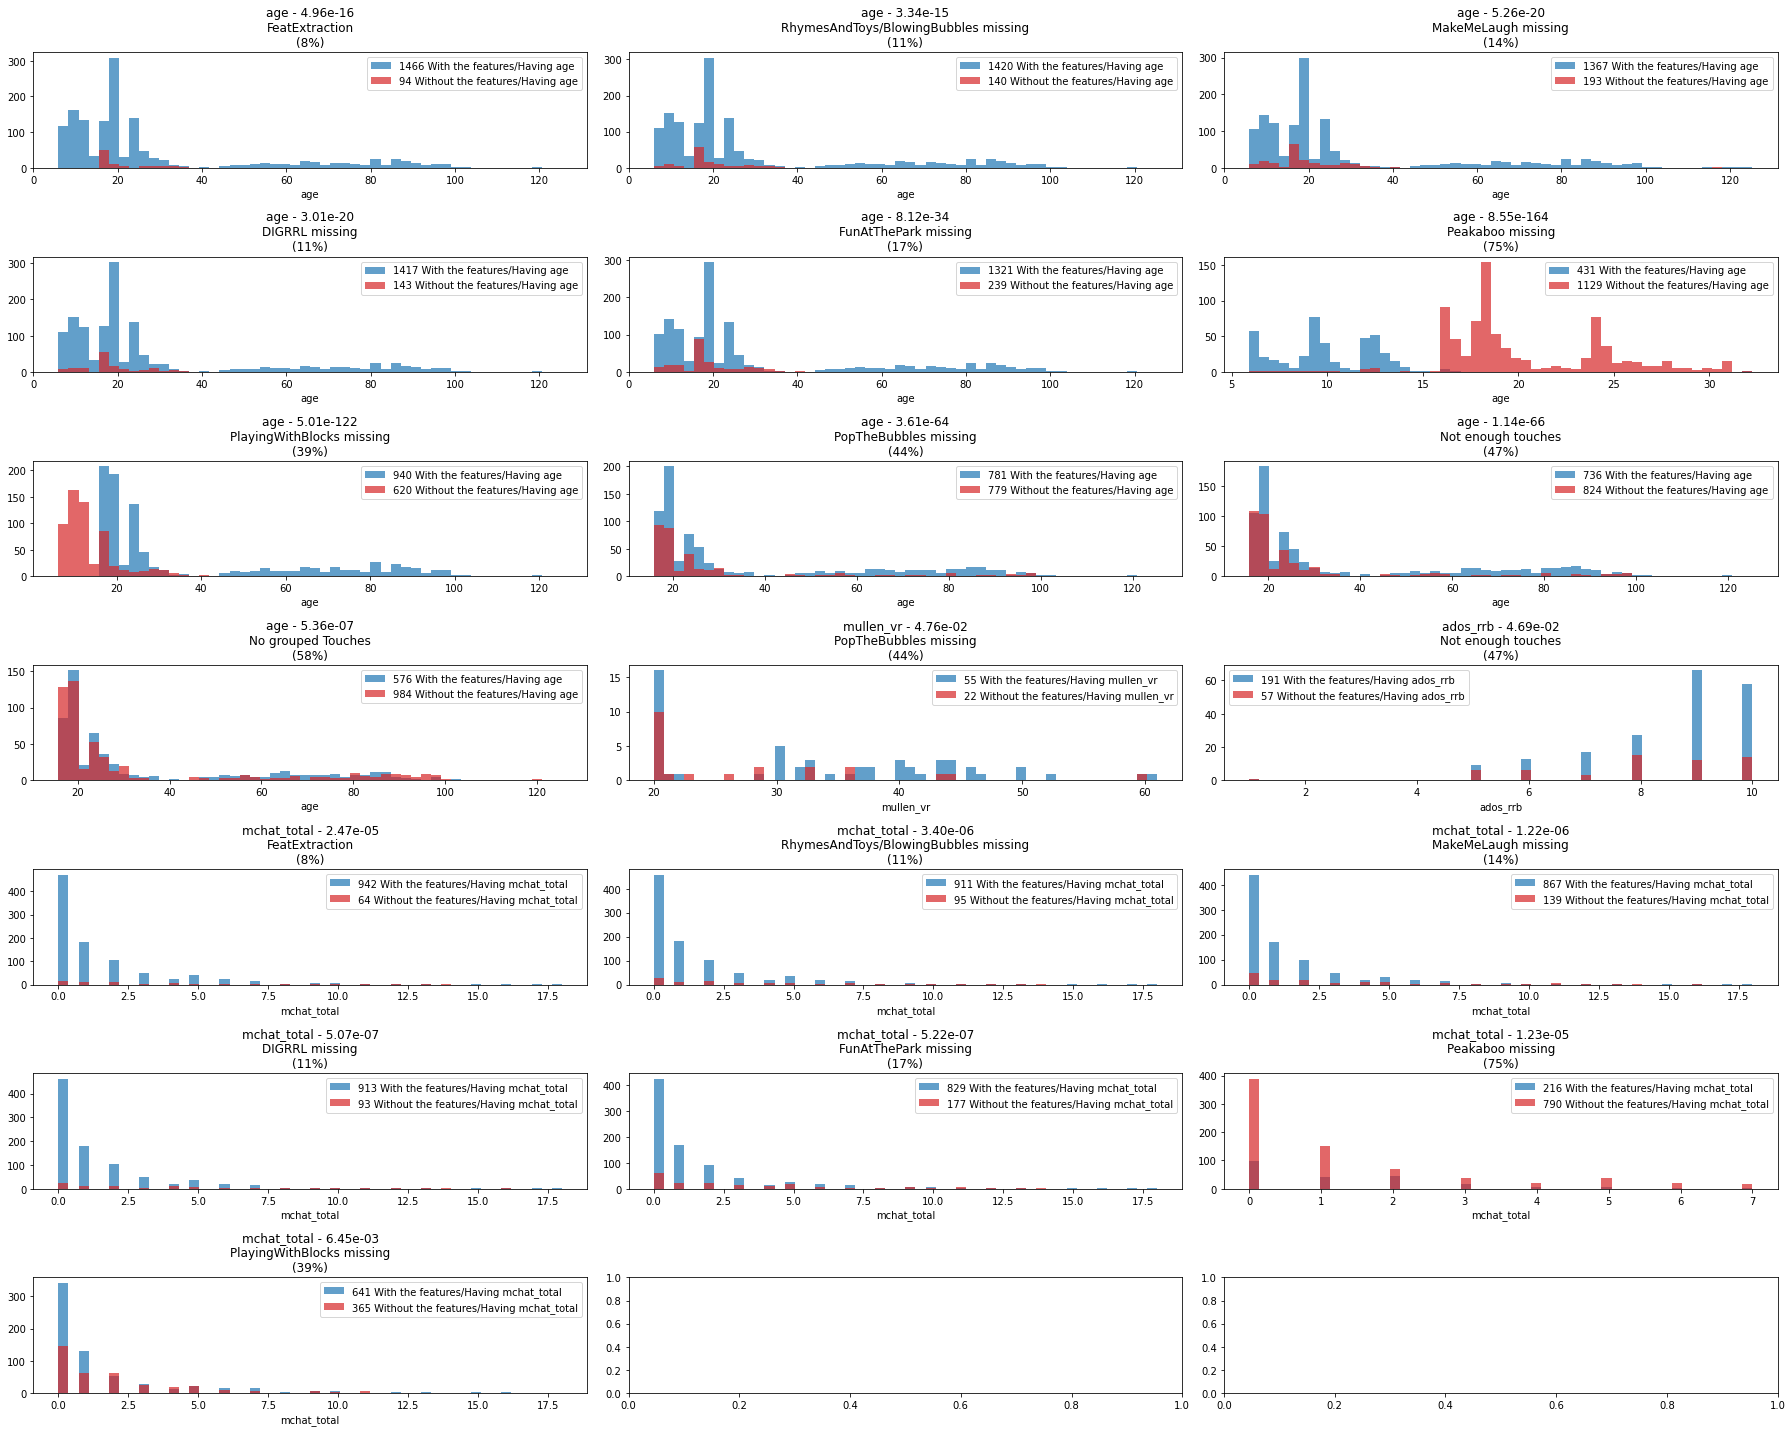

In [42]:
mask  = (mcar_matrix<0.05).astype(int)

locations = [(index, column) for index in mask.index for column in mask.columns if mask.loc[index, column]==1]

fig, axes = plt.subplots(len(locations)//3+1, 3, figsize=(25, 20));axes = axes.flatten()
for j, (var, idx) in enumerate(locations):
    feats = grouped_features[idx]
    
    having = df_missing_features(data.df, feats, having_features_missing=False)[var].dropna()
    missing = df_missing_features(data.df, feats, having_features_missing=True)[var].dropna()
    
    _, bins, _ = axes[j].hist(having, bins = 50, color='tab:blue', label='{} With the features/Having {}'.format(len(having), var), alpha=.7)
    axes[j].hist(missing, bins = bins, color='tab:red', label='{} Without the features/Having {}'.format(len(missing), var), alpha=.7)
    axes[j].set_title("{} - {:.2e}\n{}".format(var, mcar_matrix.loc[var, idx], grouped_features_label[idx]));axes[j].set_xlabel(var)
    axes[j].legend()
plt.tight_layout()

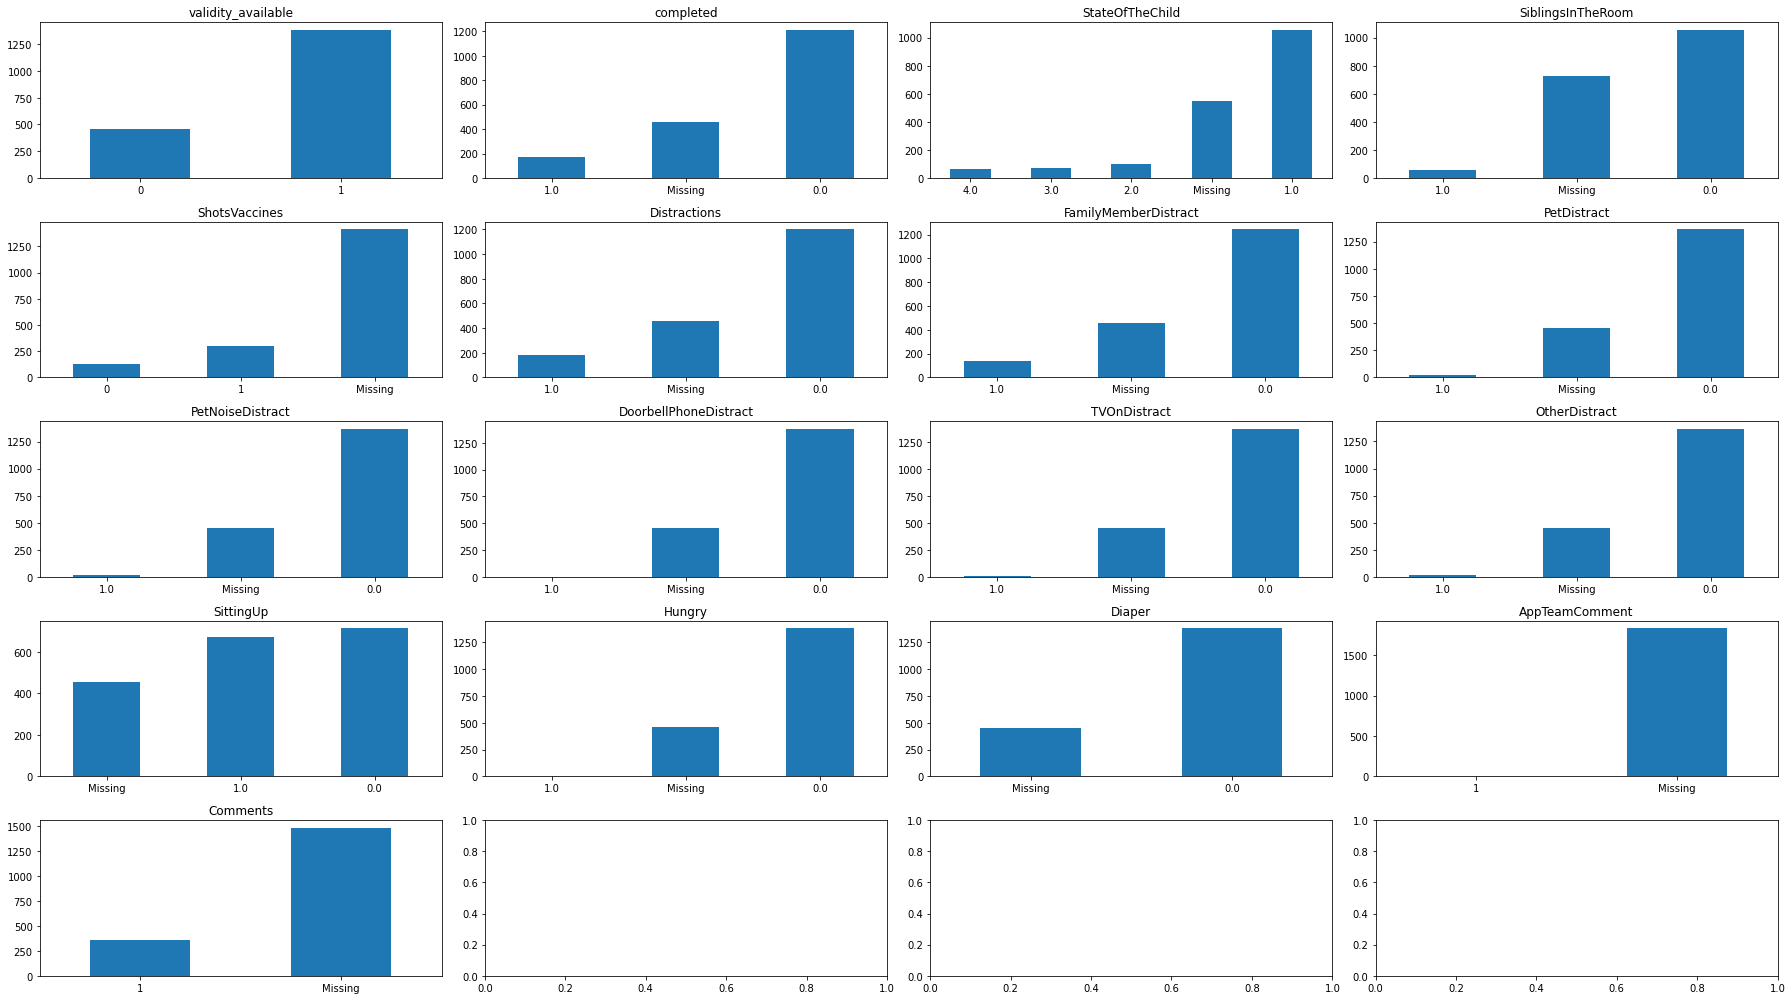

In [48]:
n_plot = len(VALIDITY_COLUMNS)

fig, axes = plt.subplots(n_plot//4+1, 4, figsize=(25, 14)); axes=axes.flatten()

for i, col in enumerate(VALIDITY_COLUMNS):
    data.df[col].replace({np.nan:'Missing'}).value_counts().sort_values().plot(kind='bar', rot=0, ax=axes[i])
    axes[i].set_title(col)
    
plt.tight_layout()

In [44]:
variables_of_interest = list(grouped_features.values())
vars = ['StateOfTheChild','SiblingsInTheRoom','ShotsVaccines','Distractions','FamilyMemberDistract','PetDistract',
        'PetNoiseDistract','DoorbellPhoneDistract','TVOnDistract','OtherDistract','SittingUp','Hungry','Diaper','AppTeamComment',
        'Comments','sex','diagnosis','ados_total','ados_rrb','ados_sa','mchat_result']

from scipy.stats import chi2_contingency
mcar_matrix = pd.DataFrame(
    data=np.zeros(shape=(len(vars), len(variables_of_interest))),
    columns=list(grouped_features.keys()),
    index=vars,
)

In [45]:
for i, feats in grouped_features.items():

    for j, var in enumerate(vars):
        
        d = data.df.copy()
        
        if i in dict_check_1_0.keys():
            for idx_group_that_should_be_there in dict_check_1_0[i]:
                d = d[d['Z_grouped_{}'.format(idx_group_that_should_be_there)]==0]
                
        
        having = df_missing_features(d, feats, having_features_missing=False)[var].dropna()
        missing = df_missing_features(d, feats, having_features_missing=True)[var].dropna()
        
        
        
        table = pd.crosstab(d['Z_grouped_{}'.format(i)], d[var]).to_numpy()
        
        stat, p, dof, expected = chi2_contingency(np.array(table))
        
        values_with = d[d['Z_grouped_{}'.format(i)]==0][var].dropna()
        values_without = d[d['Z_grouped_{}'.format(i)]==1][var].dropna()
        
        if len(values_with) < 20 or len(values_without) < 20:
            mcar_matrix.loc[var, i] = np.nan
            continue

    
        mcar_matrix.loc[var, i] = p
    

In [149]:
mcar_matrix

0             1             2             3             4             5              6              7              8         9         10
StateOfTheChild       NaN  1.598753e-01  1.216027e-01  7.832353e-02  2.048789e-01  4.574799e-02   2.665291e-09   1.620275e-10   1.236281e-10  0.022721  0.029297
SiblingsInTheRoom     NaN  1.847688e-01  3.699942e-01  4.199205e-02  1.465796e-01  8.759359e-03   2.567834e-09   2.304548e-12   1.329617e-11  0.114155  0.270805
ShotsVaccines         NaN           NaN           NaN           NaN           NaN           NaN            NaN            NaN   1.057023e-03  0.602413  1.000000
Distractions          NaN  2.343823e-03  4.182067e-03  1.964652e-05  1.945571e-06  4.639355e-07   8.366134e-21   3.602441e-28   5.237406e-19  1.000000  0.261098
FamilyMemberDistract  NaN  3.377626e-02  1.389179e-01  4.344470e-05  4.537562e-04  1.031222e-06   1.231342e-12   2.958843e-18   5.759516e-14  1.000000  0.541147
PetDistract           NaN  8.241094e-01  1.000000e+00  1.000000e+00  1.000000e+00  1.000000e+00   2.307399e-06   1.426468e-05   2.943212e-03  1.000000  1.000000
PetNoiseDistract      NaN  8.024143e-02  1.000000e+00  1.000000e+00  1.750233e-02  3.936222e-01   1.101309e-03   1.784304e-03   3.286367e-02  1.000000  1.000000
DoorbellPhoneDistract NaN  1.000000e+00  1.000000e+00  1.000000e+00  1.000000e+00  1.000000e+00   1.000000e+00   1.000000e+00   1.000000e+00  1.000000  1.000000
TVOnDistract          NaN  5.775788e-03  8.560969e-04  1.428429e-04  1.165420e-11  6.528204e-05   1.000000e+00   1.474390e-01   1.000000e+00  1.000000  0.649802
OtherDistract         NaN  5.674227e-01  3.393883e-02  1.651348e-01  1.000000e+00  1.146382e-01   2.775753e-03   8.120206e-04   9.576140e-04  1.000000  1.000000
SittingUp             NaN  9.901540e-15  1.024532e-10  7.666107e-18  4.590556e-12  3.880210e-26  3.954178e-141  4.752808e-177  1.148764e-128  1.000000  0.004436
Hungry                NaN  2.575199e-01  1.000000e+00  3.115089e-01  1.000000e+00  1.000000e+00   8.501226e-01   7.091533e-01   1.000000e+00  1.000000  1.000000
Diaper                NaN  1.000000e+00  1.000000e+00  1.000000e+00  1.000000e+00  1.000000e+00   1.000000e+00   1.000000e+00   1.000000e+00  1.000000  1.000000
AppTeamComment        NaN           NaN           NaN           NaN           NaN           NaN            NaN            NaN            NaN       NaN       NaN
Comments              NaN           NaN           NaN           NaN           NaN           NaN            NaN            NaN   1.000000e+00       NaN  1.000000
sex                   NaN  6.171279e-01  2.395338e-01  1.000000e+00  5.711654e-05  1.000000e+00   1.656671e-02   2.544810e-02   1.528865e-02  0.319224  0.061331
diagnosis             NaN  4.579512e-02  3.509125e-02  4.534695e-03  1.850910e-01  2.913550e-04   5.842016e-44   2.950121e-39   2.309909e-34  0.068199  0.149036
ados_total            NaN           NaN           NaN           NaN           NaN           NaN            NaN            NaN   5.066489e-01       NaN  0.941362
ados_rrb              NaN           NaN           NaN           NaN           NaN           NaN            NaN            NaN   2.443572e-01       NaN  0.378410
ados_sa               NaN           NaN           NaN           NaN           NaN           NaN            NaN            NaN   1.865610e-02       NaN  0.165086
mchat_result          NaN  2.280578e-03  1.003086e-02  5.669243e-03  6.290662e-04  6.320948e-04   7.607141e-03   7.771072e-01   5.941086e-02  0.007788  0.453924

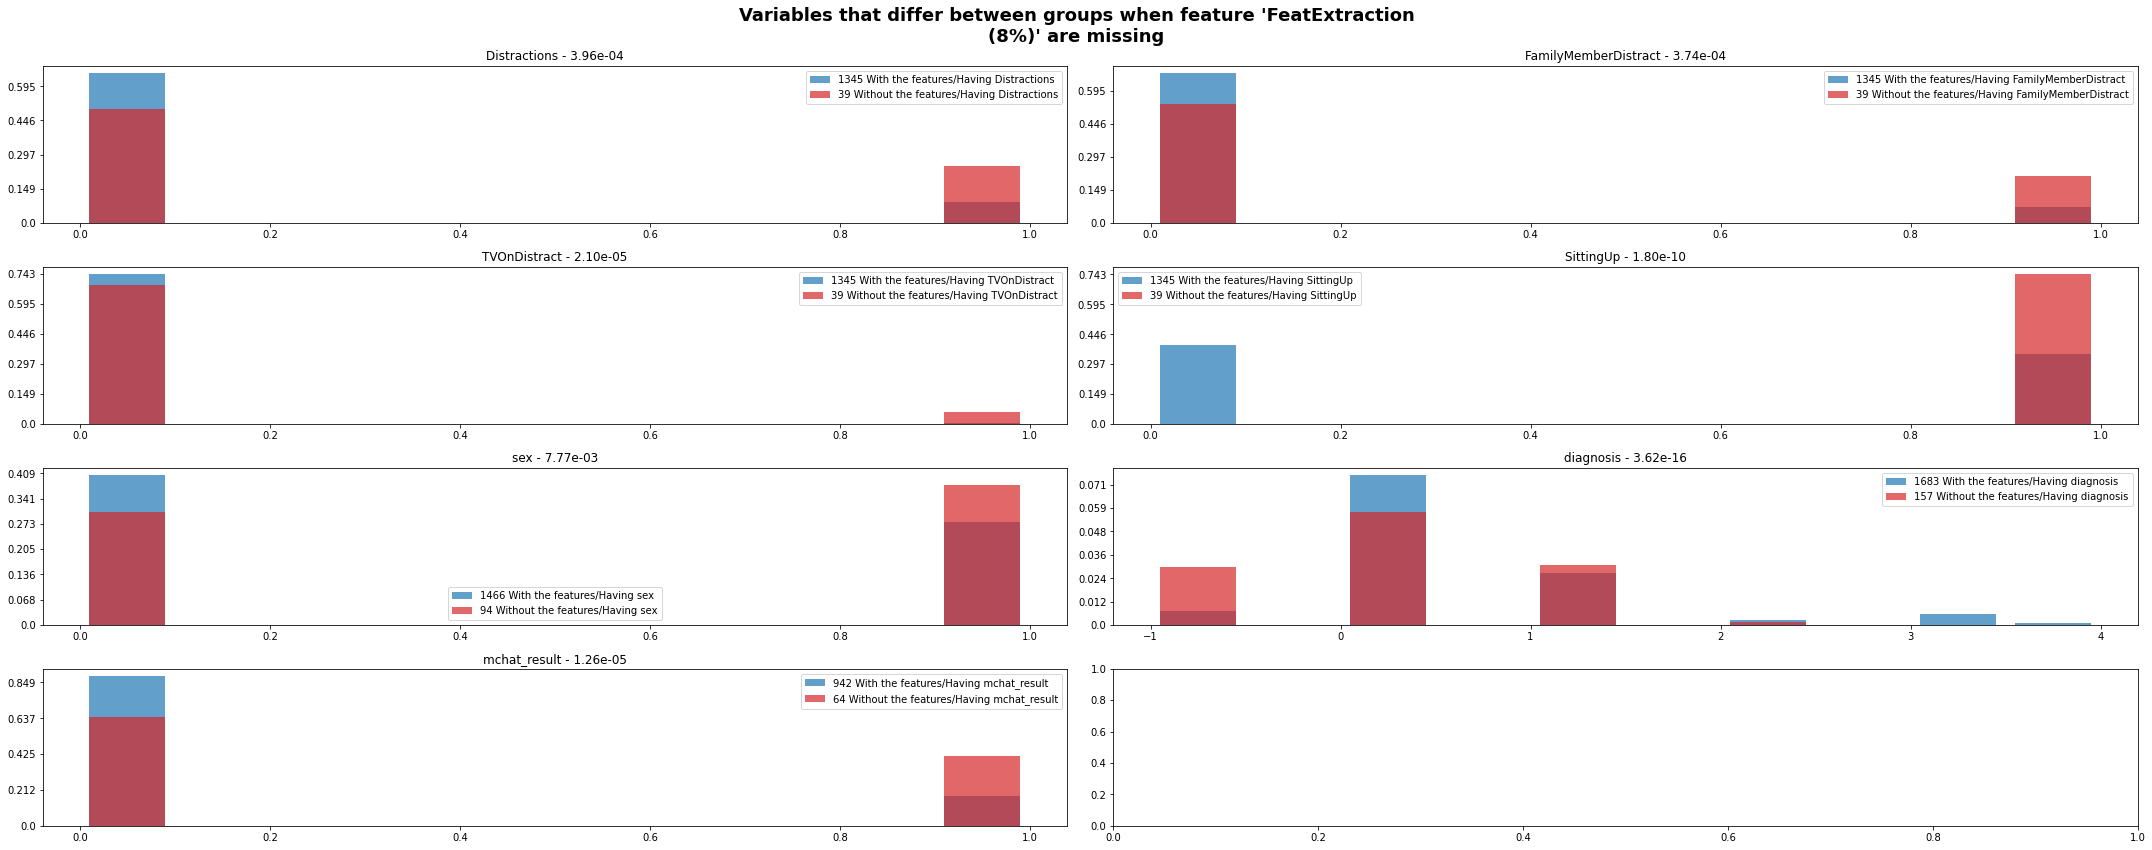

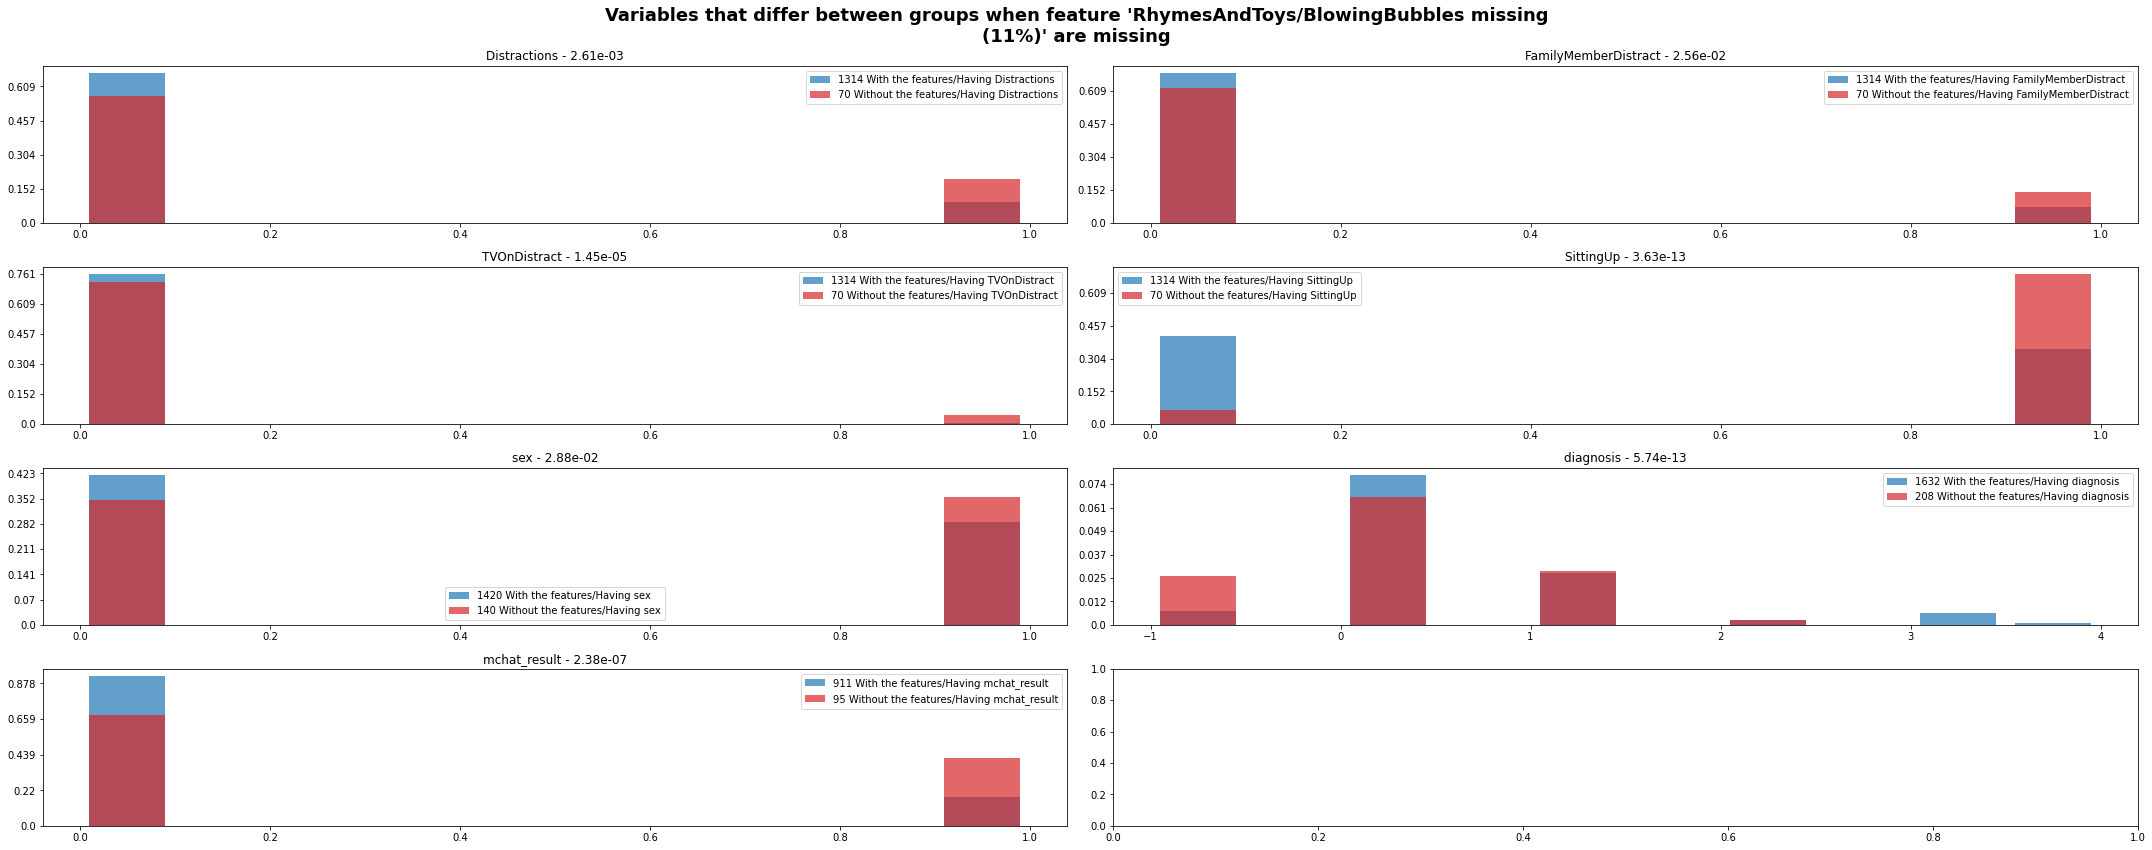

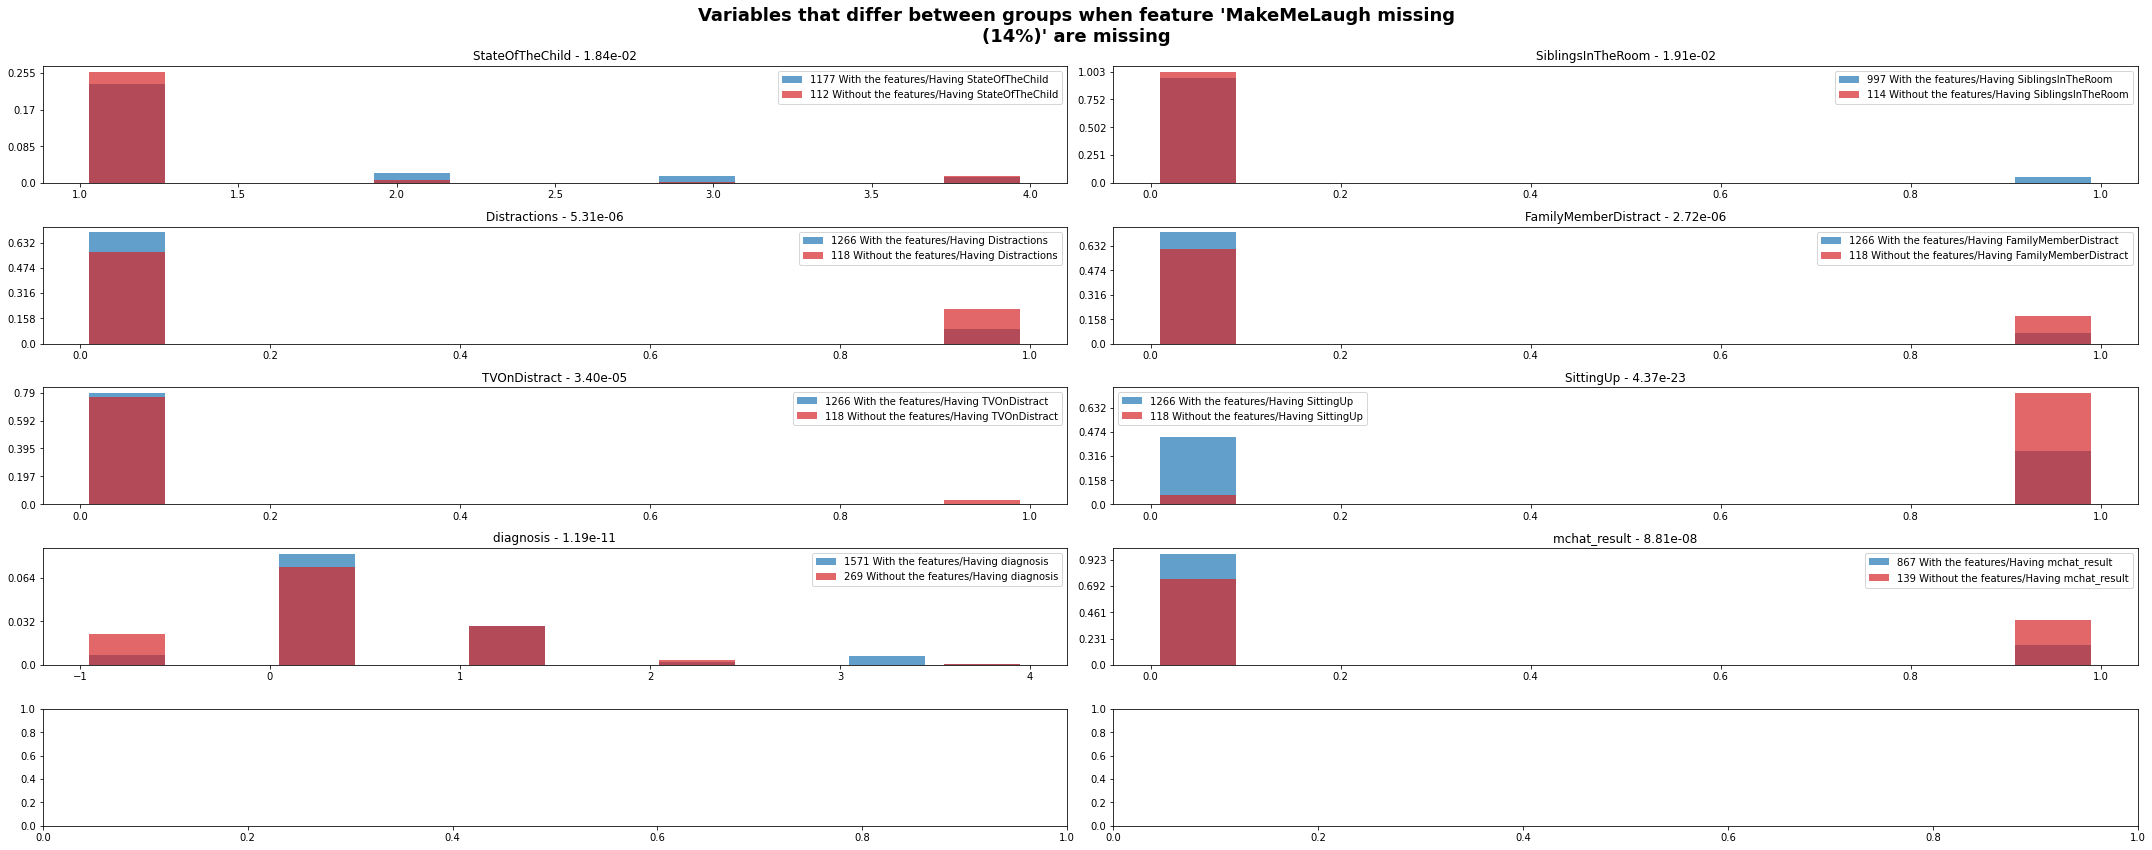

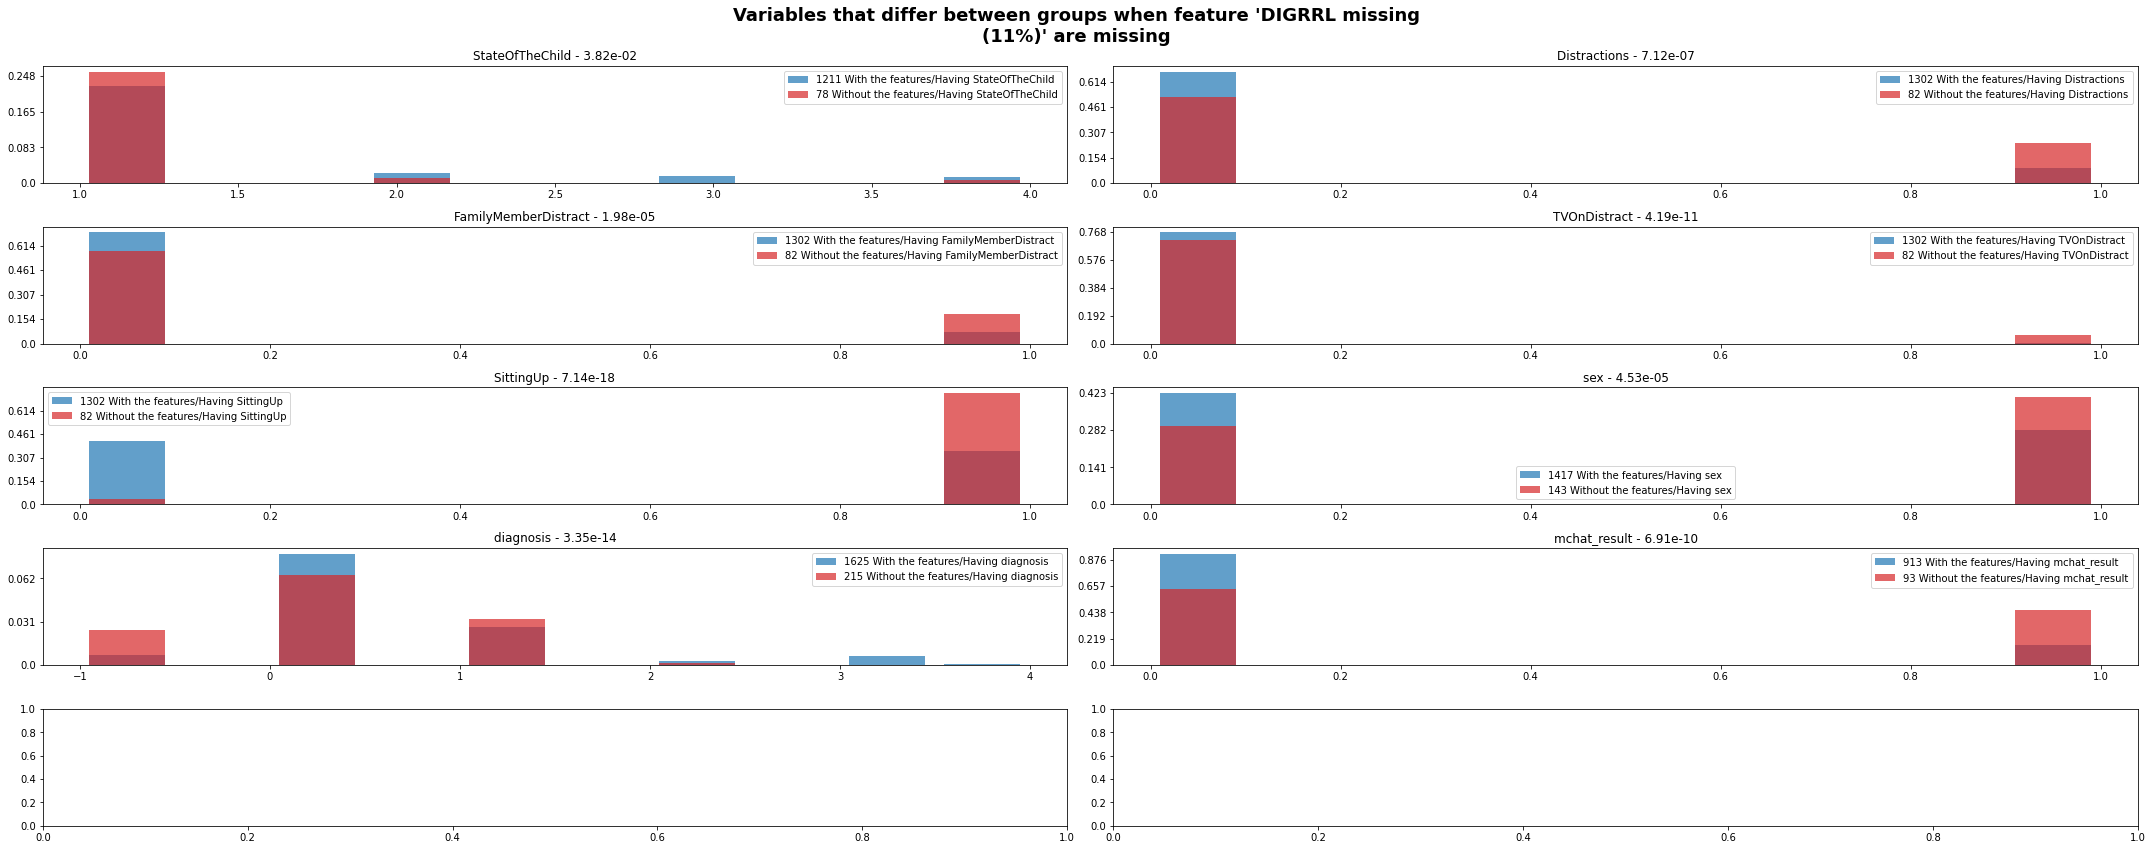

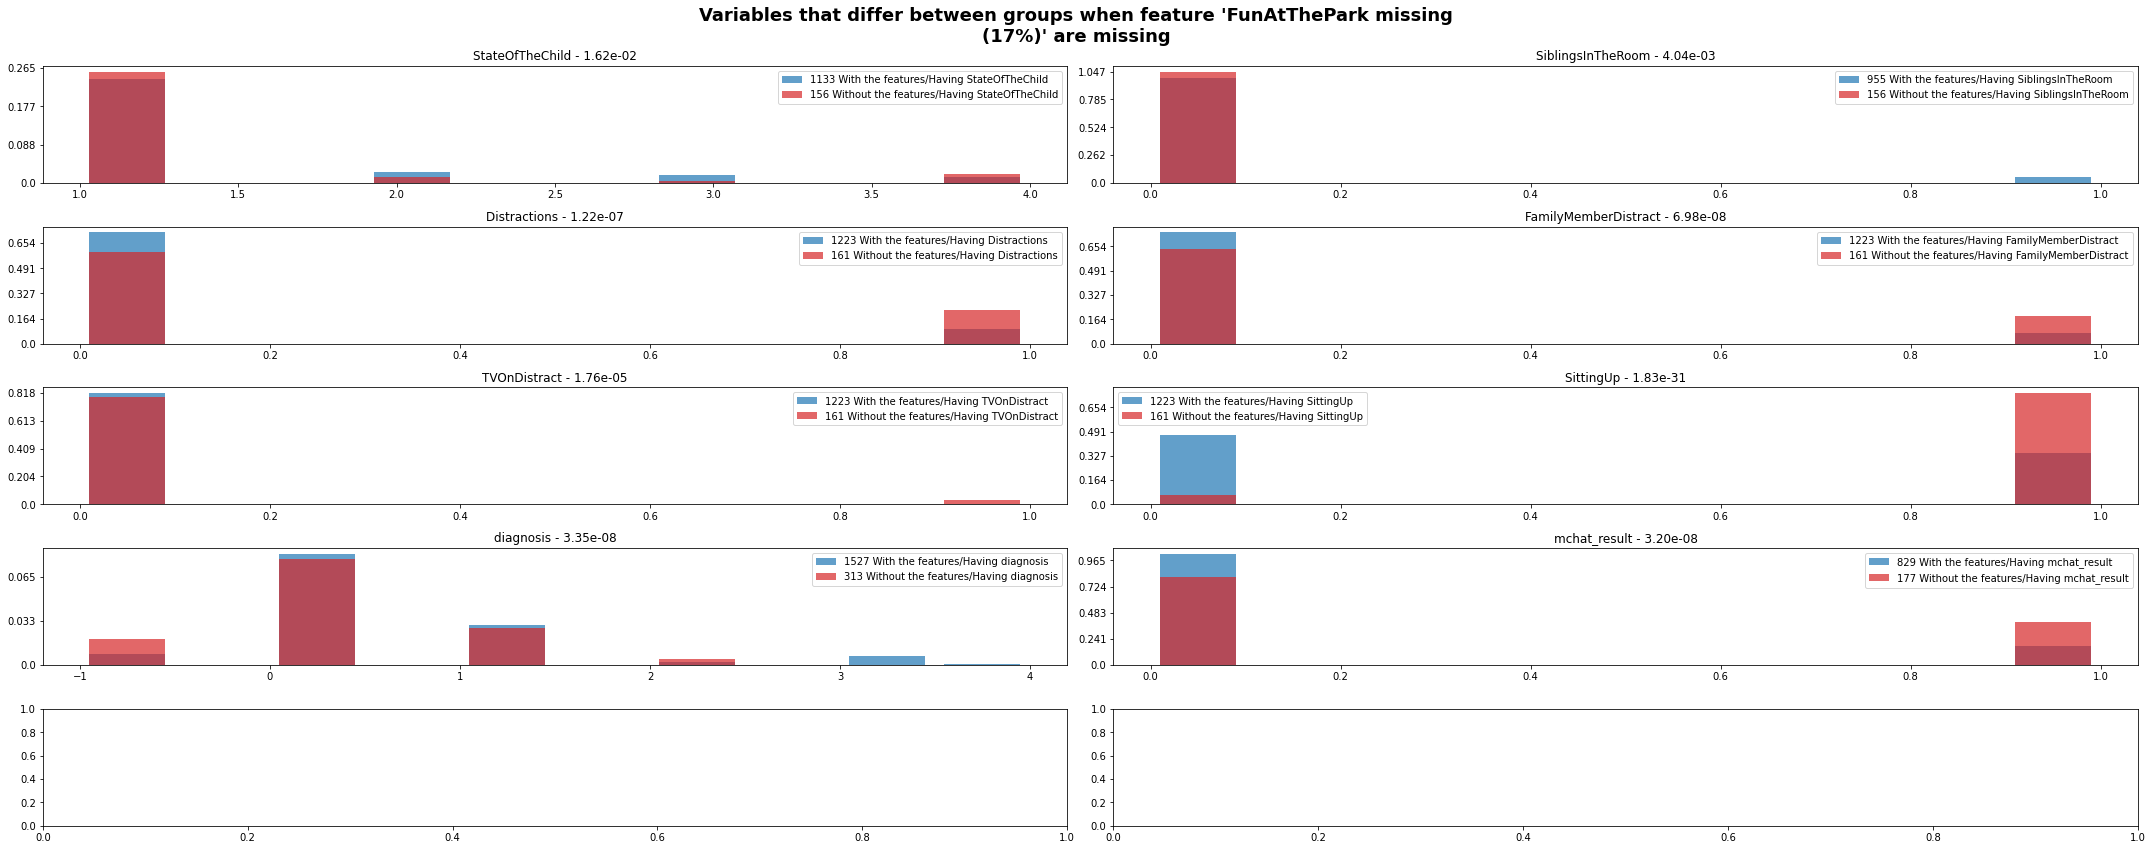

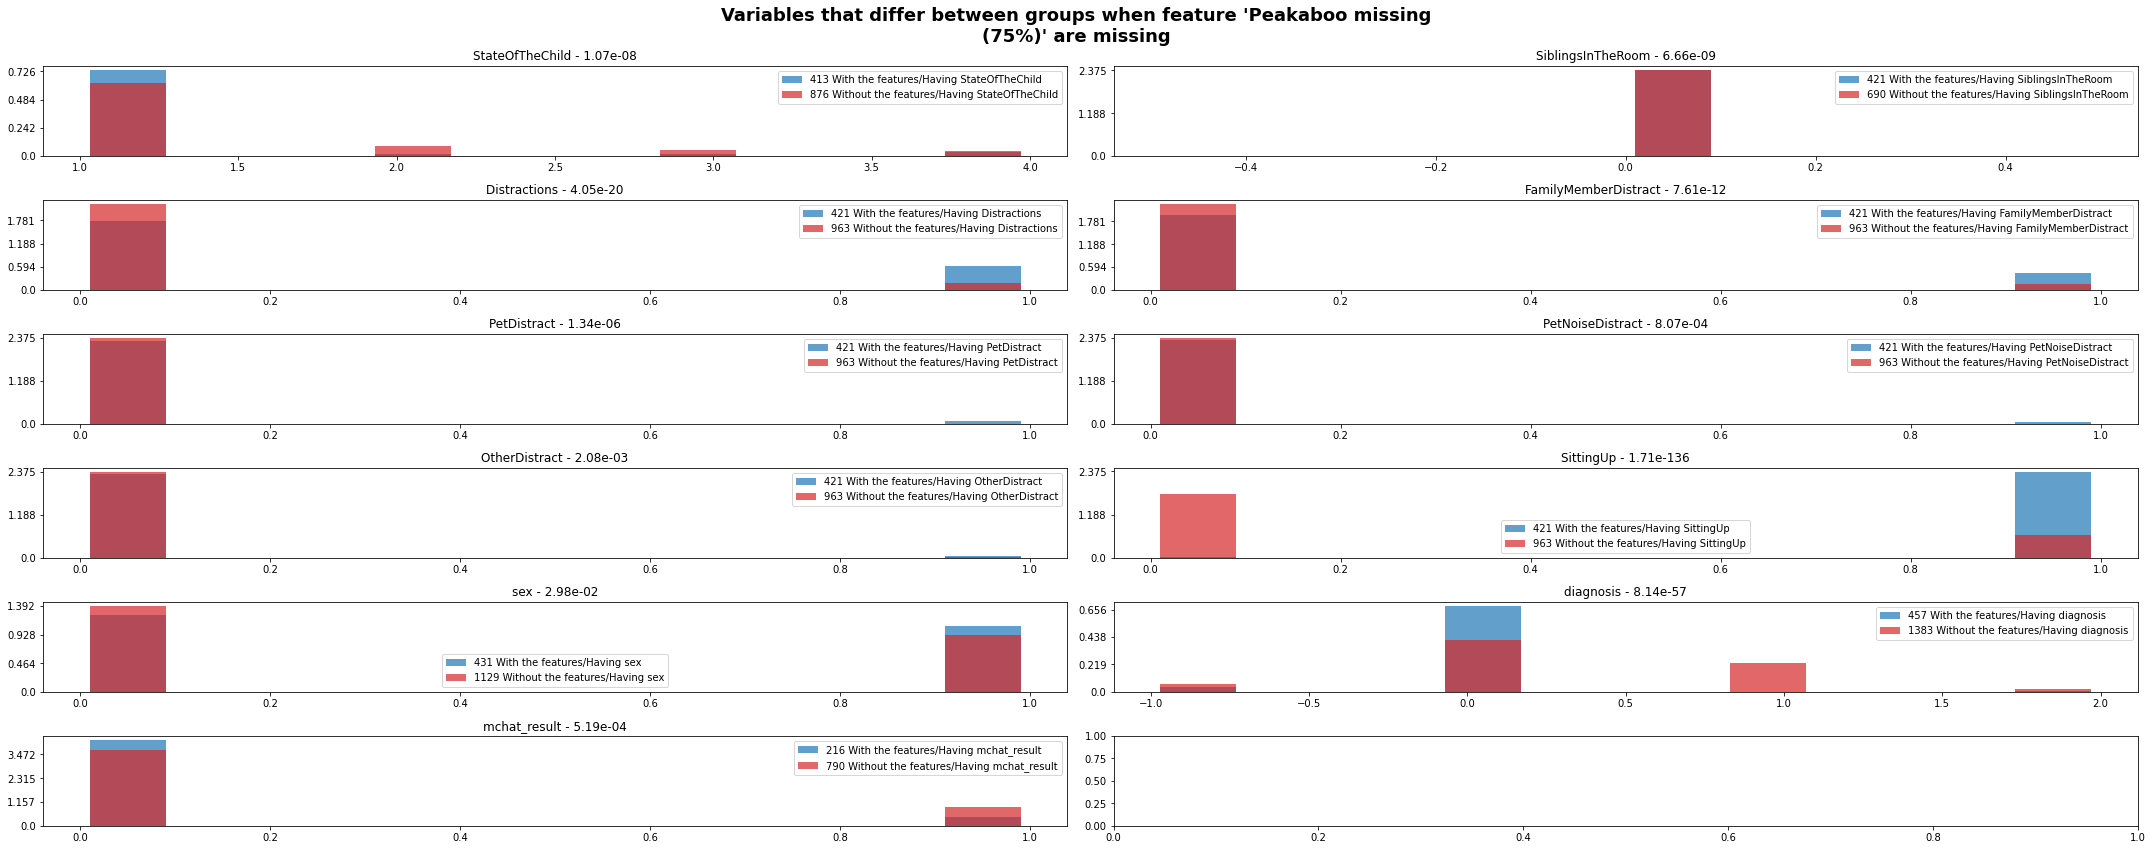

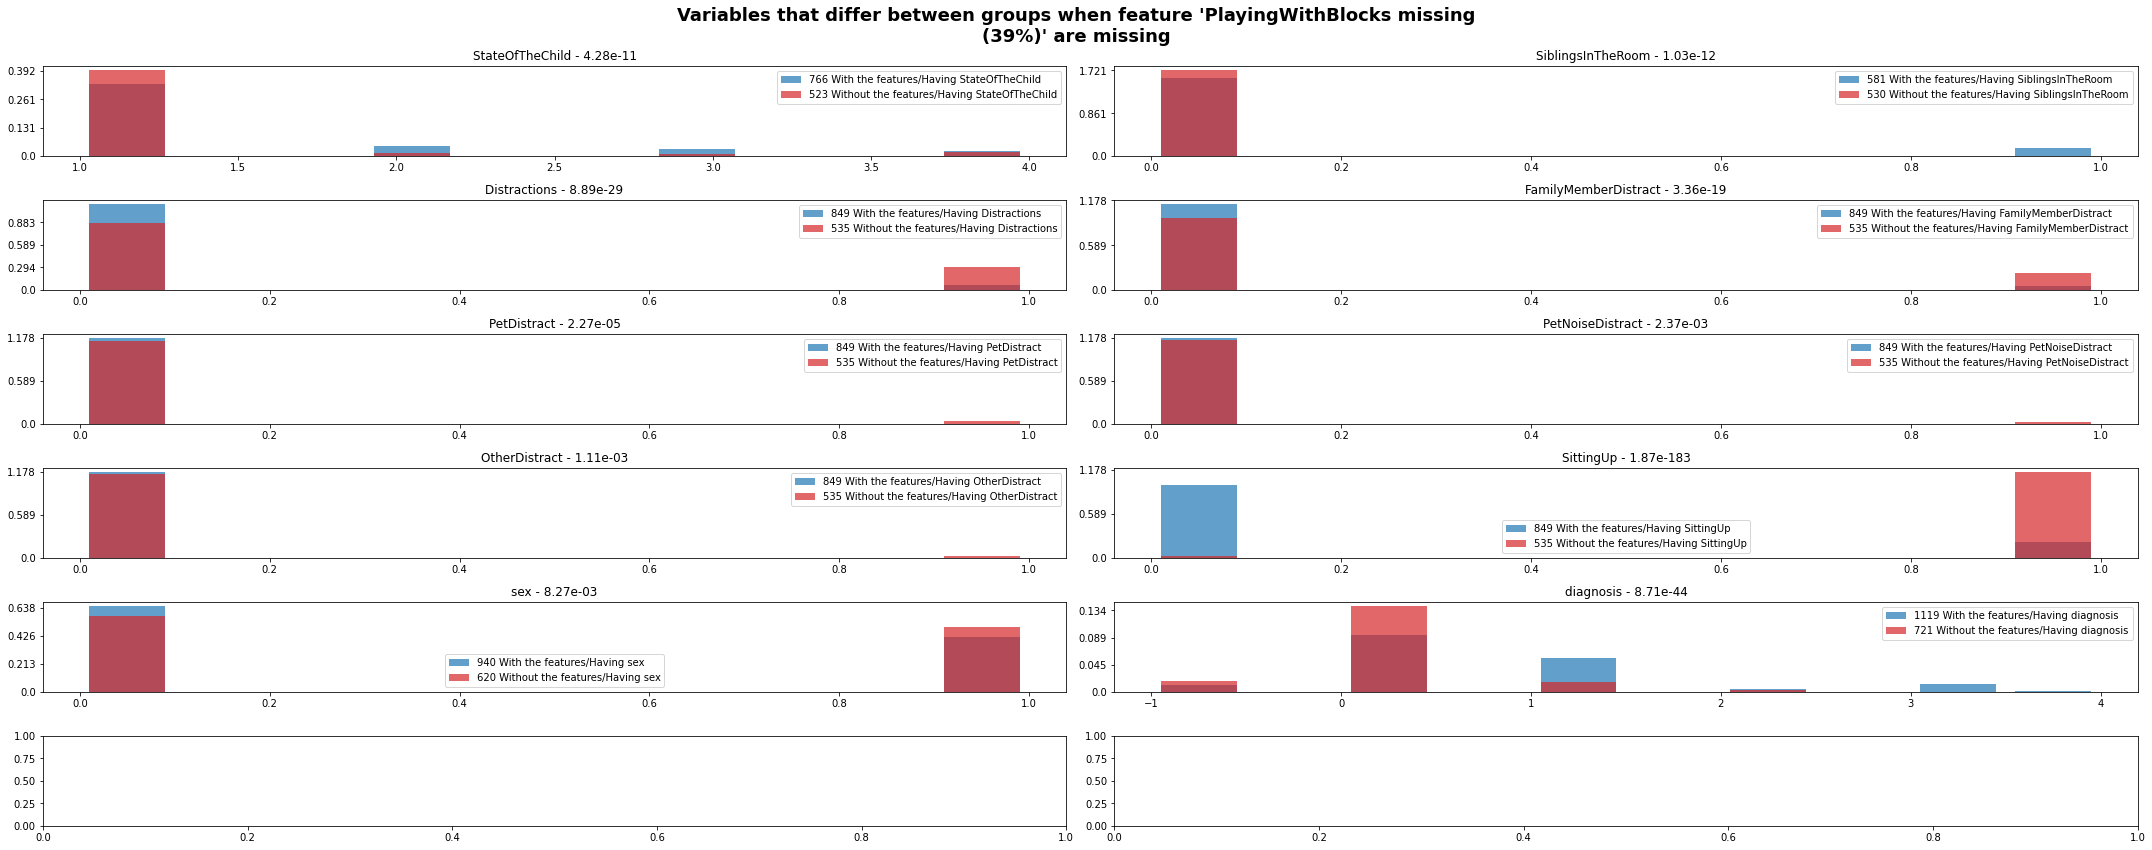

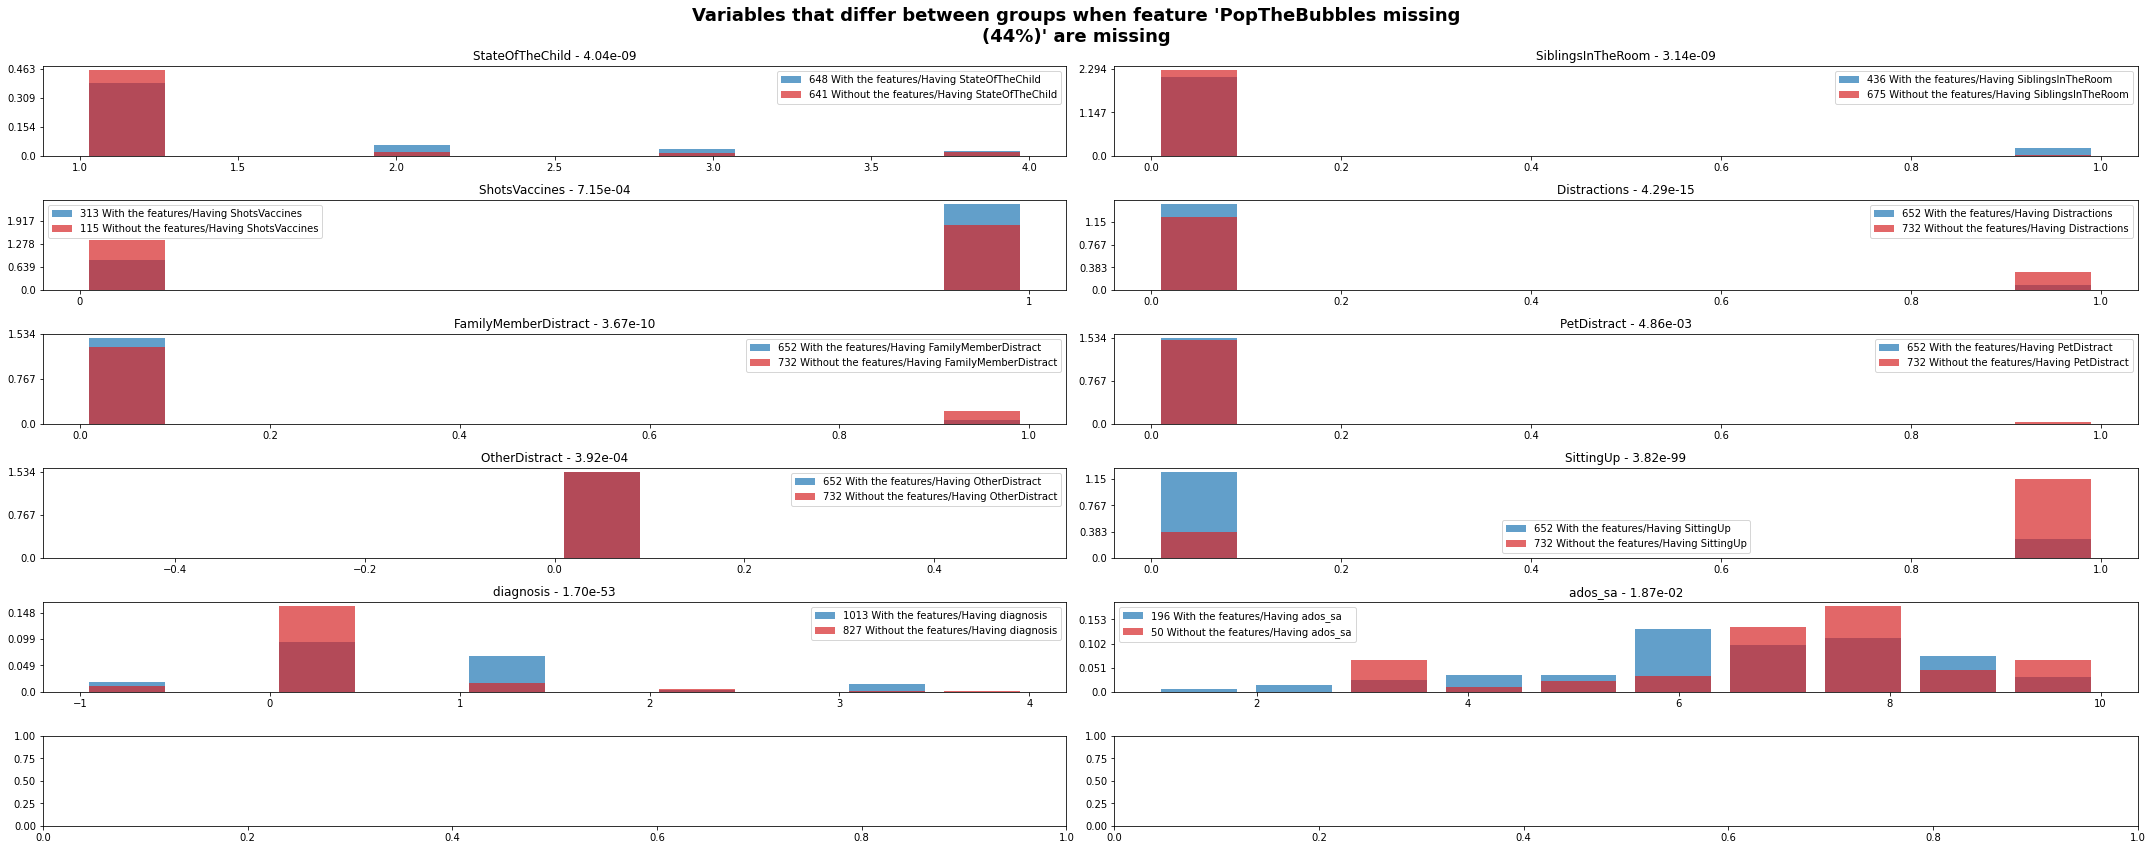

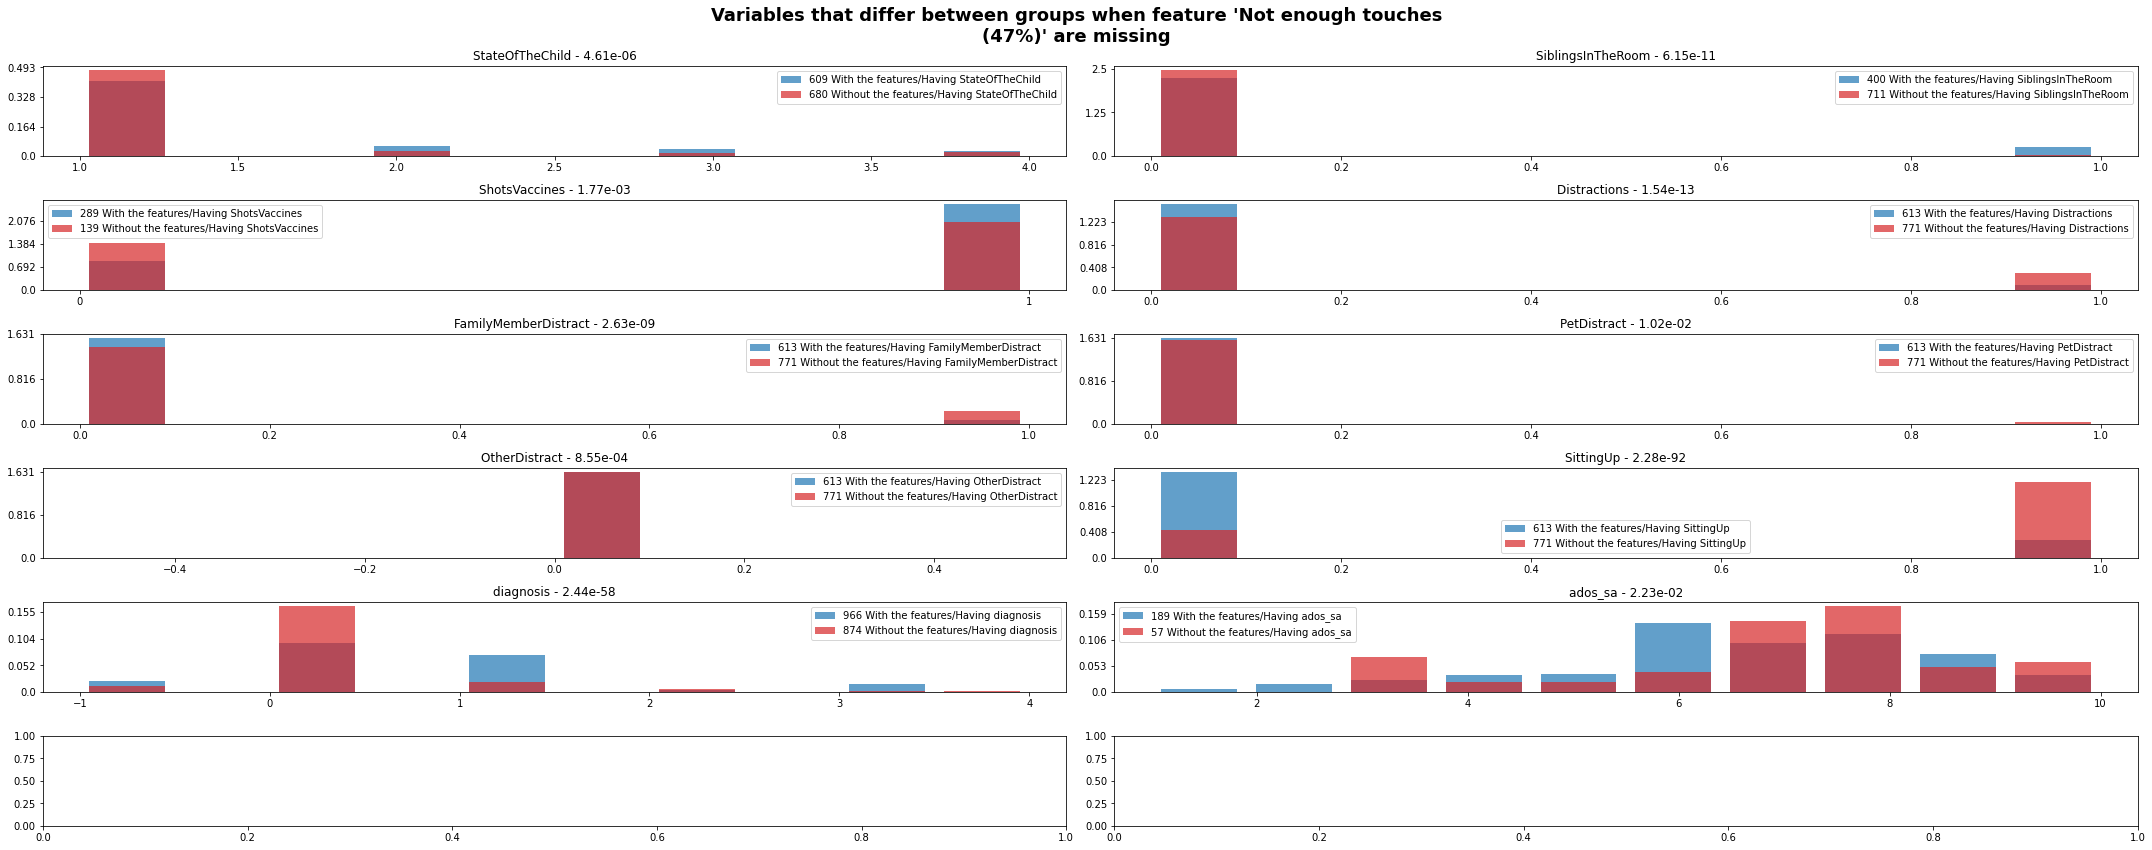

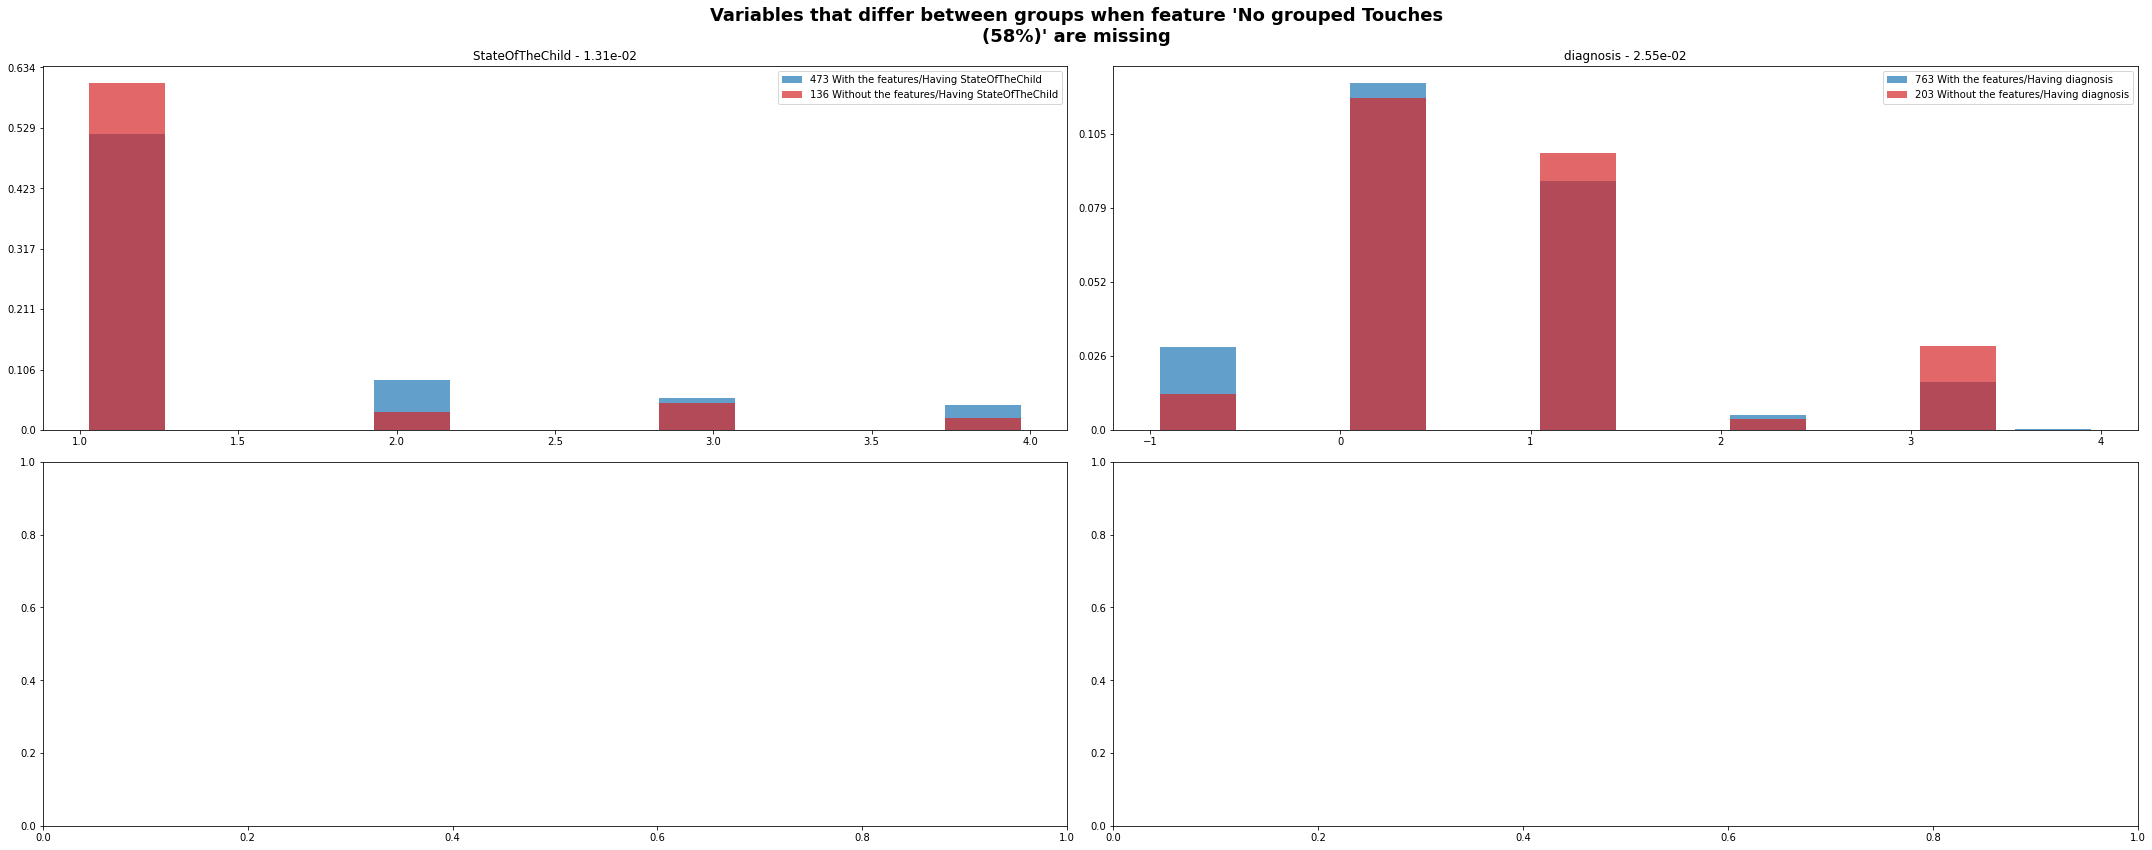

In [47]:
mask  = (mcar_matrix<0.05).astype(int)

locations = [(index, column) for index in mask.index for column in mask.columns if mask.loc[index, column]==1]
for i, row in mask.transpose().iterrows():
    
    variables_with_interactions = list(row[row==1].index)
    n_plot = len(variables_with_interactions)
    if n_plot==0:
        continue

    fig, axes = plt.subplots(n_plot//2+1, 2, figsize=(30, 12));axes = axes.flatten()
    fig.suptitle("Variables that differ between groups when feature '{}' are missing".format(grouped_features_label[i]), weight='bold', fontsize=18)
    for j, var in enumerate(variables_with_interactions):
        feats = grouped_features[i]
        
        d = data.df.copy()
        
        if i in dict_check_1_0.keys():
            for idx_group_that_should_be_there in dict_check_1_0[i]:
                d = d[d['Z_grouped_{}'.format(idx_group_that_should_be_there)]==0]
                
        
        having = d[d['Z_grouped_{}'.format(i)]==0][var].dropna()
        missing = d[d['Z_grouped_{}'.format(i)]==1][var].dropna()
        
        _, bins, _ = axes[j].hist(having,color='tab:blue',density=True, rwidth=.8, label='{} With the features/Having {}'.format(len(having), var), alpha=.7)
        axes[j].hist(missing, density=True, bins = bins, color='tab:red', rwidth=.8, label='{} Without the features/Having {}'.format(len(missing), var), alpha=.7)
        locs = axes[j].get_yticks(); axes[j].set_yticklabels(np.round(locs/len(having)*100,3))
        axes[j].set_title("{} - {:.2e}".format(var, mcar_matrix.loc[var, i]))
        axes[j].legend()
    plt.tight_layout();plt.show()

# Histogram of values of validity data columns


        # encode categorical variables
        df['diagnosis'].replace({'TD':0., 
                                'ASD':1., 
                                'DDLD':2., 
                                'ADHD':3.}, inplace = True)

        df['ethnicity'].replace({'Not Hispanic/Latino':0, 
                                'Hispanic/Latino':1, 
                                 'Unknown or not reported':np.nan}, inplace = True)

        df['race'].replace({'White':0., 
                    'White/Caucasian':0.,
                    'Black/African American':1., 
                    'More than one race':2.,
                    'American Indian/Alaskan Native':3.,
                    'Other':np.nan,
                    'Asian':np.nan,
                    'Unknown or not reported':np.nan,
                    'Unknown/Declined':np.nan,
                   }, inplace = True)

        df['sex'].replace({'M':0, 'F':1}, inplace=True)
        df['completed'].replace({'Complete (Do not readminister)':0, 'Partial (Do not readminister)':1, 'Incomplete (Readminister at next visit)':2}, inplace = True)

        df['StateOfTheChild'].replace({'In a calm and/or good mood':1, 'Slightly irritable':2, 'Somewhat distressed':3, 'Crying and/or tantrum':4}, inplace = True)
                

# Prediction of the missing variables

In [49]:
for i, feats in grouped_features.items():
    data.df['Z_grouped_{}'.format(i)] = 0
    data.df.loc[data.df.drop(index=data.df.dropna(subset=feats, how='all').index).index, 'Z_grouped_{}'.format(i)] = 1

dict_check_1_0 = {9:[8],
                 10:[8, 9]}

touch_features =  ['number_of_touches','average_length','std_length','average_error','std_error','number_of_target','pop_rate',
 'average_touch_duration','std_touch_duration','average_delay_to_pop','std_delay_to_pop','average_force_applied','std_force_applied',
 'average_accuracy_variation','accuracy_consistency','average_touches_per_target', 'std_touches_per_target','average_time_spent','std_time_spent','exploratory_percentage']

RhymesAndToys/BlowingBubbles missing
(11%) 1840 79


AUROC  AUC-PR  AUC-PR-Gain  AUC-PR-Corrected  AUC-PR-Gain-Corrected  F1 score (2 PPVxTPR/(PPV+TPR))  F1 score Corrected  Accuracy  Matthews correlation coefficient (MCC)  Sensitivity, recall, hit rate, or true positive rate (TPR)  Specificity, selectivity or true negative rate (TNR)  Precision or positive predictive value (PPV)  Negative predictive value (NPV)  Miss rate or false negative rate (FNR)  False discovery rate (FDR=1-PPV)  False omission rate (FOR=1-NPV)
0    1.0   0.996          1.0             0.983                    1.0                           0.986               0.955     0.996                                   0.981                                              0.981                                                       0.998                                            0.986                            0.998                                   0.019                             0.014                            0.002

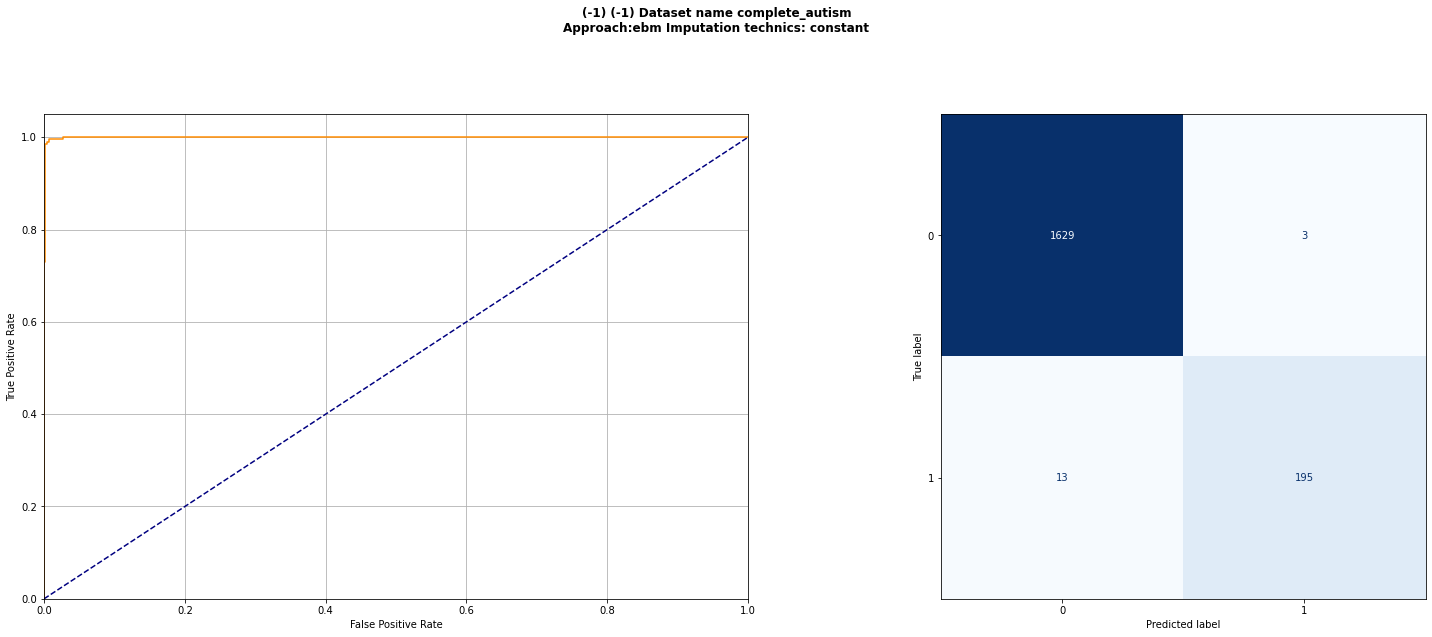

<!-- http://127.0.0.1:7491/140319718951312/ -->

<!-- http://127.0.0.1:7491/140320015520016/ -->

MakeMeLaugh missing
(14%) 1840 83


AUROC  AUC-PR  AUC-PR-Gain  AUC-PR-Corrected  AUC-PR-Gain-Corrected  F1 score (2 PPVxTPR/(PPV+TPR))  F1 score Corrected  Accuracy  Matthews correlation coefficient (MCC)  Sensitivity, recall, hit rate, or true positive rate (TPR)  Specificity, selectivity or true negative rate (TNR)  Precision or positive predictive value (PPV)  Negative predictive value (NPV)  Miss rate or false negative rate (FNR)  False discovery rate (FDR=1-PPV)  False omission rate (FOR=1-NPV)
0  0.999   0.994          1.0             0.977                    1.0                           0.972                0.95     0.991                                   0.965                                              0.952                                                       0.998                                            0.988                            0.992                                   0.048                             0.012                            0.008

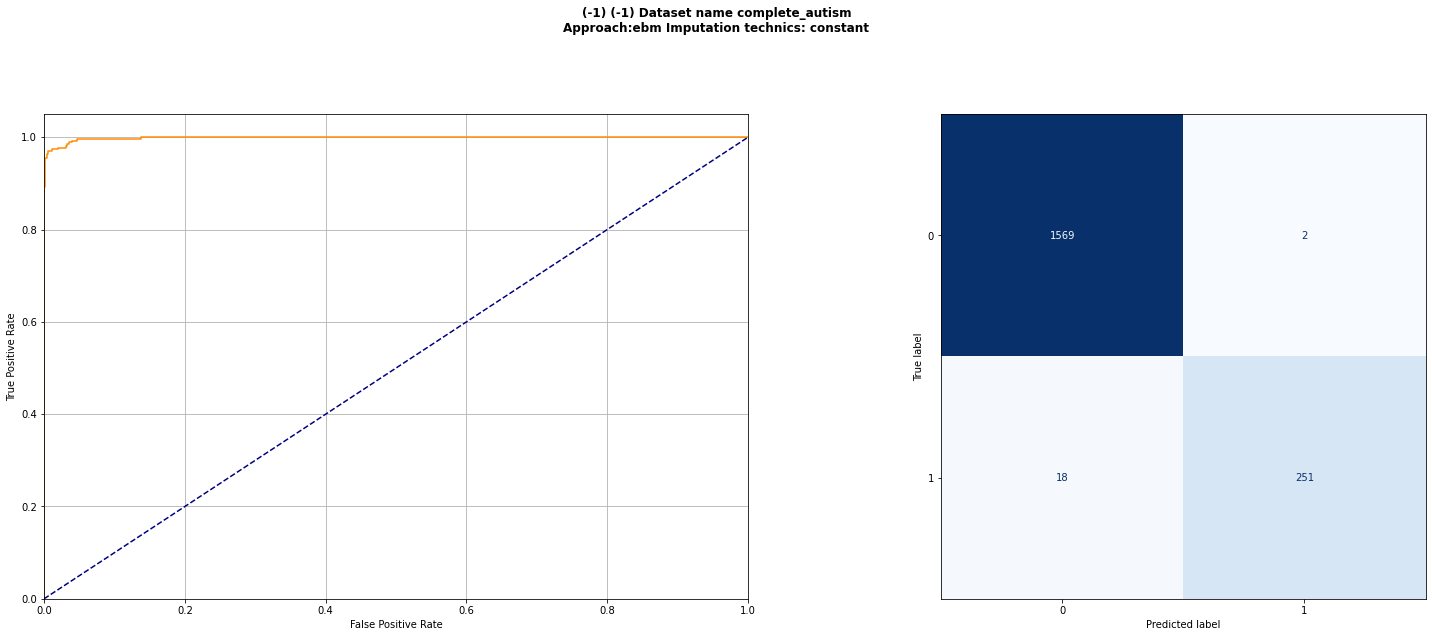

<!-- http://127.0.0.1:7491/140320009890448/ -->

<!-- http://127.0.0.1:7491/140319777566352/ -->

DIGRRL missing
(11%) 1840 83


AUROC  AUC-PR  AUC-PR-Gain  AUC-PR-Corrected  AUC-PR-Gain-Corrected  F1 score (2 PPVxTPR/(PPV+TPR))  F1 score Corrected  Accuracy  Matthews correlation coefficient (MCC)  Sensitivity, recall, hit rate, or true positive rate (TPR)  Specificity, selectivity or true negative rate (TNR)  Precision or positive predictive value (PPV)  Negative predictive value (NPV)  Miss rate or false negative rate (FNR)  False discovery rate (FDR=1-PPV)  False omission rate (FOR=1-NPV)
0  0.999   0.994          1.0             0.977                    1.0                           0.957               0.951     0.989                                   0.949                                              0.977                                                       0.991                                            0.933                            0.997                                   0.023                             0.067                            0.003

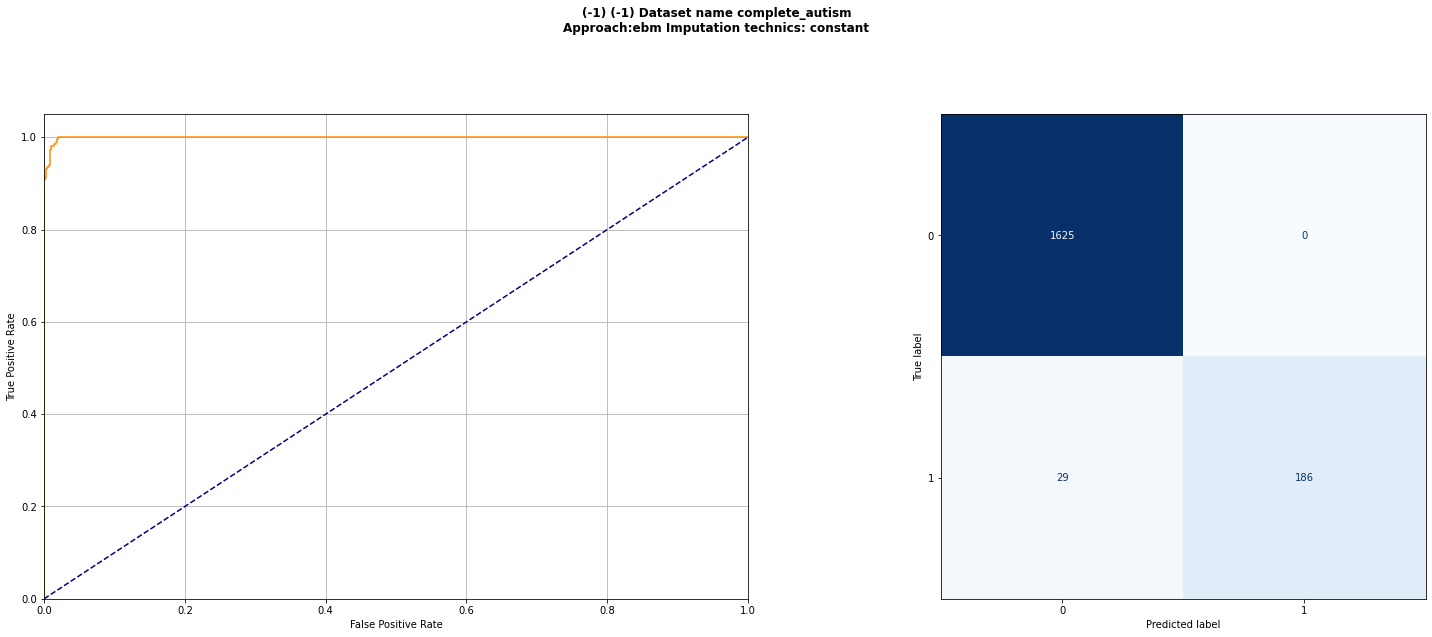

<!-- http://127.0.0.1:7491/140320283891408/ -->

<!-- http://127.0.0.1:7491/140319984279952/ -->

FunAtThePark missing
(17%) 1840 81


AUROC  AUC-PR  AUC-PR-Gain  AUC-PR-Corrected  AUC-PR-Gain-Corrected  F1 score (2 PPVxTPR/(PPV+TPR))  F1 score Corrected  Accuracy  Matthews correlation coefficient (MCC)  Sensitivity, recall, hit rate, or true positive rate (TPR)  Specificity, selectivity or true negative rate (TNR)  Precision or positive predictive value (PPV)  Negative predictive value (NPV)  Miss rate or false negative rate (FNR)  False discovery rate (FDR=1-PPV)  False omission rate (FOR=1-NPV)
0  0.998   0.992          1.0             0.945                    1.0                           0.959               0.882     0.985                                   0.948                                              0.962                                                        0.99                                            0.953                            0.992                                   0.038                             0.047                            0.008

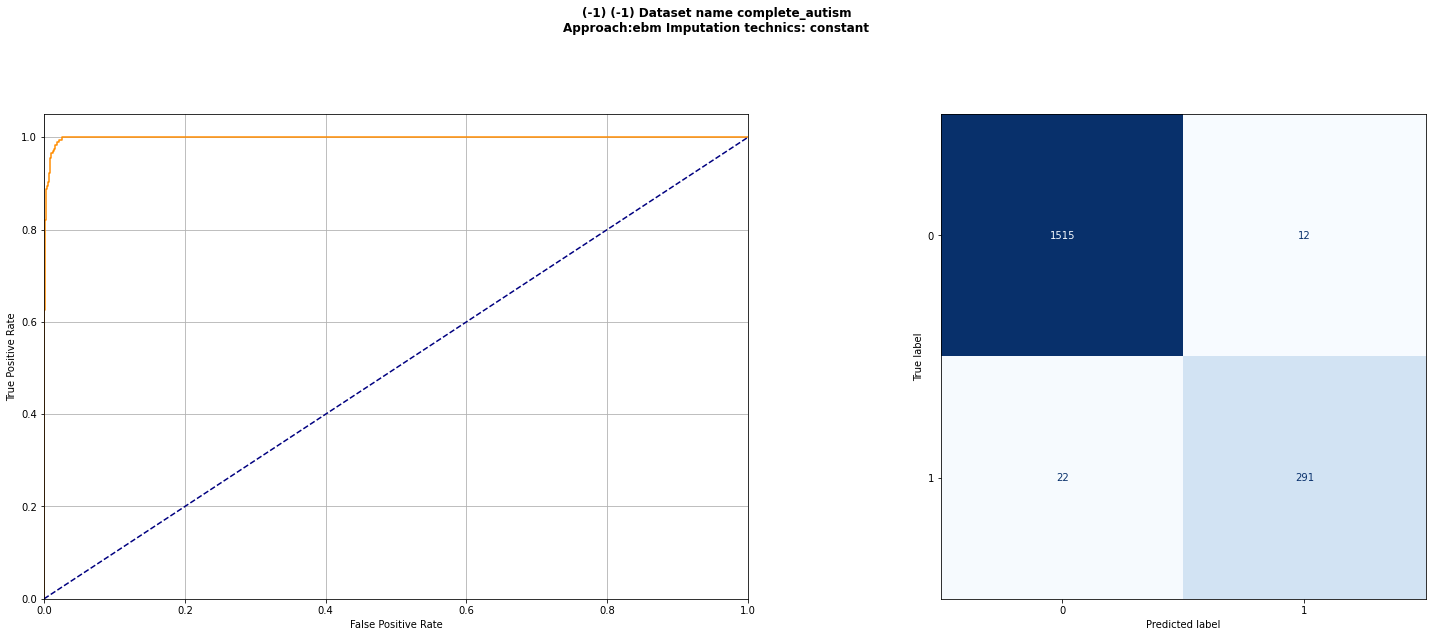

<!-- http://127.0.0.1:7491/140320285854032/ -->

<!-- http://127.0.0.1:7491/140320280738640/ -->

Peakaboo missing
(75%) 1840 83


AUROC  AUC-PR  AUC-PR-Gain  AUC-PR-Corrected  AUC-PR-Gain-Corrected  F1 score (2 PPVxTPR/(PPV+TPR))  F1 score Corrected  Accuracy  Matthews correlation coefficient (MCC)  Sensitivity, recall, hit rate, or true positive rate (TPR)  Specificity, selectivity or true negative rate (TNR)  Precision or positive predictive value (PPV)  Negative predictive value (NPV)  Miss rate or false negative rate (FNR)  False discovery rate (FDR=1-PPV)  False omission rate (FOR=1-NPV)
0    1.0     1.0          1.0               1.0                    1.0                             1.0               0.999     0.999                                   0.997                                              0.999                                                       0.998                                            0.999                            0.998                                   0.001                             0.001                            0.002

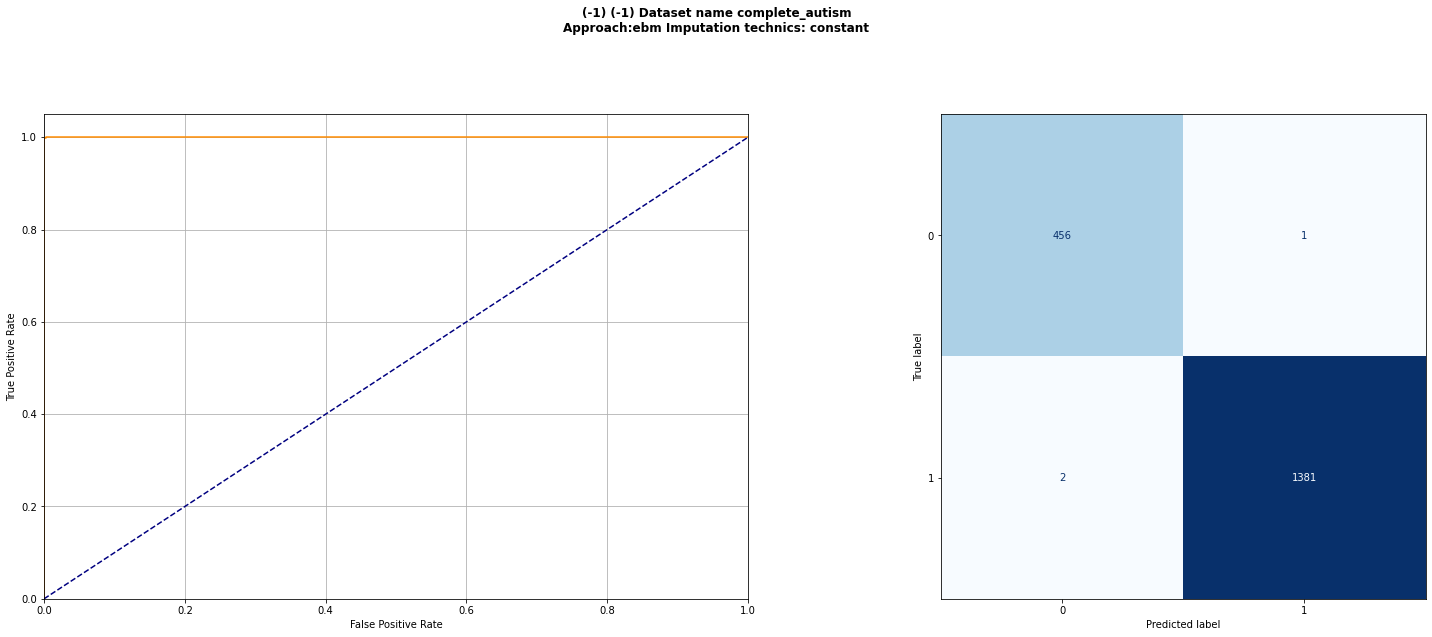

<!-- http://127.0.0.1:7491/140319979696080/ -->

<!-- http://127.0.0.1:7491/140319483534736/ -->

PlayingWithBlocks missing
(39%) 1840 83


AUROC  AUC-PR  AUC-PR-Gain  AUC-PR-Corrected  AUC-PR-Gain-Corrected  F1 score (2 PPVxTPR/(PPV+TPR))  F1 score Corrected  Accuracy  Matthews correlation coefficient (MCC)  Sensitivity, recall, hit rate, or true positive rate (TPR)  Specificity, selectivity or true negative rate (TNR)  Precision or positive predictive value (PPV)  Negative predictive value (NPV)  Miss rate or false negative rate (FNR)  False discovery rate (FDR=1-PPV)  False omission rate (FOR=1-NPV)
0    1.0     1.0          1.0               1.0                    1.0                             1.0                 1.0     0.999                                   0.999                                              0.999                                                         1.0                                              1.0                            0.999                                   0.001                               0.0                            0.001

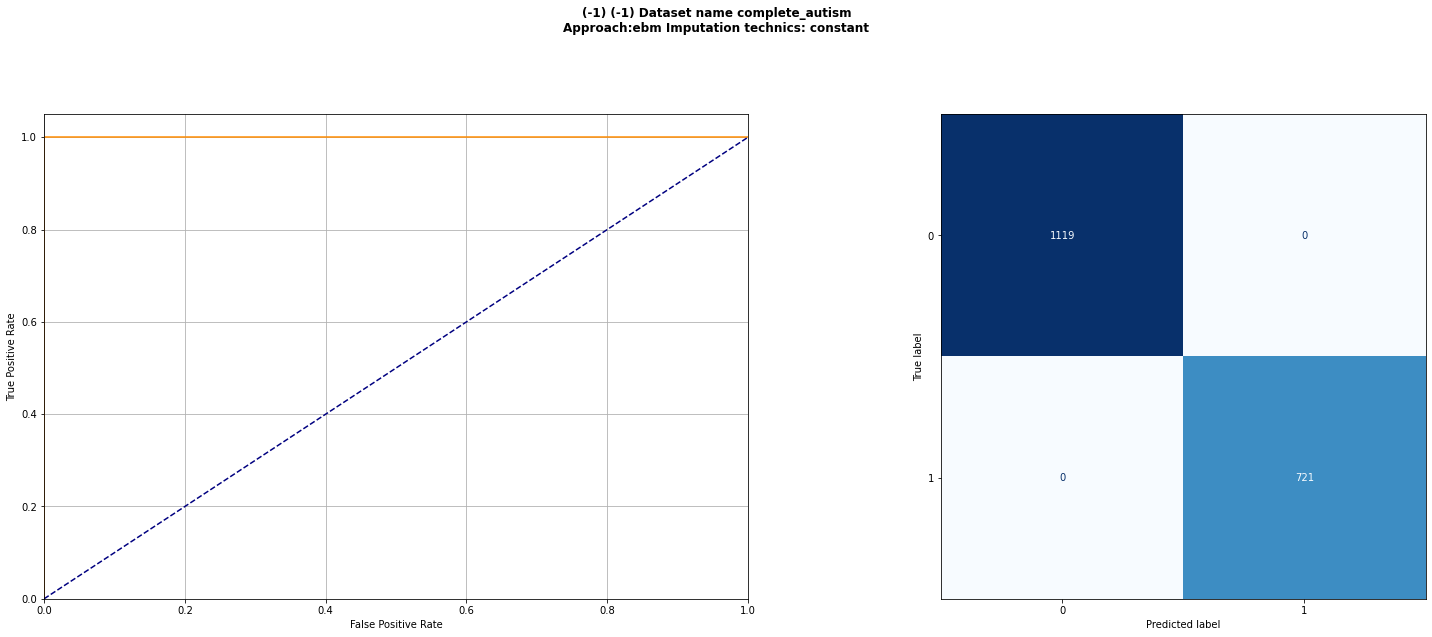

<!-- http://127.0.0.1:7491/140320310834320/ -->

<!-- http://127.0.0.1:7491/140320029795920/ -->

PopTheBubbles missing
(44%) 1840 82


AUROC  AUC-PR  AUC-PR-Gain  AUC-PR-Corrected  AUC-PR-Gain-Corrected  F1 score (2 PPVxTPR/(PPV+TPR))  F1 score Corrected  Accuracy  Matthews correlation coefficient (MCC)  Sensitivity, recall, hit rate, or true positive rate (TPR)  Specificity, selectivity or true negative rate (TNR)  Precision or positive predictive value (PPV)  Negative predictive value (NPV)  Miss rate or false negative rate (FNR)  False discovery rate (FDR=1-PPV)  False omission rate (FOR=1-NPV)
0    1.0     1.0          1.0             0.999                    1.0                           0.998               0.998     0.998                                   0.996                                              0.996                                                       0.999                                            0.999                            0.997                                   0.004                             0.001                            0.003

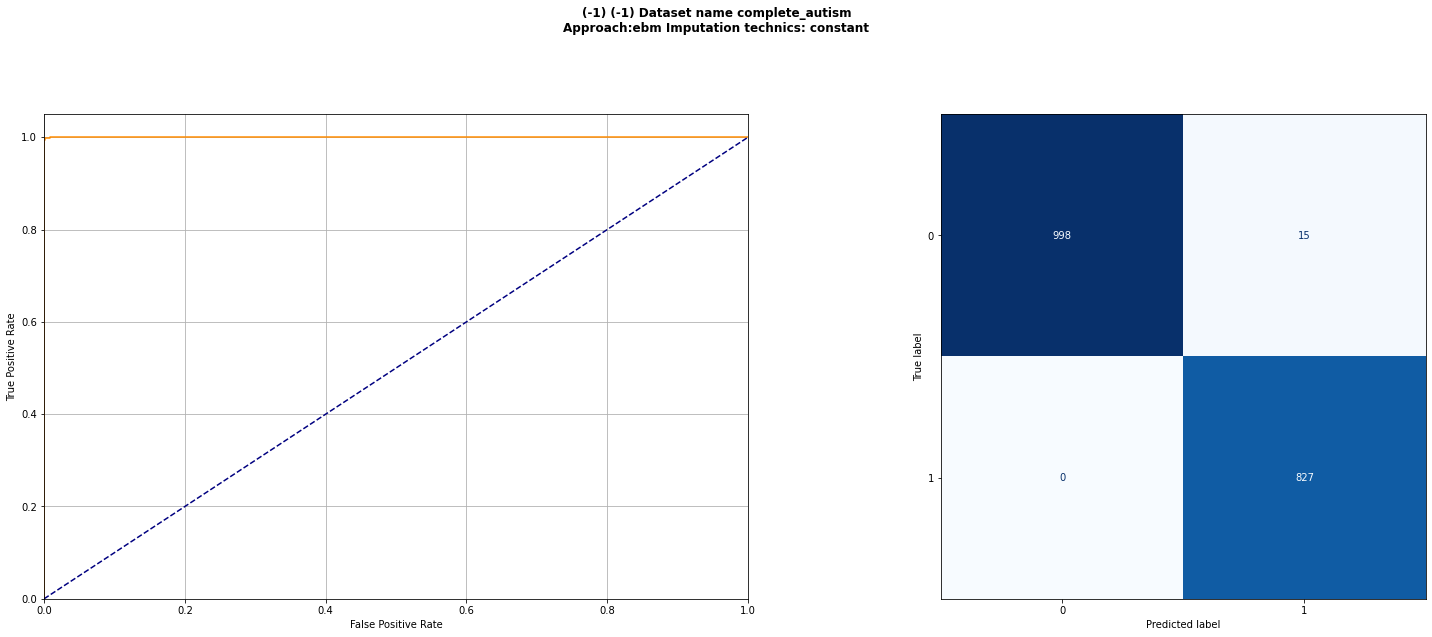

<!-- http://127.0.0.1:7491/140320274811408/ -->

<!-- http://127.0.0.1:7491/140320330665040/ -->

Not enough touches
(47%) 1840 65


AUROC  AUC-PR  AUC-PR-Gain  AUC-PR-Corrected  AUC-PR-Gain-Corrected  F1 score (2 PPVxTPR/(PPV+TPR))  F1 score Corrected  Accuracy  Matthews correlation coefficient (MCC)  Sensitivity, recall, hit rate, or true positive rate (TPR)  Specificity, selectivity or true negative rate (TNR)  Precision or positive predictive value (PPV)  Negative predictive value (NPV)  Miss rate or false negative rate (FNR)  False discovery rate (FDR=1-PPV)  False omission rate (FOR=1-NPV)
0  0.993   0.994        0.993             0.944                    1.0                           0.967               0.928     0.967                                   0.935                                              0.975                                                       0.961                                            0.957                            0.977                                   0.025                             0.043                            0.023

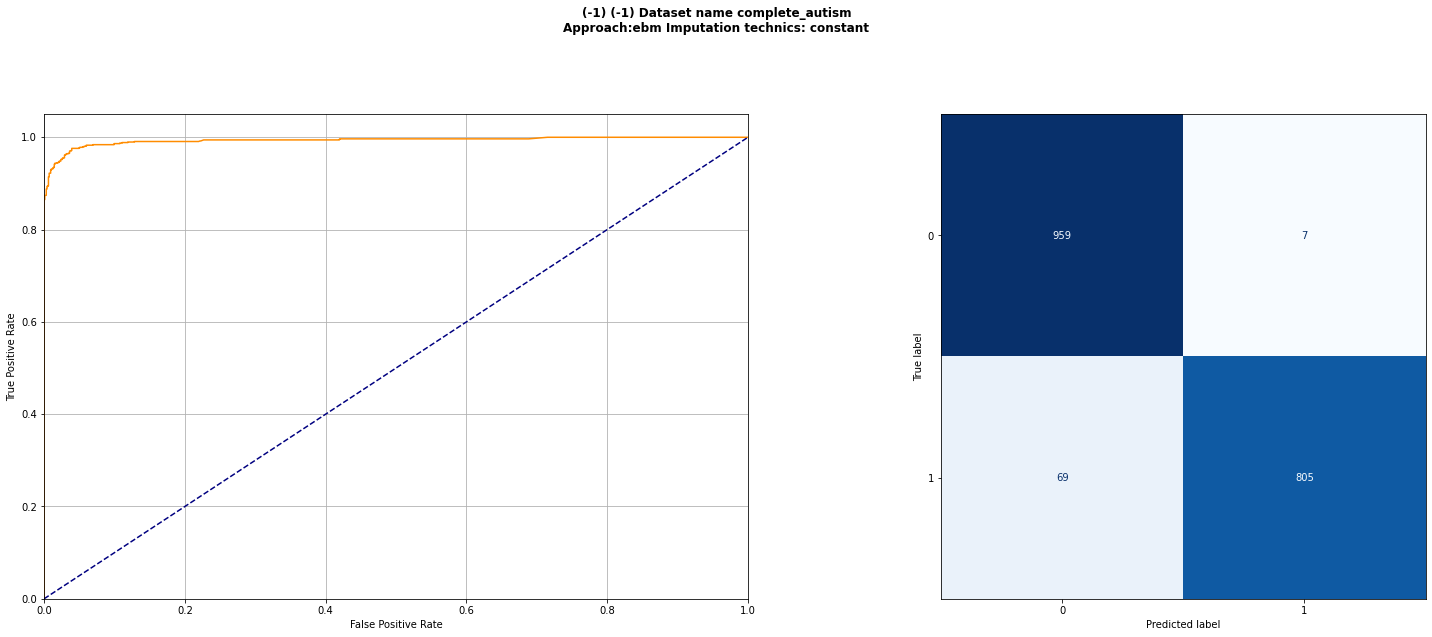

<!-- http://127.0.0.1:7491/140319483240720/ -->

<!-- http://127.0.0.1:7491/140318077273552/ -->

No grouped Touches
(58%) 763 65


TypeError: 'NoneType' object is not subscriptable

In [52]:
from interpret import show

for idx_grouped_missing_features, missing_feats in grouped_features.items():
    if idx_grouped_missing_features==0:
        continue

    #df = pd.read_csv("/home01/sam/df_all.csv")
    df = pd.read_csv("/Users/samperochon/Duke/work/notes_on_stats/df_all.csv")
    
    for i, feats in grouped_features.items():
        df['Z_grouped_{}'.format(i)] = 0
        df.loc[df.drop(index=df.dropna(subset=missing_feats, how='all').index).index, 'Z_grouped_{}'.format(i)] = 1
    del i 
        
        
    d = df.copy()
        
    if idx_grouped_missing_features in dict_check_1_0.keys():
        for idx_group_that_should_be_there in dict_check_1_0[idx_grouped_missing_features]:
            d = d[d['Z_grouped_{}'.format(idx_group_that_should_be_there)]==0]


    features_name = [feat for feat in CVA_COLUMNS + CLINICAL_COLUMNS + VALIDITY_COLUMNS if (((idx_grouped_missing_features not in [8, 9, 10]) and (feat not in missing_feats)) or
                                                                                            ((idx_grouped_missing_features in [8, 9, 10]) and (feat not in touch_features)))]
    
    data = Dataset(df=d, 
                   use_missing_indicator_variables=False,
                   missing_data_handling='encoding', 
                   imputation_method='without', 
                   sampling_method='without',
                   outcome_column='Z_grouped_{}'.format(idx_grouped_missing_features),
                   features_name=features_name,
                   scenario=None,#'asd_td_age_matched_n_balanced',
                   verbosity=0, 
                   proportion_train=1)
    data.filter(administration={'complete': True})
    
    print(grouped_features_label[idx_grouped_missing_features], len(data.df), data.X_train.shape[1])
    
    exp = Experiments(data.dataset_name,
                  dataset=data, 
                approach='ebm', 
                resolution=RESOLUTION, 
                bandwidth=BANDWIDTH, 
                previous_experiment=None,        
                verbosity=1, 
                debug=True, 
                save_experiment=False)
    
    exp.fit_predict()
    exp.plot()

    ebm_local = exp.model.explain_local(data.X_train, data.y_train)
    show(ebm_local)

FunAtThePark missing
(17%) 1840 81


AUROC  AUC-PR  AUC-PR-Gain  AUC-PR-Corrected  AUC-PR-Gain-Corrected  F1 score (2 PPVxTPR/(PPV+TPR))  F1 score Corrected  Accuracy  Matthews correlation coefficient (MCC)  Sensitivity, recall, hit rate, or true positive rate (TPR)  Specificity, selectivity or true negative rate (TNR)  Precision or positive predictive value (PPV)  Negative predictive value (NPV)  Miss rate or false negative rate (FNR)  False discovery rate (FDR=1-PPV)  False omission rate (FOR=1-NPV)
0  0.998   0.992          1.0             0.945                    1.0                           0.959               0.882     0.985                                   0.948                                              0.962                                                        0.99                                            0.953                            0.992                                   0.038                             0.047                            0.008

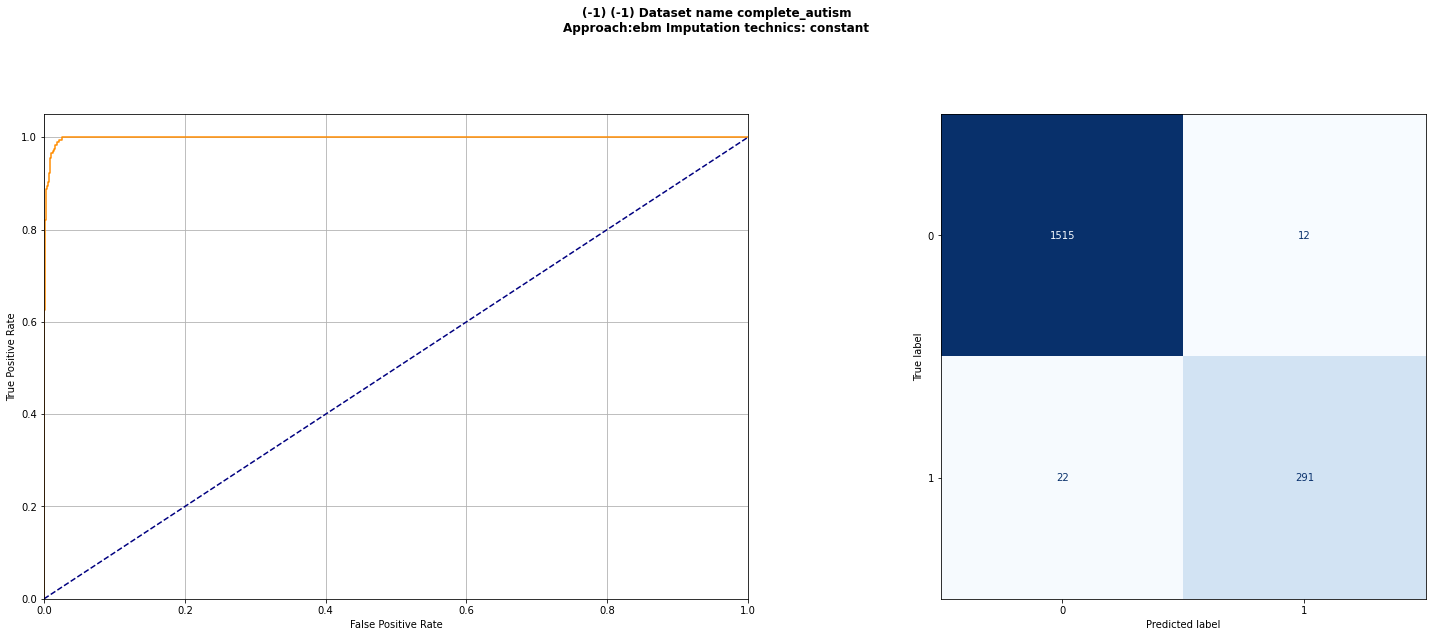

<!-- http://127.0.0.1:7491/140320026972624/ -->

<!-- http://127.0.0.1:7491/140319772570256/ -->

In [56]:
idx_grouped_missing_features = 4
missing_feats = ['FP_gaze_speech_correlation',
  'FP_gaze_silhouette_score',
  'FP_postural_sway',
  'FP_postural_sway_derivative']

#df = pd.read_csv("/home01/sam/df_all.csv")
df = pd.read_csv("/Users/samperochon/Duke/work/notes_on_stats/df_all.csv")

for i, feats in grouped_features.items():
    df['Z_grouped_{}'.format(i)] = 0
    df.loc[df.drop(index=df.dropna(subset=missing_feats, how='all').index).index, 'Z_grouped_{}'.format(i)] = 1
del i 


d = df.copy()

if idx_grouped_missing_features in dict_check_1_0.keys():
    for idx_group_that_should_be_there in dict_check_1_0[idx_grouped_missing_features]:
        d = d[d['Z_grouped_{}'.format(idx_group_that_should_be_there)]==0]


features_name = [feat for feat in CVA_COLUMNS + CLINICAL_COLUMNS + VALIDITY_COLUMNS if (((idx_grouped_missing_features not in [8, 9, 10]) and (feat not in missing_feats)) or
                                                                                        ((idx_grouped_missing_features in [8, 9, 10]) and (feat not in touch_features)))]

data = Dataset(df=d, 
               use_missing_indicator_variables=False,
               missing_data_handling='encoding', 
               imputation_method='without', 
               sampling_method='without',
               outcome_column='Z_grouped_{}'.format(idx_grouped_missing_features),
               features_name=features_name,
               scenario=None,#'asd_td_age_matched_n_balanced',
               verbosity=0, 
               proportion_train=1)
data.filter(administration={'complete': True})

print(grouped_features_label[idx_grouped_missing_features], len(data.df), data.X_train.shape[1])

exp = Experiments(data.dataset_name,
              dataset=data, 
            approach='ebm', 
            resolution=RESOLUTION, 
            bandwidth=BANDWIDTH, 
            previous_experiment=None,        
            verbosity=1, 
            debug=True, 
            save_experiment=False)

exp.fit_predict()
exp.plot()


ebm_local = exp.model.explain_local(data.X_train, data.y_train)
show(ebm_local)

In [275]:
df = pd.read_csv("/Users/samperochon/Duke/work/notes_on_stats/df_all.csv")
data = Dataset(df=df, 
               use_missing_indicator_variables=False,
               missing_data_handling='encoding', 
               imputation_method='without', 
               sampling_method='without',
               outcome_column='diagnosis',#'Z_grouped_{}'.format(idx_grouped_missing_features),
               features_name=features_name,
               scenario=None,#'asd_td_age_matched_n_balanced',
               verbosity=0, 
               proportion_train=1)
data.filter(administration={'complete': True})

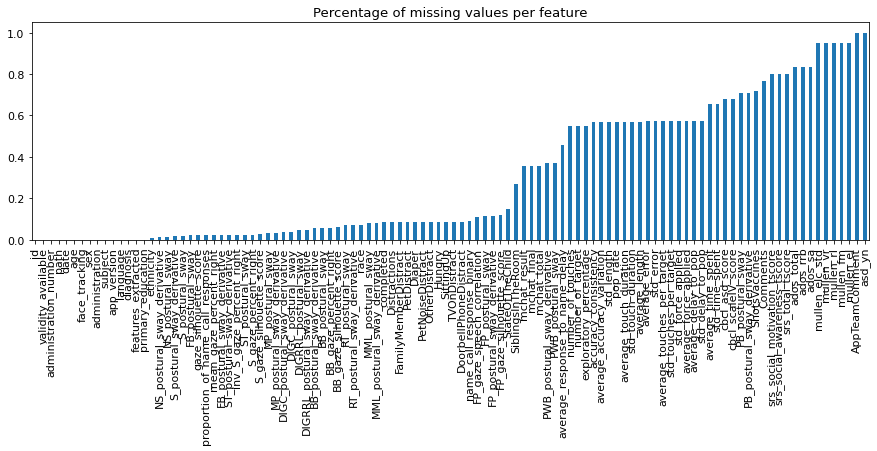

In [276]:
data.df.isna().mean().sort_values().plot(
    kind="bar", figsize=(15, 4),
    title="Percentage of missing values per feature");

# Building calibratedprobabilities

In [ ]:
from numpy import mean
from sklearn.datasets import make_classification
from sklearn.model_selection import cross_val_score
from sklearn.model_selection import RepeatedStratifiedKFold
from sklearn.calibration import CalibratedClassifierCV
from sklearn.svm import SVC
# generate dataset
X, y = make_classification(n_samples=10000, n_features=2, n_redundant=0,
	n_clusters_per_class=1, weights=[0.99], flip_y=0, random_state=4)
# define model
model = SVC(gamma='scale', class_weight='balanced')
# wrap the model
calibrated = CalibratedClassifierCV(model, method='isotonic', cv=3)
# define evaluation procedure
cv = RepeatedStratifiedKFold(n_splits=10, n_repeats=3, random_state=1)
# evaluate model
scores = cross_val_score(calibrated, X, y, scoring='roc_auc', cv=cv, n_jobs=-1)
# summarize performance
print('Mean ROC AUC: %.3f' % mean(scores))

# Description

# Dataset Illustration

In [101]:
#df = pd.read_csv("/home01/sam/df_all.csv")
df = pd.read_csv("/Users/samperochon/Duke/work/notes_on_stats/df_all.csv")
# Data definition
data = Dataset(df=df, 
               missing_data_handling='encoding',
               imputation_method='without',
               sampling_method='without',
               scenario = None, 
               features_name = DEFAULT_PREDICTORS,
               scale_data=True, 
               use_missing_indicator_variables=False,
               verbosity=0, 
               proportion_train=1)

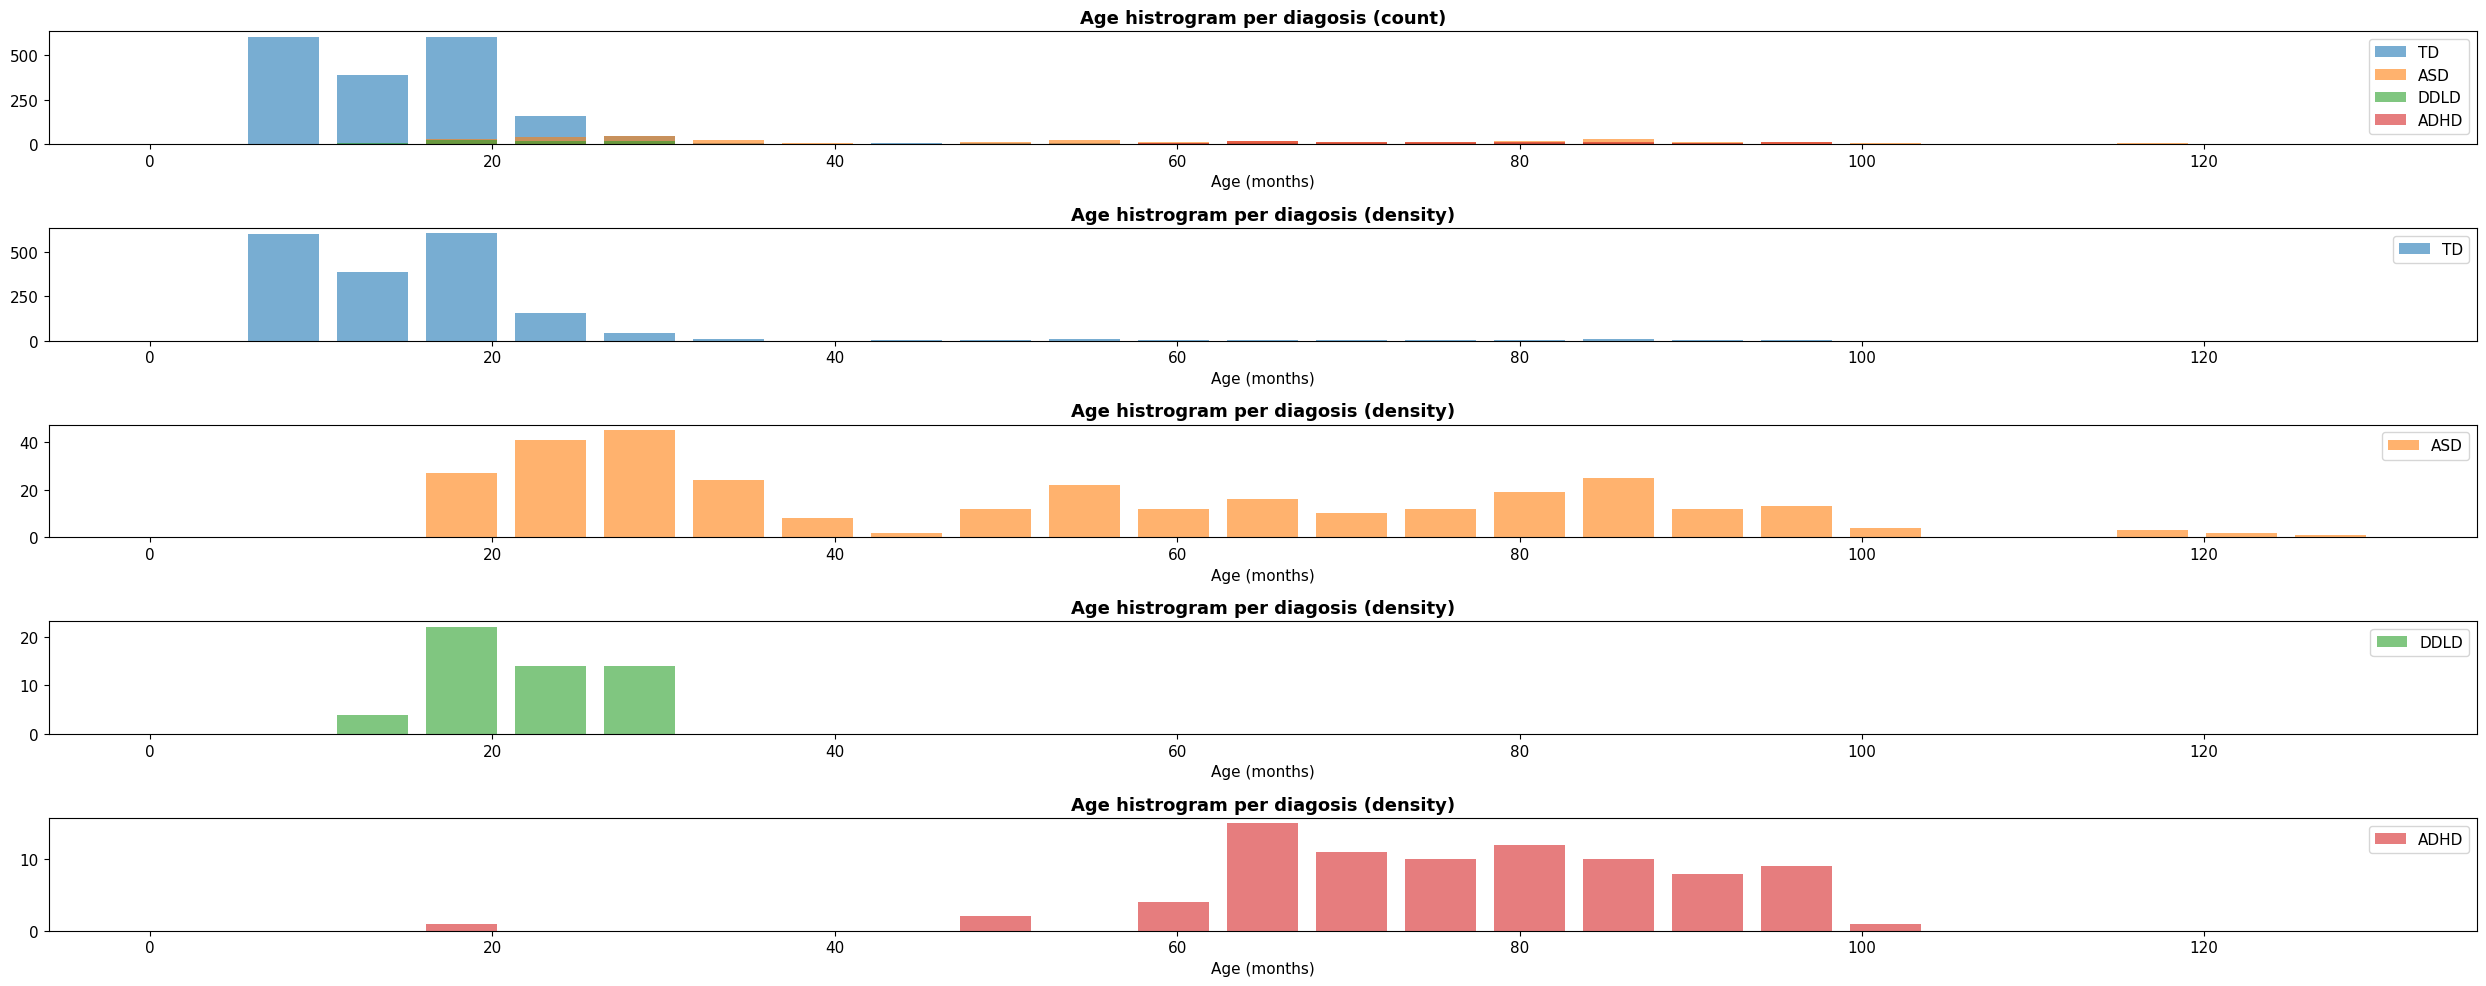

In [102]:
DIAG_DICT = {'TD':0., 
            'ASD':1., 
            'DDLD':2., 
            'ADHD':3.}
DIAG_DICT_REVERSE = {v: k for k, v in DIAG_DICT.items()}

colors = {'TD':'#1f77b4',
          'ASD': '#ff7f0e',
          'DDLD':'#2ca02c',
          'ADHD':'#d62728',
          'comorbid':'#9467bd'}
           
    
fig, axes = plt.subplots(5, 1, figsize=(25, 10)); axes=axes.flatten()

for i, d in df.groupby('diagnosis'):
    axes[0].hist(d['age'], bins=np.linspace(0, 130, 26), density=False, alpha=.6, rwidth=.8, color=colors[DIAG_DICT_REVERSE[i]], label=DIAG_DICT_REVERSE[i])
axes[0].legend(); axes[0].set_title("Age histrogram per diagosis (count)", weight='bold', fontsize=13); axes[0].set_xlabel("Age (months)")

for i, d in df.groupby('diagnosis'):
    axes[int(i+1)].hist(d['age'], bins=np.linspace(0, 130, 26), density=False, alpha=.6, rwidth=.8, color=colors[DIAG_DICT_REVERSE[i]], label=DIAG_DICT_REVERSE[i])
    axes[int(i+1)].legend(); axes[int(i+1)].set_title("Age histrogram per diagosis (density)", weight='bold', fontsize=13);axes[int(i+1)].set_xlabel("Age (months)")
plt.tight_layout()

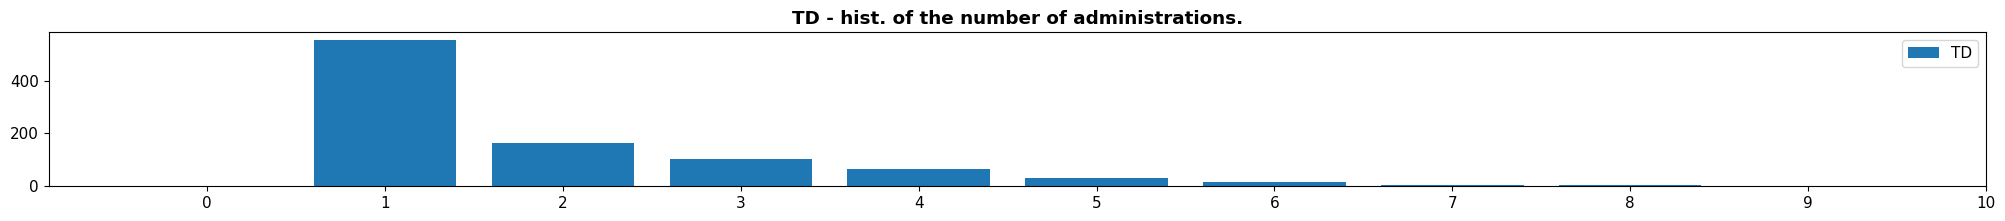

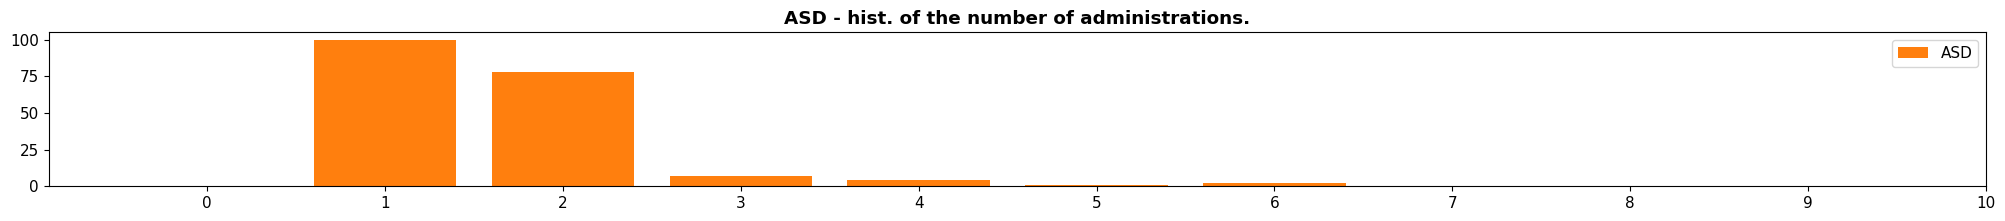

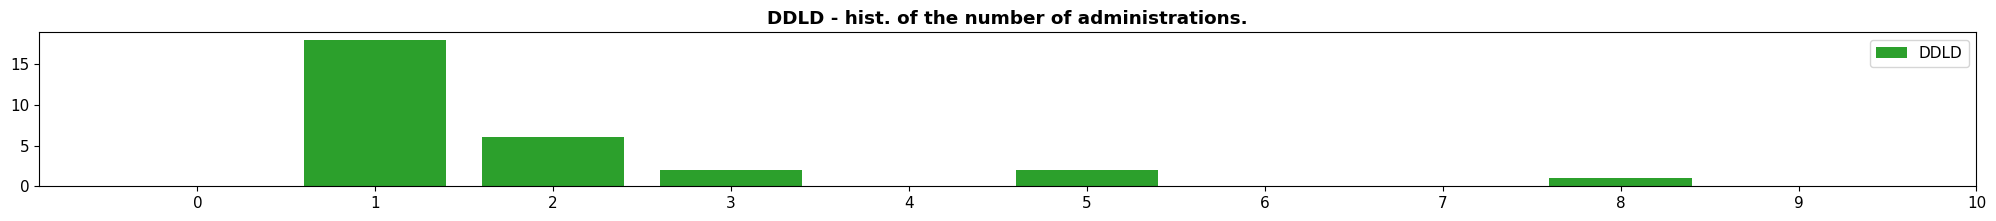

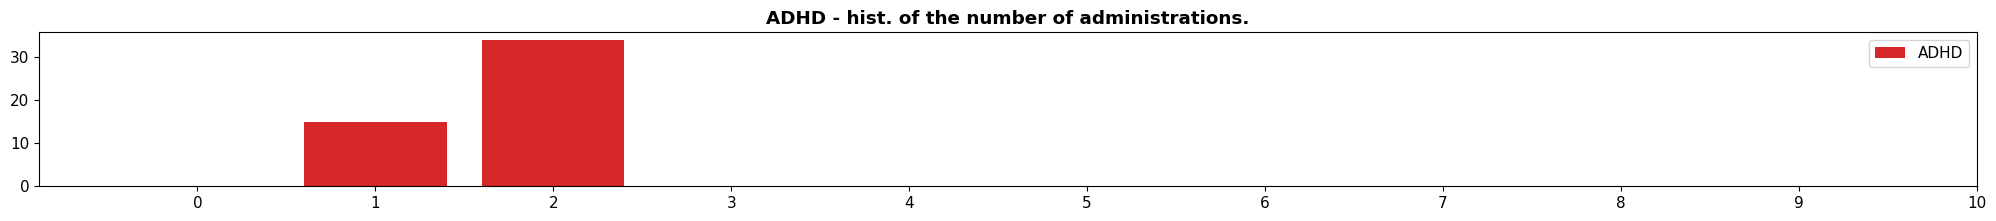

In [54]:
for i, d in df.groupby('diagnosis'):
    plt.figure(figsize=(25, 2)), 
    plt.hist(d.groupby("id")['diagnosis'].count().to_numpy(), bins = np.linspace(0, 10 , 11), rwidth=.8,color=colors[DIAG_DICT_REVERSE[i]], label=DIAG_DICT_REVERSE[i])
    plt.xticks(ticks=np.linspace(0, 10 , 11)+.5, labels=np.linspace(0, 10 , 11).astype(int));plt.legend()
    plt.title("{} - hist. of the number of administrations.".format(DIAG_DICT_REVERSE[i]), weight='bold')

In [20]:
def select(data,feature,value,unique=False):
    """Example : select(data,'ASD+',1,unique=True)
                 select(data,'sex','Male')
    """
    if unique:
        data_unique=data.drop_duplicates(subset = "id",keep='first')
        selected_data = data_unique[data_unique[feature]==value]
    else:
        selected_data = data[data[feature]==value]
    return(selected_data)

def my_fmt(x):
    return '{:.1f}%\n({:.0f})'.format(x, len(df)*x/100)

df_unique = deepcopy(df[df.duplicated(subset=['id'], keep='first')])

for col in ['diagnosis', 'sex']:
    n = df_unique.groupby(col).count().id.to_numpy()
    labels = df_unique.groupby(col).count().index

    plt.figure(figsize=(12, 8))
    plt.pie(n, labels=labels, autopct=my_fmt)
    plt.title(col)
    plt.show()

Predicting diagnosis based on 40 features

**********************************
 statistics:

**********************************
1220 subjects 
697  male
523  female
0  unknown sex beacause of missing clinical data 


**********************************
192 subjects in the ASD group
136 number of male
56 number of female 
 

**********************************
950 subjects in the TD group
502 number of male
448 number of female 


**********************************
29 subjects in the DL/DD group
21 number of male
8 number of female 


**********************************
49 subjects in the ADHD group
38 number of male
38 number of female 



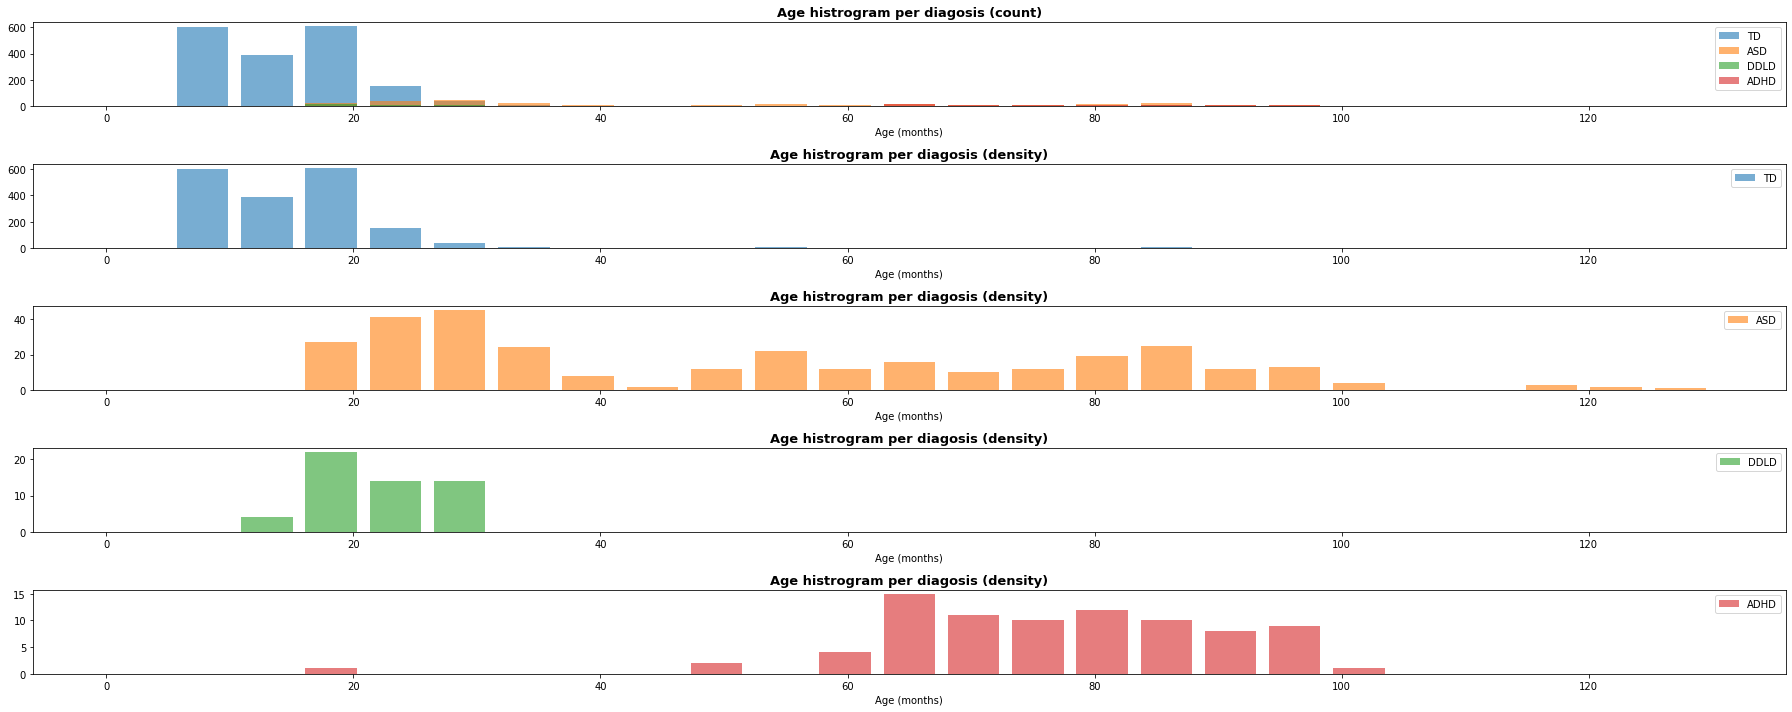

In [54]:
df = pd.read_csv("/home01/sam/df_all.csv")

data = Dataset(df=df, 
               missing_data_handling='encoding', 
               imputation_method='without', 
               proportion_train=1)

DIAG_DICT = {'TD':0., 
            'ASD':1., 
            'DDLD':2., 
            'ADHD':3.}
DIAG_DICT_REVERSE = {v: k for k, v in DIAG_DICT.items()}

colors = {'TD':'#1f77b4',
          'ASD': '#ff7f0e',
          'DDLD':'#2ca02c',
          'ADHD':'#d62728',
          'comorbid':'#9467bd'}
           
    
fig, axes = plt.subplots(5, 1, figsize=(25, 10)); axes=axes.flatten()

for i, d in df.groupby('diagnosis'):
    axes[0].hist(d['age'], bins=np.linspace(0, 130, 26), density=False, alpha=.6, rwidth=.8, color=colors[DIAG_DICT_REVERSE[i]], label=DIAG_DICT_REVERSE[i])
axes[0].legend(); axes[0].set_title("Age histrogram per diagosis (count)", weight='bold', fontsize=13); axes[0].set_xlabel("Age (months)")

for i, d in df.groupby('diagnosis'):
    axes[int(i+1)].hist(d['age'], bins=np.linspace(0, 130, 26), density=False, alpha=.6, rwidth=.8, color=colors[DIAG_DICT_REVERSE[i]], label=DIAG_DICT_REVERSE[i])
    axes[int(i+1)].legend(); axes[int(i+1)].set_title("Age histrogram per diagosis (density)", weight='bold', fontsize=13);axes[int(i+1)].set_xlabel("Age (months)")
plt.tight_layout()


"""
    Print population statistics at the beginning of the notebook.
"""
print('\n**********************************')
print(' statistics:')
print('\n**********************************')
data = df
# Masks
data_unique=data.drop_duplicates(subset = "id",keep='first')
data_unique_asd = select(data,'diagnosis',1,True)
data_unique_nasd = select(data,'diagnosis',0,True)
data_male = select(data,'sex',0)
data_female = select(data,'sex',1)
data_asd = select(data,'diagnosis',1)
data_nasd = select(data,'diagnosis',0)


#Count the number of subjects
subjects_id = np.unique(data['id'])
number_of_subjects = len(subjects_id)

subject_male = np.sum(data_unique['sex']==0)
subject_female = np.sum(data_unique['sex']==1)
subject_unknown = np.sum(pd.isna(data_unique['sex']))

print('{} subjects '.format(number_of_subjects))
print('{}  male'.format(subject_male))
print('{}  female'.format(subject_female)) 
print('{}  unknown sex beacause of missing clinical data \n'.format(subject_unknown)) 

# mchat_total_1_positive=data_unique.loc[data_unique['clinical_mchat_total_score']>=3]
# mchat_final_1_positive = mchat_total_1_positive.loc[mchat_total_1_positive['clinical_final_mchat_score']>=2]    
# mchat_total_2_positive=data_unique.loc[data_unique['clinical_mchat_total_score2']>=3]
# mchat_final_2_positive = mchat_total_1_positive.loc[mchat_total_1_positive['clinical_final_mchat_score2']>=2]    

# print('\n**********************************')
# print('{} subjects are "mchat positive" (First Adminisstration) '.format(len(mchat_final_1_positive)))
# print('{} subjects are "mchat positive" (Second Adminisstration) '.format(len(mchat_final_2_positive)))


nasd_subjects_id = data_unique_nasd[['id','sex']]
nasd_subject_male = np.sum(data_unique_nasd['sex']==0)
nasd_subject_female = np.sum(data_unique_nasd['sex']==1)

asd_subjects_id = data_unique_asd[['id','sex']]
asd_subject_male = np.sum(data_unique_asd['sex']==0)
asd_subject_female = np.sum(data_unique_asd['sex']==1)

dd_subjects_id = select(data_unique,'diagnosis', 2)[['id','sex']]
dd_subject_male = np.sum(dd_subjects_id['sex']==0)
dd_subject_female = np.sum(dd_subjects_id['sex']==1)

adhd_subjects_id = select(data_unique,'diagnosis', 3)[['id','sex']]
adhd_subject_male = np.sum(adhd_subjects_id['sex']==0)
adhd_subject_female = np.sum(adhd_subjects_id['sex']==1)

print('\n**********************************')
print('{} subjects in the ASD group'.format(len(asd_subjects_id)))
print('{} number of male'.format(asd_subject_male))
print('{} number of female \n '.format(asd_subject_female)) 


print('\n**********************************')
print('{} subjects in the TD group'.format(len(nasd_subjects_id)))
print('{} number of male'.format(nasd_subject_male))
print('{} number of female \n'.format(nasd_subject_female)) 



print('\n**********************************')
print('{} subjects in the DL/DD group'.format(len(dd_subjects_id)))
print('{} number of male'.format(dd_subject_male))
print('{} number of female \n'.format(dd_subject_female)) 

print('\n**********************************')
print('{} subjects in the ADHD group'.format(len(adhd_subjects_id)))
print('{} number of male'.format(adhd_subject_male))
print('{} number of female \n'.format(adhd_subject_male)) 

In [6]:
import missingno as msno

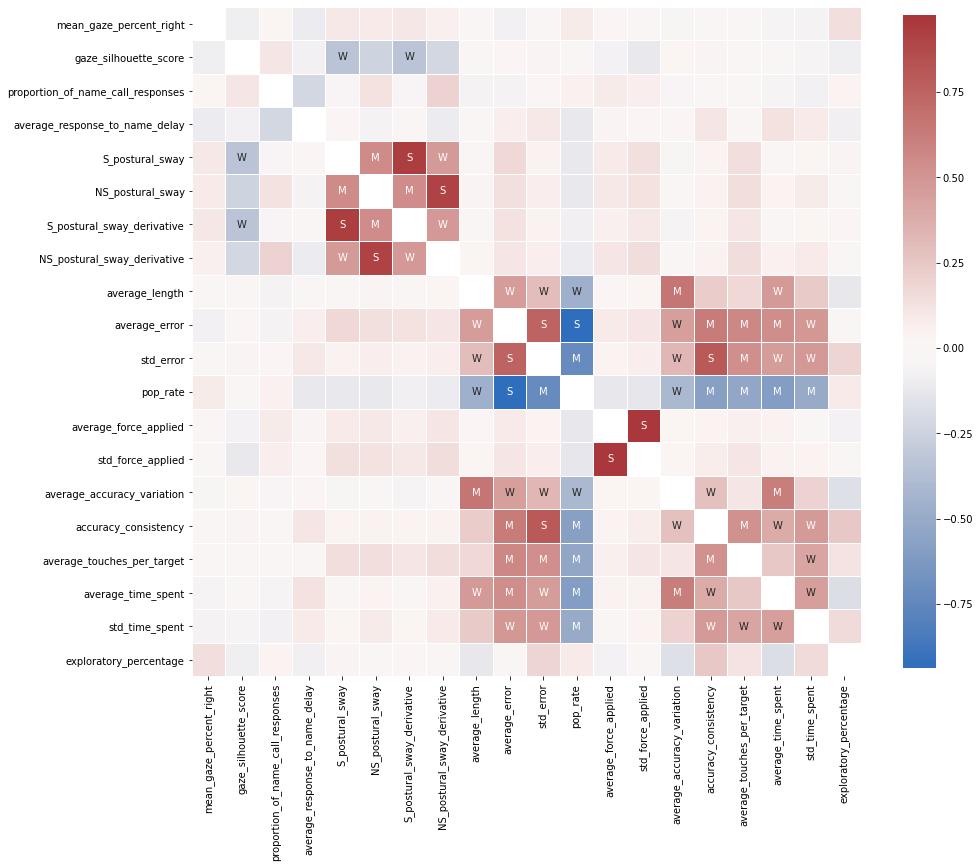

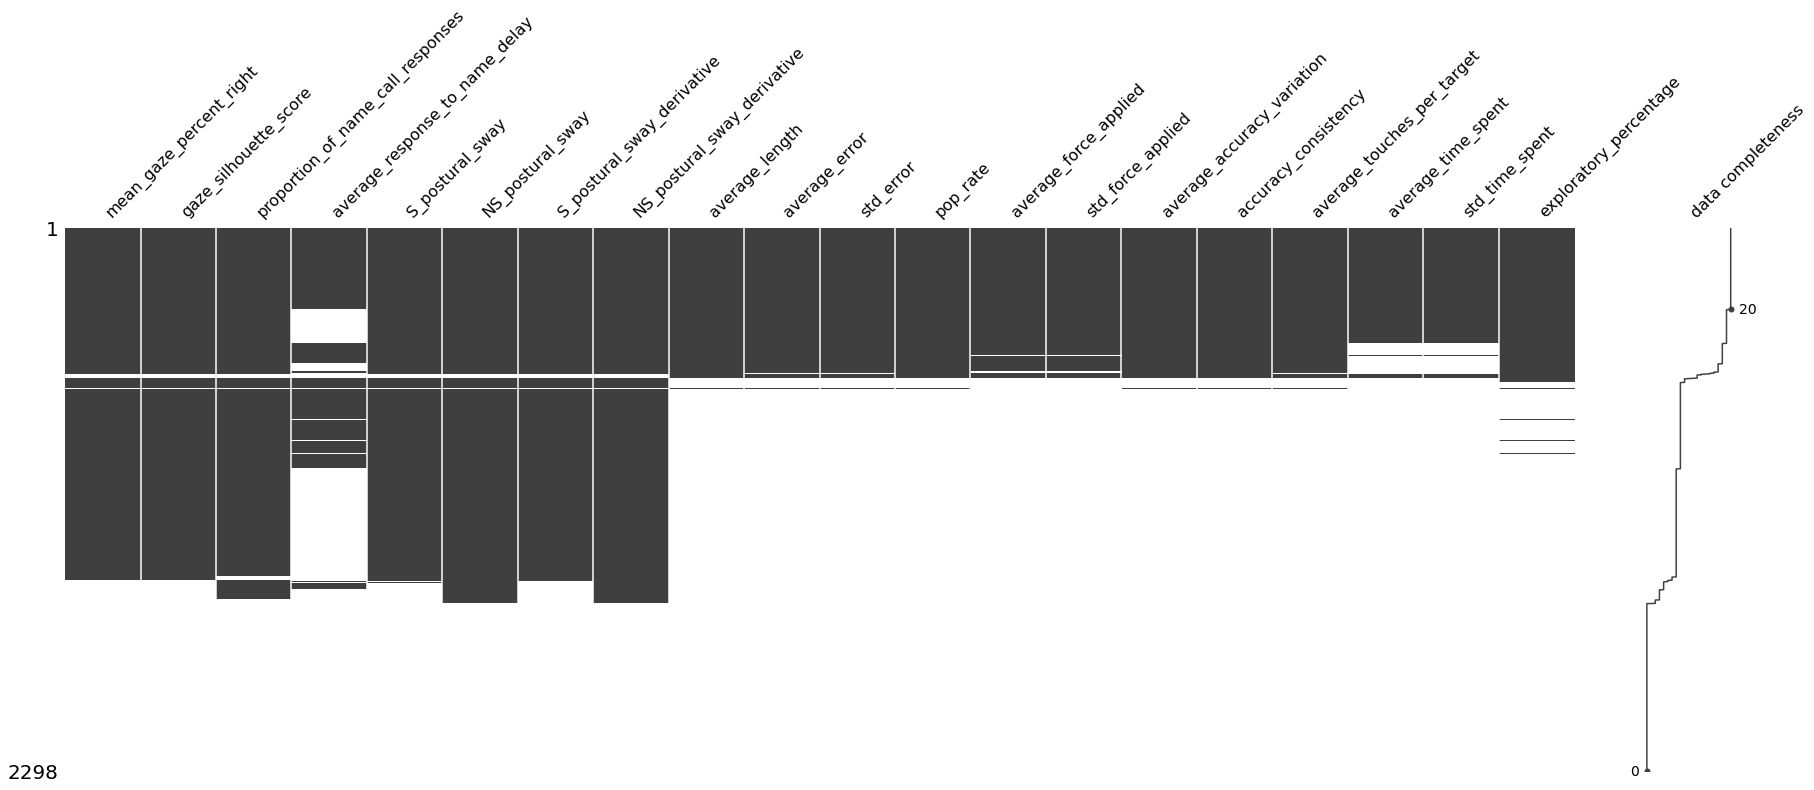

In [89]:
df_X = df[data.features_name[:int(len(data.features_name)//2)]]
# Computes feature correlation
df_corr = df_X.corr(method="pearson")

labels = np.where(np.abs(df_corr)>0.75, "S",
                  np.where(np.abs(df_corr)>0.5, "M",
                           np.where(np.abs(df_corr)>0.25, "W", "")))

# Plot correlation matrix
plt.figure(figsize=(15, 15))
sns.heatmap(df_corr, mask=np.eye(len(df_corr)), square=True,
            center=0, annot=labels, fmt='', linewidths=.5,
            cmap="vlag", cbar_kws={"shrink": 0.8});


msno.matrix(df_X, labels=True, sort="descending", figsize=(30, 10));

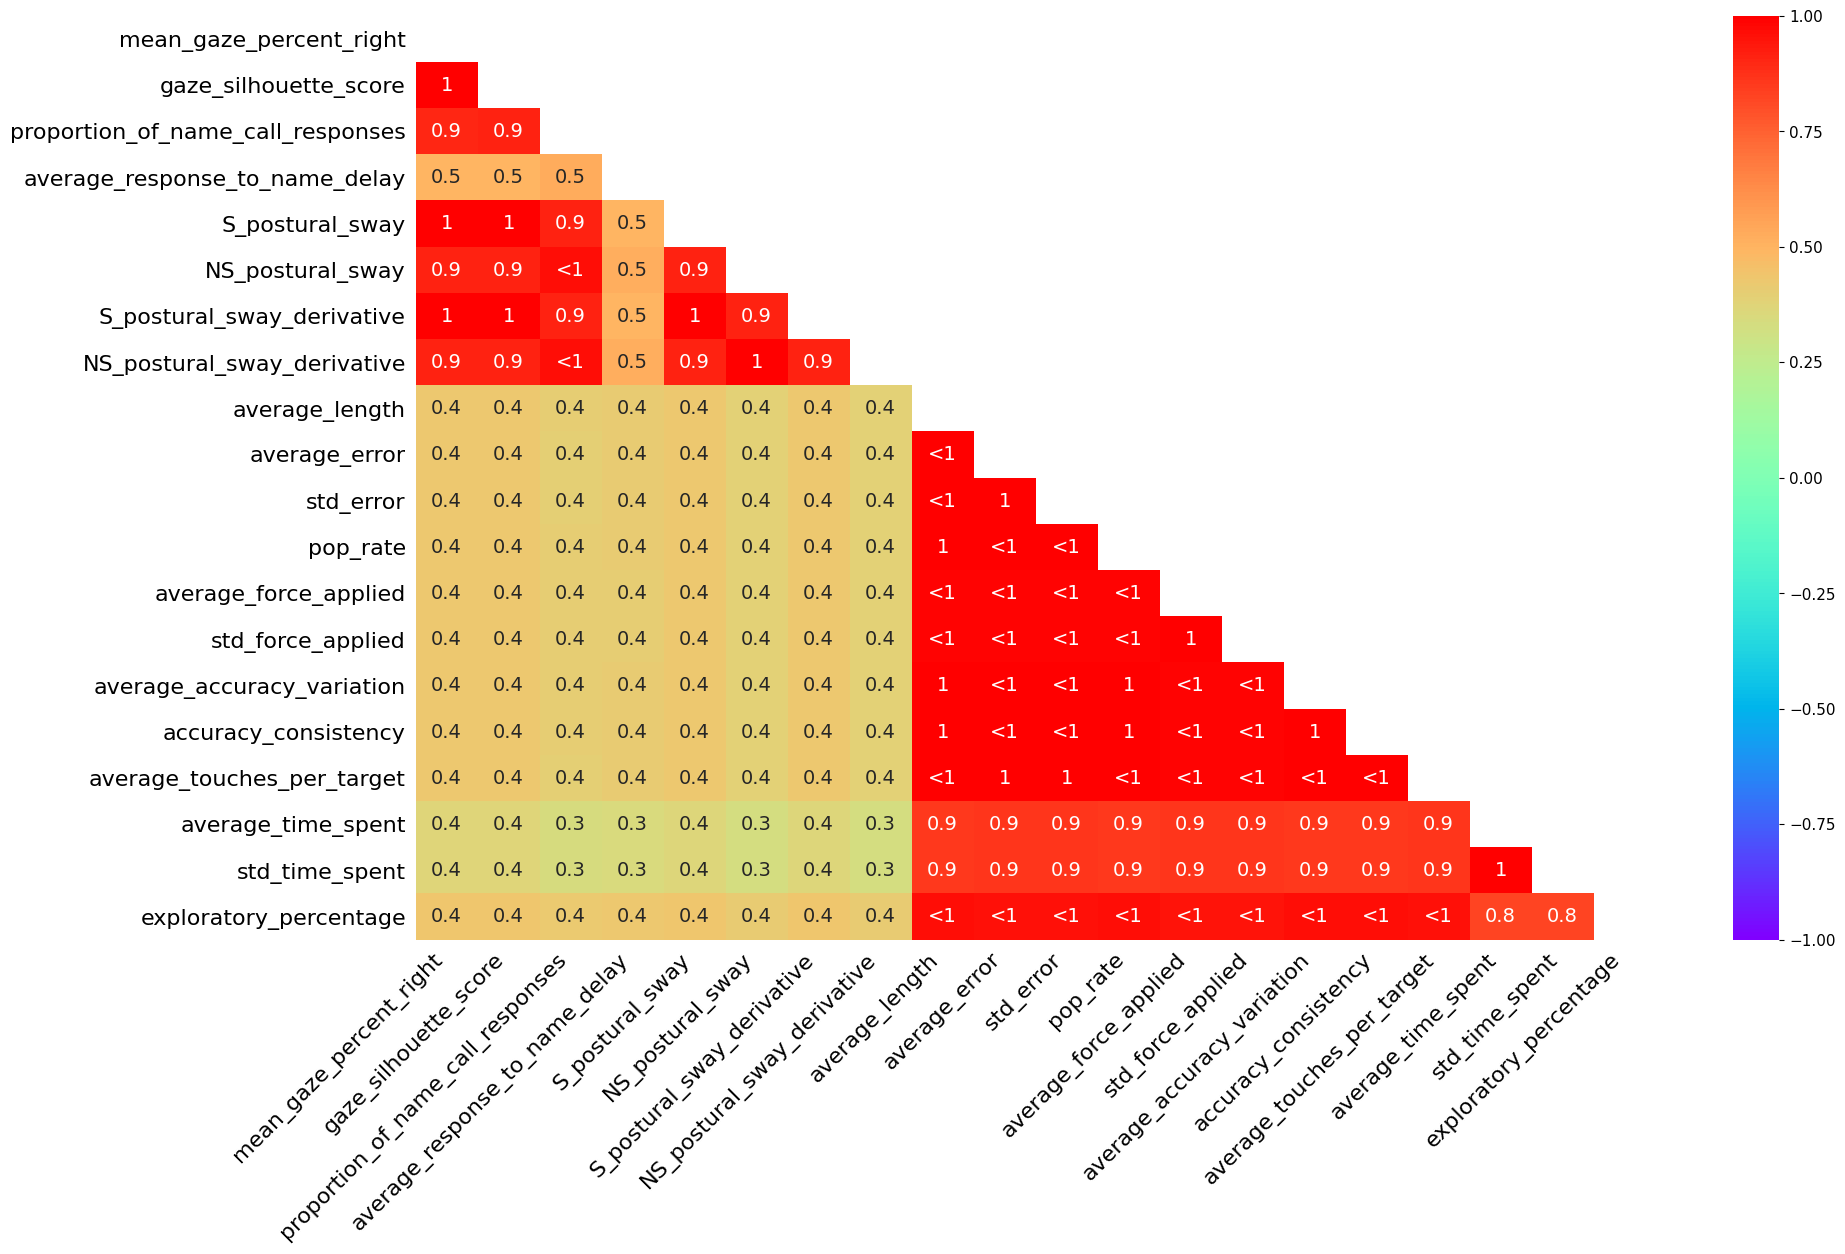

In [8]:
msno.heatmap(df_X, cmap='rainbow');


<AxesSubplot:>

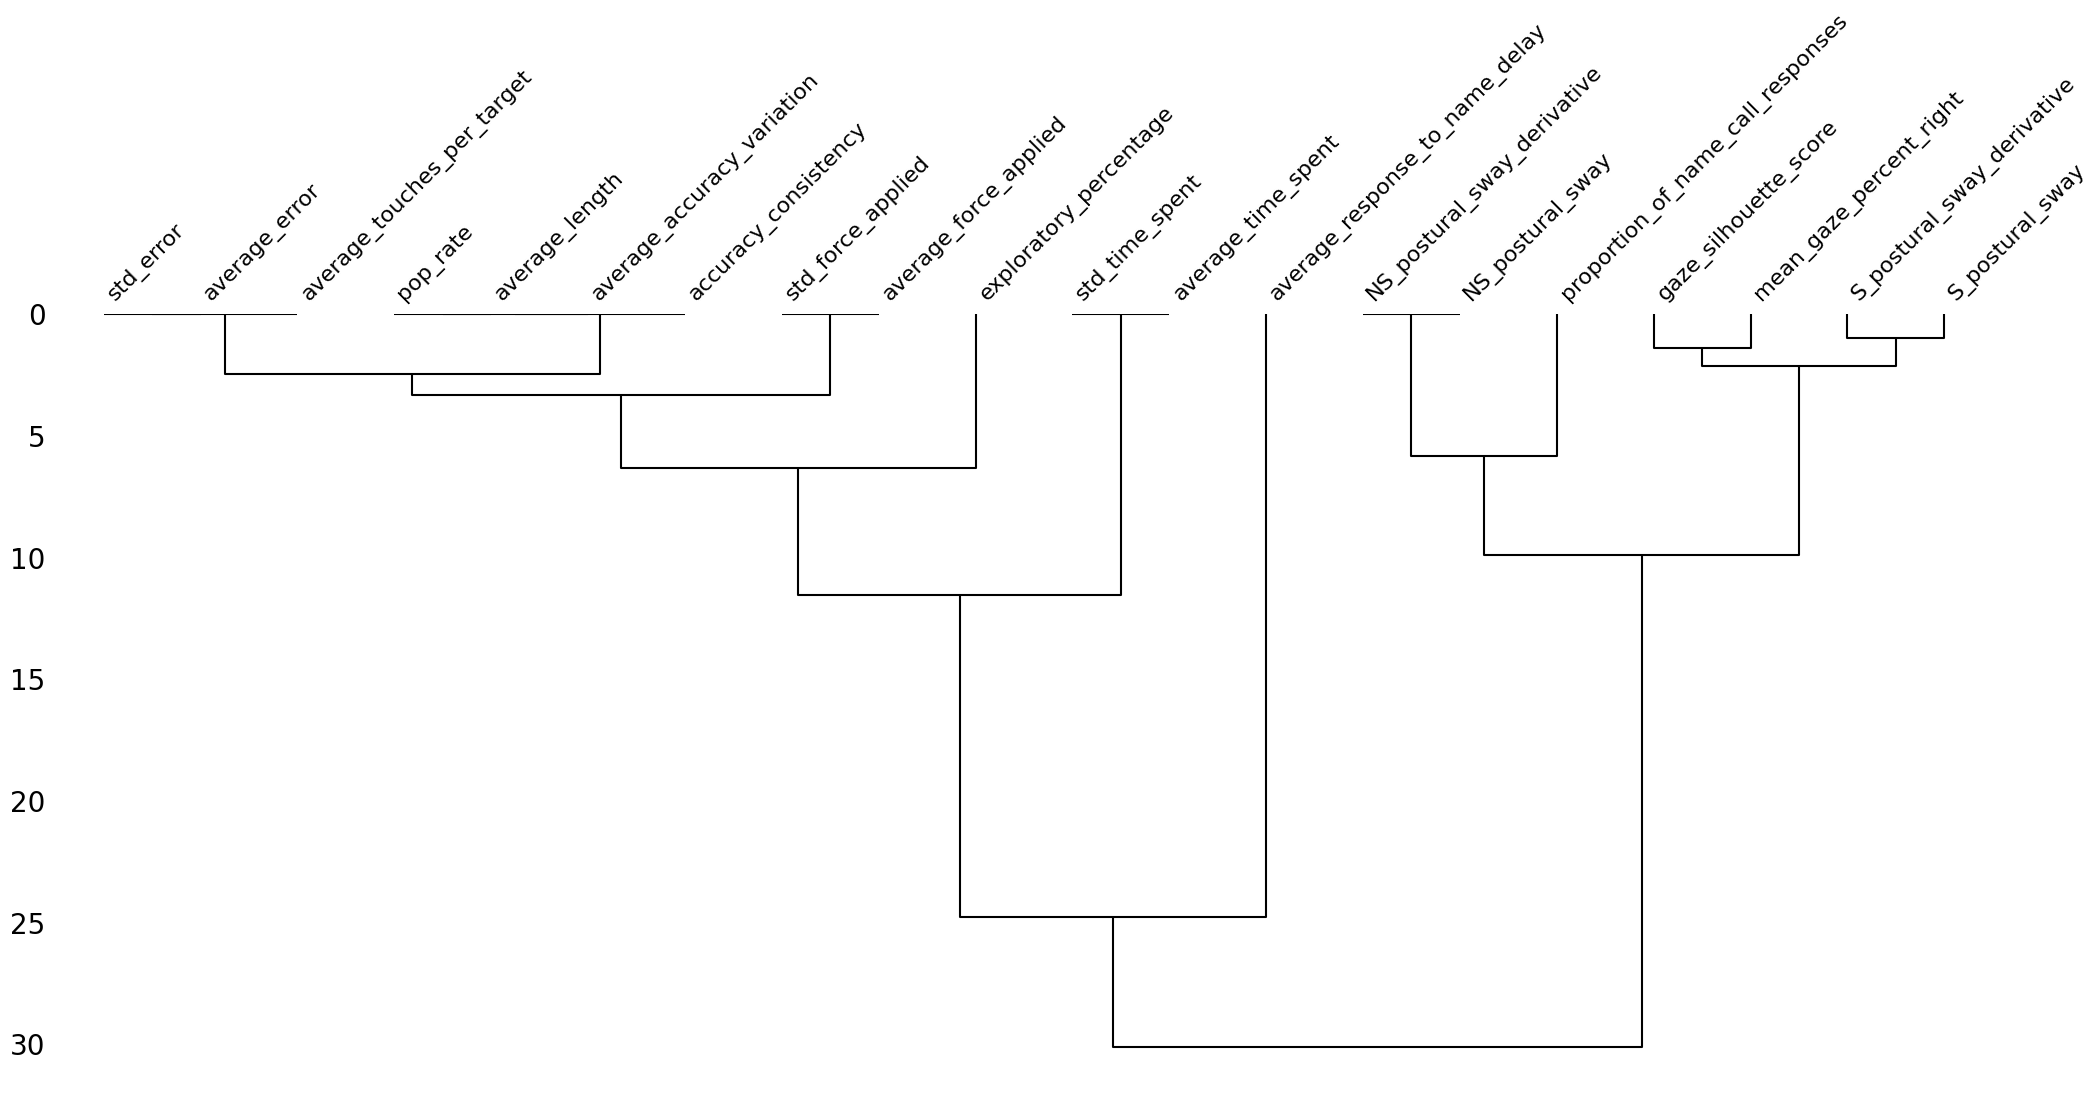

In [10]:
msno.dendrogram(df_X)

In [102]:
#  Creates a mask to remove the diagonal and the upper triangle.
lower_triangle_mask = np.tril(np.ones(df_corr.shape), k=-1).astype("bool")

#  Stack all correlations, after applying the mask
df_corr_stacked = df_corr.where(lower_triangle_mask).stack().sort_values()

#  Showing the lowest and highest correlations in the correlation matrix
display(df_corr_stacked)

pop_rate                     average_error           -0.936662
                             std_error               -0.723631
average_time_spent           pop_rate                -0.593849
accuracy_consistency         pop_rate                -0.582379
average_touches_per_target   pop_rate                -0.532550
                                                        ...   
std_error                    average_error            0.756120
accuracy_consistency         std_error                0.801857
NS_postural_sway_derivative  NS_postural_sway         0.912165
S_postural_sway_derivative   S_postural_sway          0.935392
std_force_applied            average_force_applied    0.973714
Length: 190, dtype: float64

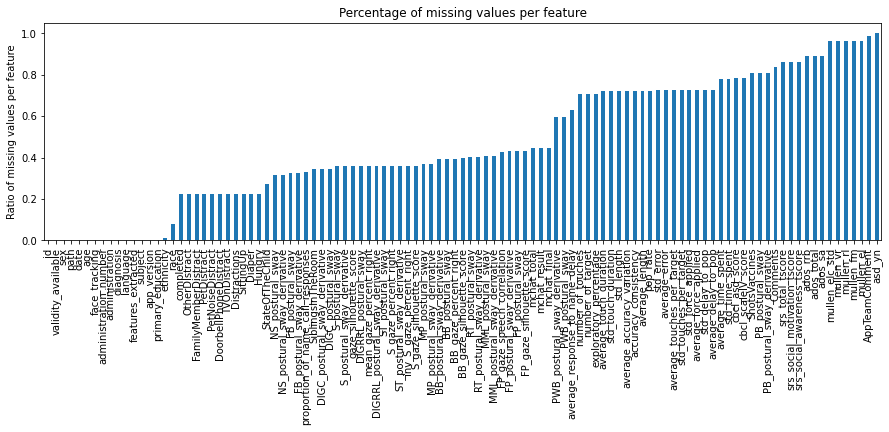

In [85]:
df.isna().mean().sort_values().plot(
    kind="bar", figsize=(15, 4),
    title="Percentage of missing values per feature",
    ylabel="Ratio of missing values per feature");

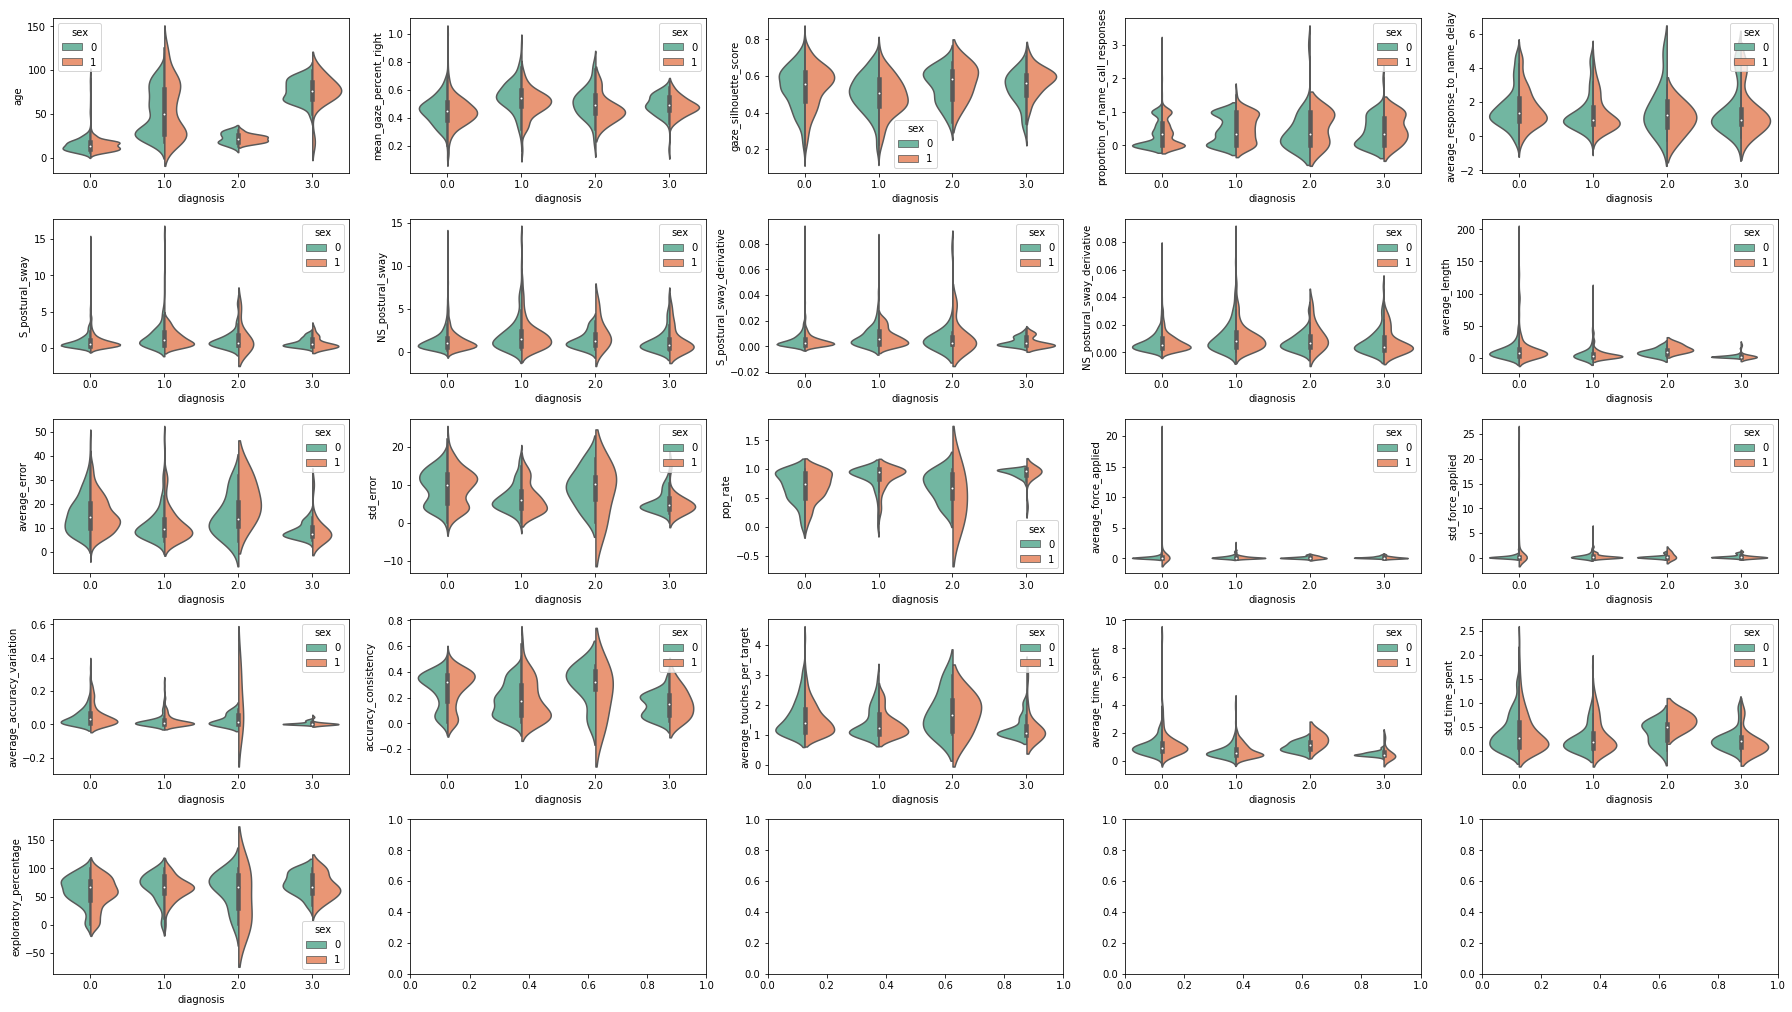

In [129]:
selected_features = ['age'] + data.features_name[:int(len(data.features_name)//2)]

# Create a figure with 3 x 2 subplots
fig, axes = plt.subplots(ncols=5, nrows=len(selected_features)//5 +1, figsize=(25, 14))
# Loop through these features and plot entries from each feature against `Latitude`
for col, ax in zip(selected_features, axes.ravel()):
    sns.violinplot(data=df, y=col, x='diagnosis', hue='sex', palette="Set2",
                   split=True, ax=ax)
plt.tight_layout()